In [615]:
#SEconde version of notebookincorporating new modules and FE techniques
#url: https://www.kaggle.com/mgmarques/houses-prices-complete-solution#House-Prices---Kaggle-Copetitions


### LINK: PARA REVISAR TODAS LAS TECNICAS DE DATA PROCESSING: https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114 
### REFERENCE KERNELS: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
##reference kernl updated: https://www.kaggle.com/amiiiney/price-prediction-top-15-regularization-stacking/comments#2--Data-cleaning

In [616]:
##Import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta

# import all libraries and dependencies for data visualization
pd.options.display.float_format='{:.4f}'.format
plt.rcParams['figure.figsize'] = [8,8]
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1) 
pd.set_option("display.max_rows", 500)
sns.set(style='darkgrid')
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker


# import all libraries and dependencies for machine learning
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.compose import make_column_transformer


import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from scipy import stats
from scipy.stats import norm, kurtosis, skew

# Import specific libraries
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('expand_frame_repr', False)

**1. Reading and Understanding the Data**

In [617]:
# READ THE WHOLE DATASET:
# We load and read the whole dataset (train + test) because we need to clean and preprocess all of it!!!!
#All the procedures must be applied to the entire dataset before split it!

#Step 1: Load train and test sets

train = pd.read_csv("train.csv")
test = pd.read_csv("test_house_mae.csv")
test.to_csv("test_file.csv")

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Drop ID from both datasets
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Shape of the datasets
train.shape, test.shape, train.shape[0], test.shape[0]

#Separar y convertir el target en DataFrame
y_train = train["SalePrice"].to_frame()


#Step 2: Concatenate both datasets into one

df = pd.concat((train,test), sort = False).reset_index(drop = True)

#drop target and id columns
df.drop(columns = ["SalePrice"], axis = 1, inplace = True)


In [618]:
#Storing data for using them in another notebook
%store y_train 
%store train 
%store test 


Stored 'y_train' (DataFrame)
Stored 'train' (DataFrame)
Stored 'test' (DataFrame)


In [619]:
#Look at dataset head
df.head(2)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition
0  60          RL      65.0000       8450     Pave   NaN   Reg      Lvl         AllPub    Inside    Gtl       CollgCr      Norm       Norm       1Fam     2Story     7            5            2003       2003          Gable     CompShg  VinylSd     VinylSd     BrkFace   196.0000     Gd        TA        PConc      Gd       TA       No           GLQ         706.0000     Unf         0.0000      150.0000   856.0000      GasA    Ex        Y          SBrkr      856       854       0             1710      1.0000        0.0000         2         1         3             1             Gd          8             Typ        0           NaN         Attchd    2003.0000     RFn         2.0000      548.0000     TA         TA         Y          0           61           0              0          0            0         NaN    NaN   NaN         0        2       2008    WD       Normal      
1  20          RL      80.0000       9600     Pave   NaN   Reg      Lvl         AllPub    FR2       Gtl       Veenker      Feedr      Norm       1Fam     1Story     6            8            1976       1976          Gable     CompShg  MetalSd     MetalSd     None      0.0000       TA        TA        CBlock     Gd       TA       Gd           ALQ         978.0000     Unf         0.0000      284.0000   1262.0000     GasA    Ex        Y          SBrkr      1262      0         0             1262      0.0000        1.0000         2         0         3             1             TA          6             Typ        1           TA          Attchd    1976.0000     RFn         2.0000      460.0000     TA         TA         Y          298         0            0              0          0            0         NaN    NaN   NaN         0        5       2007    WD       Normal

In [620]:
# Information of the dataset
df.shape

(2919, 79)

In [621]:
#Modulo: General summary of dataset
def summary_2(df, target):
    num = df.select_dtypes(exclude= object).columns
    cols = ["Dtype","Uniques", "Nulls","% Nulls", "Skew", "Kurtosis", "Correlation"]
    ind = df.columns
    dict = {}
    dict["Dtype"] = [df[i].dtype for i in ind]
    dict["Uniques"] = [df[i].nunique() for i in ind]
    dict["Nulls"] =[df[i].isnull().sum().sum() for i in ind]
    dict["% Nulls"] = np.round([df[i].isnull().sum().sum()/len(df[i]) for i in ind], decimals = 2)
    dict["Skew"] =  np.round(df.skew(), decimals = 3) 
    dict["Kurtosis"] = np.round(df.kurt(), decimals = 3)
    dict["Correlation"] = np.round(df.corr()[target], decimals = 3)
    summary = pd.DataFrame(dict, columns = cols, index = ind)
    return summary

sum = summary_2(train, "SalePrice").sort_values(by = "Dtype").sort_values(by = "Correlation", ascending = False)
sum

Dtype  Uniques  Nulls  % Nulls    Skew  Kurtosis  Correlation
SalePrice      int64    663      0     0.0000   1.8830  6.5360    1.0000      
OverallQual    int64    10       0     0.0000   0.2170  0.0960    0.7910      
GrLivArea      int64    861      0     0.0000   1.3670  4.8950    0.7090      
GarageCars     int64    5        0     0.0000   -0.3430 0.2210    0.6400      
GarageArea     int64    441      0     0.0000   0.1800  0.9170    0.6230      
TotalBsmtSF    int64    721      0     0.0000   1.5240  13.2500   0.6140      
1stFlrSF       int64    753      0     0.0000   1.3770  5.7460    0.6060      
FullBath       int64    4        0     0.0000   0.0370  -0.8570   0.5610      
TotRmsAbvGrd   int64    12       0     0.0000   0.6760  0.8810    0.5340      
YearBuilt      int64    112      0     0.0000   -0.6130 -0.4400   0.5230      
YearRemodAdd   int64    61       0     0.0000   -0.5040 -1.2720   0.5070      
GarageYrBlt    float64  97       81    0.0600   -0.6490 -0.4180   0.4860      
MasVnrArea     float64  327      8     0.0100   2.6690  10.0820   0.4770      
Fireplaces     int64    4        0     0.0000   0.6500  -0.2170   0.4670      
BsmtFinSF1     int64    637      0     0.0000   1.6860  11.1180   0.3860      
LotFrontage    float64  110      259   0.1800   2.1640  17.4530   0.3520      
WoodDeckSF     int64    274      0     0.0000   1.5410  2.9930    0.3240      
2ndFlrSF       int64    417      0     0.0000   0.8130  -0.5530   0.3190      
OpenPorchSF    int64    202      0     0.0000   2.3640  8.4900    0.3160      
HalfBath       int64    3        0     0.0000   0.6760  -1.0770   0.2840      
LotArea        int64    1073     0     0.0000   12.2080 203.2430  0.2640      
BsmtFullBath   int64    4        0     0.0000   0.5960  -0.8390   0.2270      
BsmtUnfSF      int64    780      0     0.0000   0.9200  0.4750    0.2140      
BedroomAbvGr   int64    8        0     0.0000   0.2120  2.2310    0.1680      
ScreenPorch    int64    76       0     0.0000   4.1220  18.4390   0.1110      
PoolArea       int64    8        0     0.0000   14.8280 223.2680  0.0920      
MoSold         int64    12       0     0.0000   0.2120  -0.4040   0.0460      
3SsnPorch      int64    20       0     0.0000   10.3040 123.6620  0.0450      
BsmtFinSF2     int64    144      0     0.0000   4.2550  20.1130   -0.0110     
BsmtHalfBath   int64    3        0     0.0000   4.1030  16.3970   -0.0170     
MiscVal        int64    21       0     0.0000   24.4770 701.0030  -0.0210     
LowQualFinSF   int64    24       0     0.0000   9.0110  83.2350   -0.0260     
YrSold         int64    5        0     0.0000   0.0960  -1.1910   -0.0290     
OverallCond    int64    9        0     0.0000   0.6930  1.1060    -0.0780     
MSSubClass     int64    15       0     0.0000   1.4080  1.5800    -0.0840     
EnclosedPorch  int64    120      0     0.0000   3.0900  10.4310   -0.1290     
KitchenAbvGr   int64    4        0     0.0000   4.4880  21.5320   -0.1360     
BsmtQual       object   4        37    0.0300   nan     nan       nan         
GarageFinish   object   3        81    0.0600   nan     nan       nan         
Neighborhood   object   25       0     0.0000   nan     nan       nan         
LandSlope      object   3        0     0.0000   nan     nan       nan         
GarageQual     object   5        81    0.0600   nan     nan       nan         
GarageCond     object   5        81    0.0600   nan     nan       nan         
PavedDrive     object   3        0     0.0000   nan     nan       nan         
Utilities      object   2        0     0.0000   nan     nan       nan         
LandContour    object   4        0     0.0000   nan     nan       nan         
LotShape       object   4        0     0.0000   nan     nan       nan         
Alley          object   2        1369  0.9400   nan     nan       nan         
Street         object   2        0     0.0000   nan     nan       nan         
PoolQC         object   3        1453  1.0000   nan     nan       n

In [622]:
##Features with the highest correlations (15)
sum.sort_values(by = "Correlation", ascending = False)[:15]

Dtype  Uniques  Nulls  % Nulls    Skew  Kurtosis  Correlation
SalePrice     int64    663      0     0.0000   1.8830  6.5360    1.0000      
OverallQual   int64    10       0     0.0000   0.2170  0.0960    0.7910      
GrLivArea     int64    861      0     0.0000   1.3670  4.8950    0.7090      
GarageCars    int64    5        0     0.0000   -0.3430 0.2210    0.6400      
GarageArea    int64    441      0     0.0000   0.1800  0.9170    0.6230      
TotalBsmtSF   int64    721      0     0.0000   1.5240  13.2500   0.6140      
1stFlrSF      int64    753      0     0.0000   1.3770  5.7460    0.6060      
FullBath      int64    4        0     0.0000   0.0370  -0.8570   0.5610      
TotRmsAbvGrd  int64    12       0     0.0000   0.6760  0.8810    0.5340      
YearBuilt     int64    112      0     0.0000   -0.6130 -0.4400   0.5230      
YearRemodAdd  int64    61       0     0.0000   -0.5040 -1.2720   0.5070      
GarageYrBlt   float64  97       81    0.0600   -0.6490 -0.4180   0.4860      
MasVnrArea    float64  327      8     0.0100   2.6690  10.0820   0.4770      
Fireplaces    int64    4        0     0.0000   0.6500  -0.2170   0.4670      
BsmtFinSF1    int64    637      0     0.0000   1.6860  11.1180   0.3860

In [623]:
####GENERATE GROUPS OF FEATURES ACCORDING WITH THEIR SKEW/KURT/CORR VALUES

In [624]:
### Features high skewed right, heavy-tailed distribution, and with high correlation: apply transformations and manage outliers
sum_1 = sum[(abs(sum["Skew"]) > 1) & (abs(sum["Kurtosis"]) > 3) & (abs(sum["Correlation"]) > 0.5)][["Skew", "Kurtosis", "Correlation"]]
print("Features high skewed right, heavy-tailed distribution, and with high correlation")
sum_1

Features high skewed right, heavy-tailed distribution, and with high correlation


Skew  Kurtosis  Correlation
SalePrice   1.8830 6.5360    1.0000      
GrLivArea   1.3670 4.8950    0.7090      
TotalBsmtSF 1.5240 13.2500   0.6140      
1stFlrSF    1.3770 5.7460    0.6060

In [625]:
### Features skewed, heavy-tailed distribution, and with good correlation: apply transformations and manage outliers

sum_2 = sum[(abs(sum["Skew"] > 1)) & (abs(sum["Kurtosis"]) > 1) & (abs(sum["Correlation"]) > 0.05)][["Skew", "Kurtosis", "Correlation"]].drop(sum_1.index)
print("Features skewed, heavy-tailed distribution, and with high correlation")
sum_2

Features skewed, heavy-tailed distribution, and with high correlation


Skew  Kurtosis  Correlation
MasVnrArea    2.6690  10.0820   0.4770      
BsmtFinSF1    1.6860  11.1180   0.3860      
LotFrontage   2.1640  17.4530   0.3520      
WoodDeckSF    1.5410  2.9930    0.3240      
OpenPorchSF   2.3640  8.4900    0.3160      
LotArea       12.2080 203.2430  0.2640      
ScreenPorch   4.1220  18.4390   0.1110      
PoolArea      14.8280 223.2680  0.0920      
MSSubClass    1.4080  1.5800    -0.0840     
EnclosedPorch 3.0900  10.4310   -0.1290     
KitchenAbvGr  4.4880  21.5320   -0.1360

In [626]:
##Features high skewed, heavy-tailed distribution, and with low correlation: Maybe we can drop these features, or just use they with other to create a new more important features:

sum_3 = sum[(abs(sum["Skew"] > 1)) & (abs(sum["Kurtosis"]) > 1) & (abs(sum["Correlation"]) > 0.01)][["Skew", "Kurtosis", "Correlation"]].drop((sum_1 + sum_2).index)
print("Features skewed, heavy-tailed distribution, and with high correlation")
sum_3


Features skewed, heavy-tailed distribution, and with high correlation


Skew  Kurtosis  Correlation
3SsnPorch    10.3040 123.6620  0.0450      
BsmtFinSF2   4.2550  20.1130   -0.0110     
BsmtHalfBath 4.1030  16.3970   -0.0170     
MiscVal      24.4770 701.0030  -0.0210     
LowQualFinSF 9.0110  83.2350   -0.0260

In [627]:
##Chequear como estan distribuidos los features con referencia al target y detectar posibles outliers (mirar primero los con mayor correlacion)

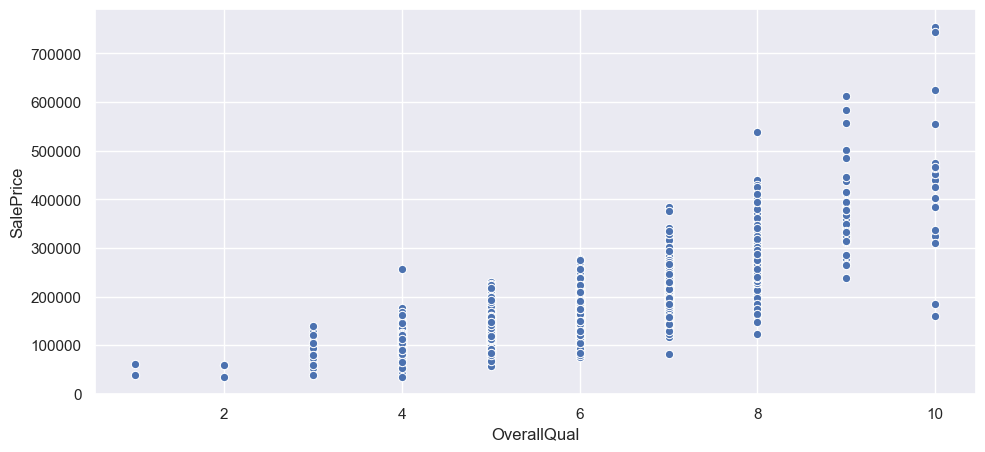

In [628]:
##OveralQuall
fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(121)
sns.scatterplot(x =train["OverallQual"], y = train.SalePrice, ax = ax)

In [629]:
##Primero: detectar puntos de posibles outliers. Aislarlos y ver qué tienen en común:
train[(train["OverallQual"] == 10) & (train["SalePrice"] < 200000)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
523   60          RL      130.0000      40094    Pave   NaN   IR1      Bnk         AllPub    Inside    Gtl       Edwards      PosN       PosN       1Fam     2Story     10           5            2007       2008          Hip       CompShg  CemntBd     CmentBd     Stone     762.0000     Ex        TA        PConc      Ex       TA       Gd           GLQ          2260        Unf          0           878        3138         GasA    Ex        Y          SBrkr      3138      1538      0             4676       1             0             3         1         3             1             Ex          11            Typ        1           Gd          BuiltIn   2007.0000     Fin          3           884         TA         TA         Y          208         406          0              0          0            0         NaN    NaN   NaN         0        10      2007    New      Partial       184750   
1298  60          RL      313.0000      63887    Pave   NaN   IR3      Bnk         AllPub    Corner    Gtl       Edwards      Feedr      Norm       1Fam     2Story     10           5            2008       2008          Hip       ClyTile  Stucco      Stucco      Stone     796.0000     Ex        TA        PConc      Ex       TA       Gd           GLQ          5644        Unf          0           466        6110         GasA    Ex        Y          SBrkr      4692      950       0             5642       2             0             2         1         3             1             Ex          12            Typ        3           Gd          Attchd    2008.0000     Fin          2           1418        TA         TA         Y          214         292          0              0          0            480       Gd     NaN   NaN         0        1       2008    New      Partial       160000

In [630]:
#Ambos puntos tienen bajo precio a pesar de la overalqual de 10

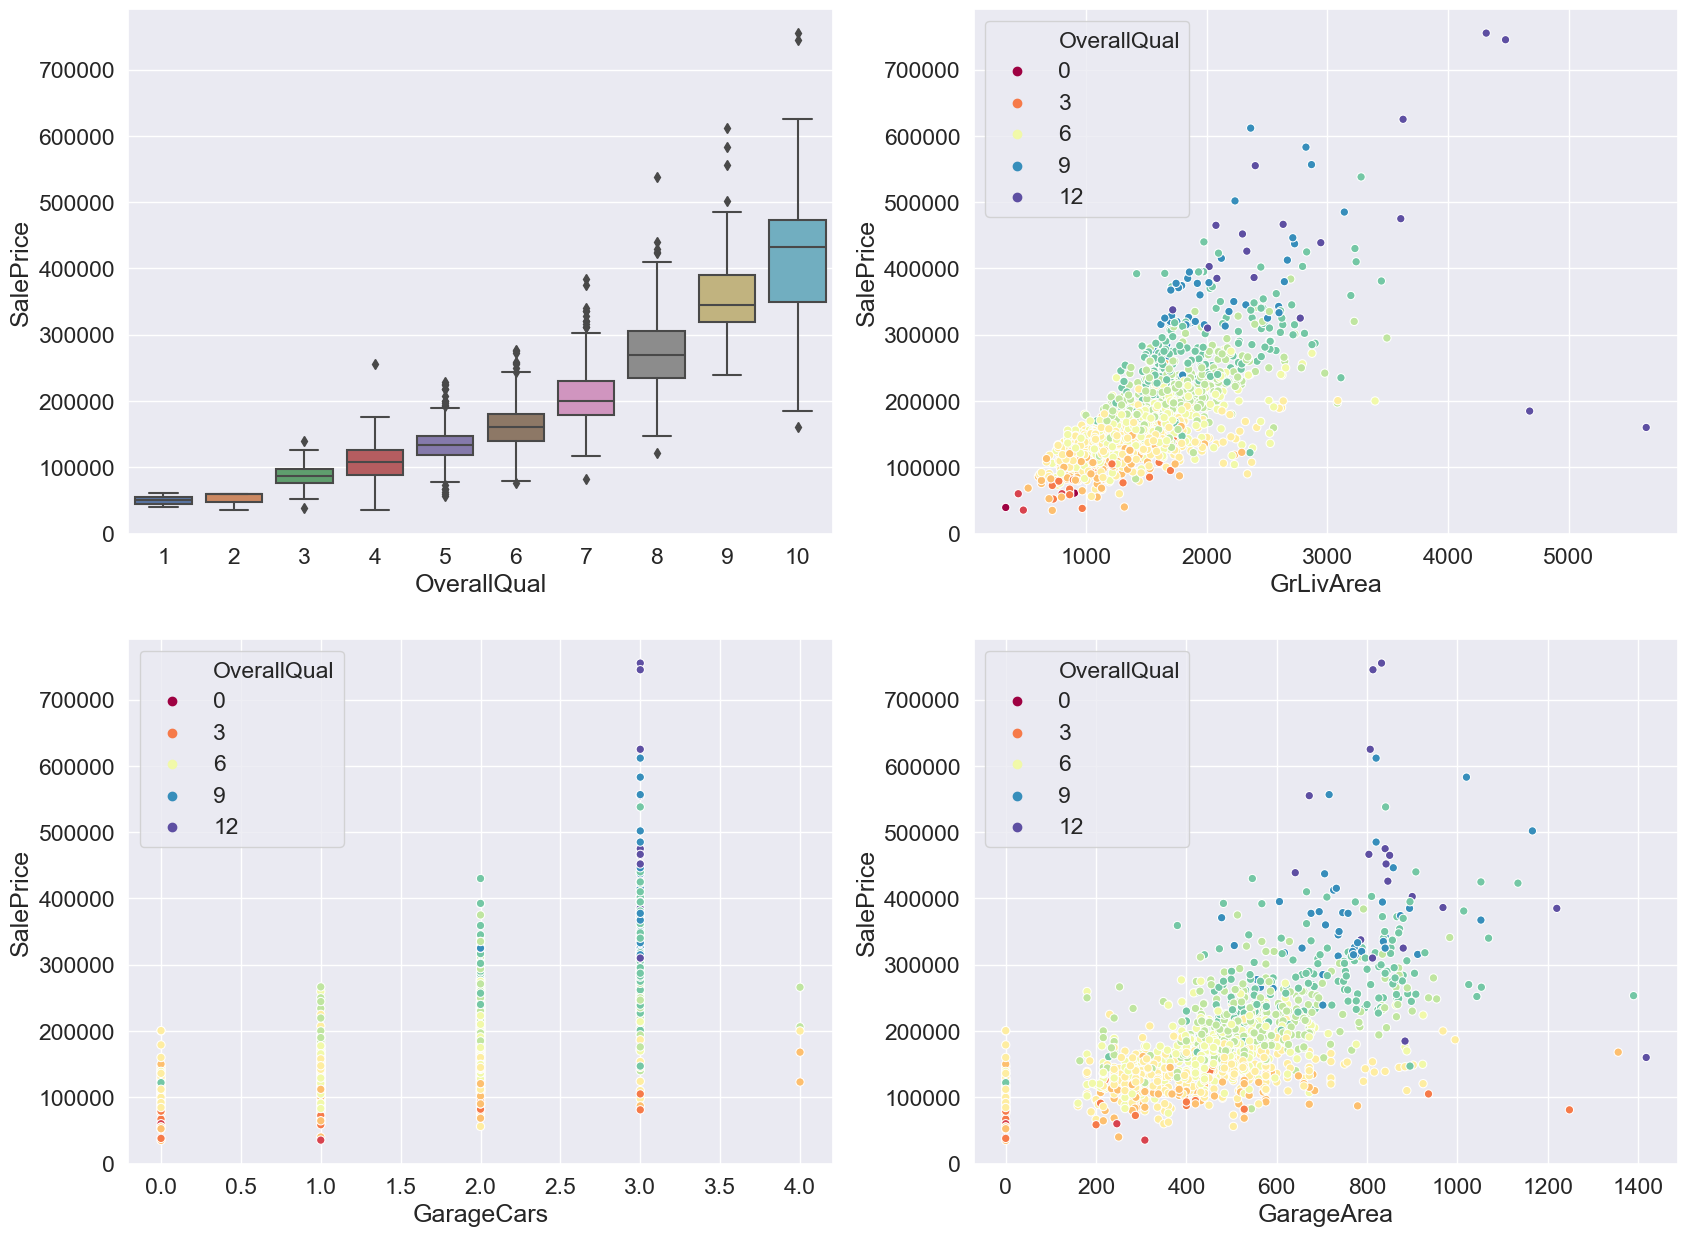

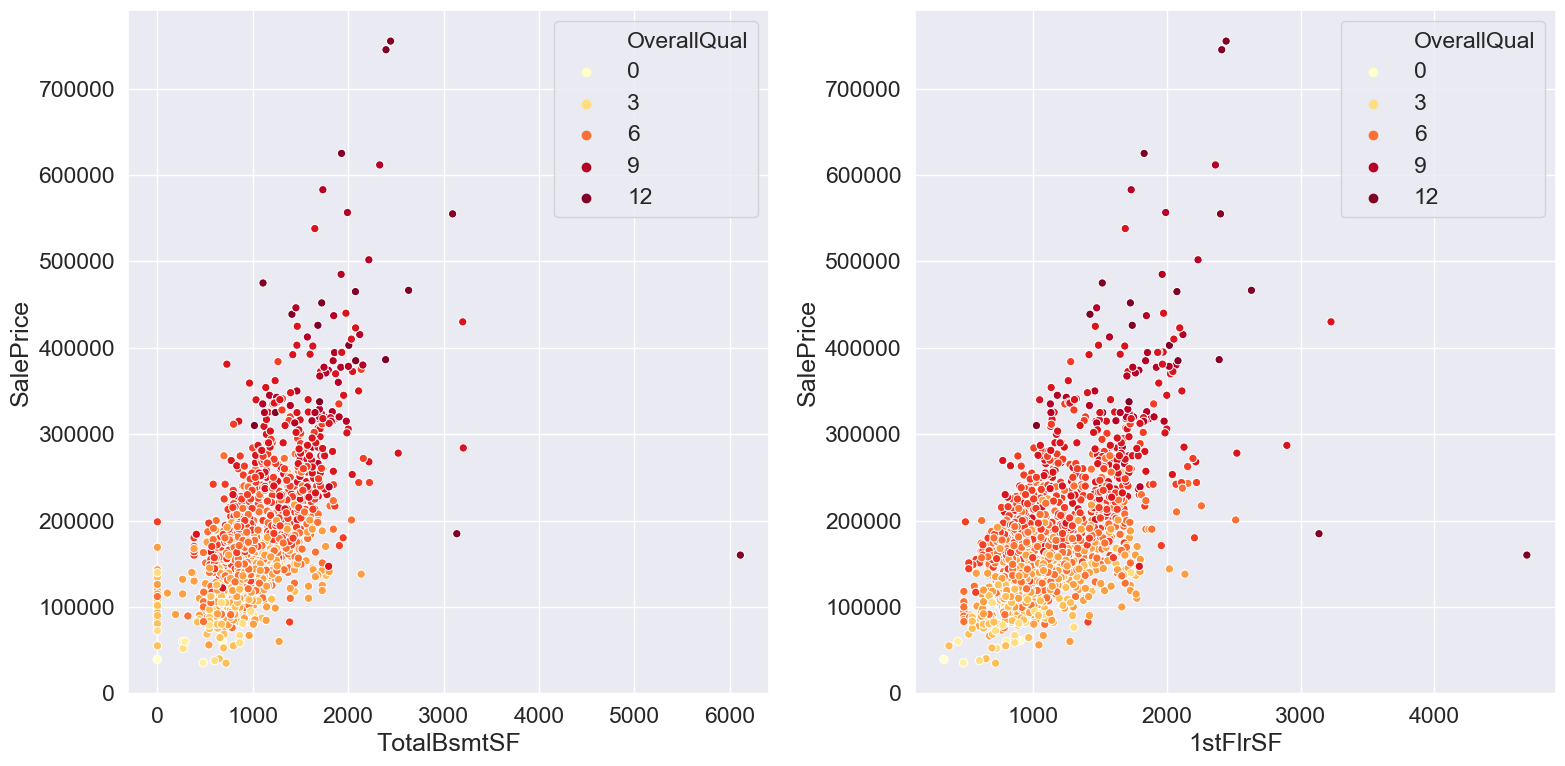

In [631]:
##Segundo: revisamos su relacion con  las otras variables de alta correlacion para evaluar los outliers que detectamos
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

#  Box plot overallqual/salePrice
fig1 = fig.add_subplot(221); sns.boxplot(x='OverallQual', y='SalePrice', data=train[['SalePrice', 'OverallQual']])

#  GrLivArea vs SalePrice plot
fig2 = fig.add_subplot(222); 
sns.scatterplot(x = train.GrLivArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

# GarageCars vs SalePrice plot
fig3 = fig.add_subplot(223); 
sns.scatterplot(x = train.GarageCars, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

#  GarageArea vs SalePrice plot
fig4 = fig.add_subplot(224); 
sns.scatterplot(x = train.GarageArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

# TotalBsmtSF
fig5 = plt.figure(figsize=(16, 8))
fig6 = fig5.add_subplot(121); 
sns.scatterplot(y = train.SalePrice , x = train.TotalBsmtSF, hue=train.OverallQual, palette= 'YlOrRd')

# 1stFlrSF
fig7 = fig5.add_subplot(122); 
sns.scatterplot(y = train.SalePrice, x = train['1stFlrSF'], hue=train.OverallQual, palette= 'YlOrRd')
plt.tight_layout(); plt.show()

In [632]:
##Indentificar los puntos potencialmente outliers...
#GrLivArea
train[(train["GrLivArea"] > 4500) & (train["SalePrice"] < 200000)]
#Ambos puntos tienen bajo precio a pesar de tener la calificacion overalqual maxima...

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
523   60          RL      130.0000      40094    Pave   NaN   IR1      Bnk         AllPub    Inside    Gtl       Edwards      PosN       PosN       1Fam     2Story     10           5            2007       2008          Hip       CompShg  CemntBd     CmentBd     Stone     762.0000     Ex        TA        PConc      Ex       TA       Gd           GLQ          2260        Unf          0           878        3138         GasA    Ex        Y          SBrkr      3138      1538      0             4676       1             0             3         1         3             1             Ex          11            Typ        1           Gd          BuiltIn   2007.0000     Fin          3           884         TA         TA         Y          208         406          0              0          0            0         NaN    NaN   NaN         0        10      2007    New      Partial       184750   
1298  60          RL      313.0000      63887    Pave   NaN   IR3      Bnk         AllPub    Corner    Gtl       Edwards      Feedr      Norm       1Fam     2Story     10           5            2008       2008          Hip       ClyTile  Stucco      Stucco      Stone     796.0000     Ex        TA        PConc      Ex       TA       Gd           GLQ          5644        Unf          0           466        6110         GasA    Ex        Y          SBrkr      4692      950       0             5642       2             0             2         1         3             1             Ex          12            Typ        3           Gd          Attchd    2008.0000     Fin          2           1418        TA         TA         Y          214         292          0              0          0            480       Gd     NaN   NaN         0        1       2008    New      Partial       160000

In [633]:
#Revisar los otros features
train[(train["GarageArea"] > 1400) & (train["SalePrice"] < 200000)]
#Coincide 1298

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
1298  60          RL      313.0000      63887    Pave   NaN   IR3      Bnk         AllPub    Corner    Gtl       Edwards      Feedr      Norm       1Fam     2Story     10           5            2008       2008          Hip       ClyTile  Stucco      Stucco      Stone     796.0000     Ex        TA        PConc      Ex       TA       Gd           GLQ          5644        Unf          0           466        6110         GasA    Ex        Y          SBrkr      4692      950       0             5642       2             0             2         1         3             1             Ex          12            Typ        3           Gd          Attchd    2008.0000     Fin          2           1418        TA         TA         Y          214         292          0              0          0            480       Gd     NaN   NaN         0        1       2008    New      Partial       160000

In [634]:
train[(train["TotalBsmtSF"] > 6000) & (train["SalePrice"] < 200000)]


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
1298  60          RL      313.0000      63887    Pave   NaN   IR3      Bnk         AllPub    Corner    Gtl       Edwards      Feedr      Norm       1Fam     2Story     10           5            2008       2008          Hip       ClyTile  Stucco      Stucco      Stone     796.0000     Ex        TA        PConc      Ex       TA       Gd           GLQ          5644        Unf          0           466        6110         GasA    Ex        Y          SBrkr      4692      950       0             5642       2             0             2         1         3             1             Ex          12            Typ        3           Gd          Attchd    2008.0000     Fin          2           1418        TA         TA         Y          214         292          0              0          0            480       Gd     NaN   NaN         0        1       2008    New      Partial       160000

Correlation of grlivarea after removing outliers: 0.7349681645359327


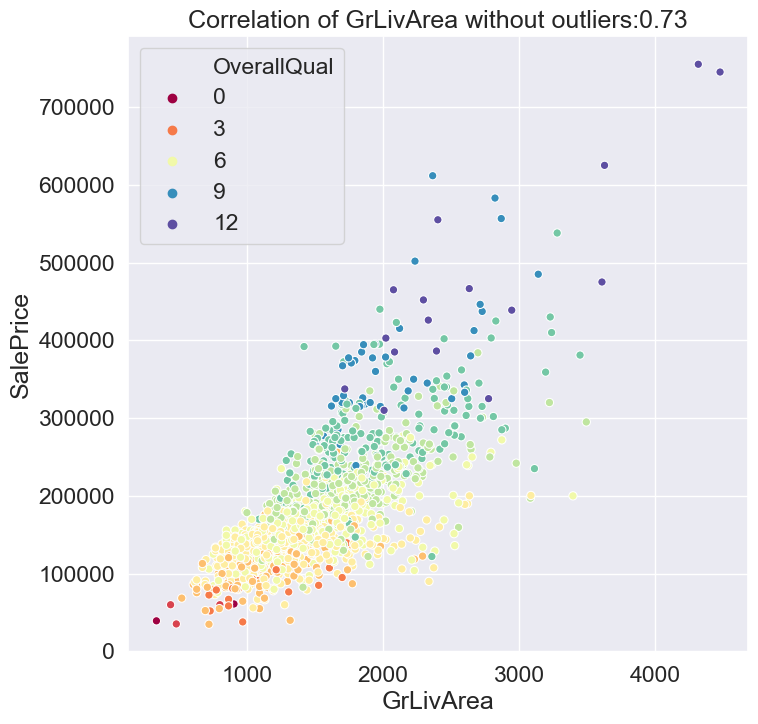

In [635]:
##Puedo eliminar ambos puntos entonces por ser outliers...
train.drop(index = [1298,523], axis = 0, inplace = True)

#Check the GrLivArea without the outliers
fig2 = fig.add_subplot(222); 
sns.scatterplot(x = train.GrLivArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')
plt.title("Correlation of GrLivArea without outliers:{:1.2f}".format(train["GrLivArea"].corr(train["SalePrice"])))

##Mejoró la correlacion de GrLivArea al eliminarse los outliers??
print("Correlation of grlivarea after removing outliers:",train["GrLivArea"].corr(train["SalePrice"]))



GrLivArea         0.7350
TotRmsAbvGrd      0.5378
SalePrice         1.0000
GrLivAreaByRms    0.5505
GrLivArea_x_Rms   0.6772
Name: SalePrice, dtype: float64


GrLivArea  TotRmsAbvGrd  SalePrice  GrLivAreaByRms  GrLivArea_x_Rms
635  3395       14            200000    242.5000         47530

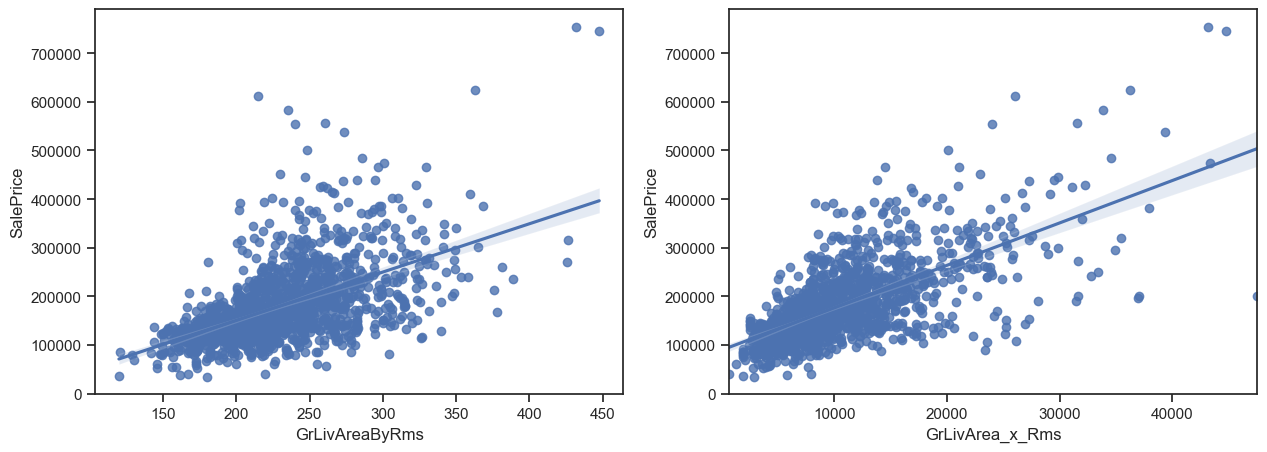

In [636]:
##CREACION DE FEATURES CON MEJOR CORRELACION (BETTER PREDICTORS:

## Creo lista para guardar los nuevos features:
new_features = []

##Creo lista para guardar los features a eliminar
remove_features = []

##GrLivArea y TotRmsAbvGrd
#Creo dos tipos posibles de combinaciones de estos dos features y analizo la corrrlacion con target resultante

t = train[[ 'GrLivArea', 'TotRmsAbvGrd', 'SalePrice']]
t['GrLivAreaByRms'] = train.GrLivArea/train.TotRmsAbvGrd
t['GrLivArea_x_Rms'] = train.GrLivArea*train.TotRmsAbvGrd

#Analizo la correlacion resultante
print(t.corr()["SalePrice"]) #No se mejora la correlacion de griv ni de tot (considerando que ahora la correlacion de griv era de 0.74)

#Graficar para ver si hay algú  outlier que pueda aparecer de estas combinaciones
sns.reset_defaults()
sns.set(style="ticks", color_codes=True)
fig = plt.figure(figsize = (15,5))
fig_1 = fig.add_subplot(121)
sns.regplot( x= 'GrLivAreaByRms', y = "SalePrice", data = t )
fig_ = fig.add_subplot(122)
sns.regplot( x= 'GrLivArea_x_Rms', y = "SalePrice", data = t )

#Aparece otro outlier:

t[(t["GrLivArea_x_Rms"] > 40000) & (t["SalePrice"] < 250000)]



In [637]:
##Eliminamos el outlier
train.drop(index = [635], axis = 0, inplace = True)
train.shape[0] #tamaño despues de eliminar el outlier


#3Conclusion: solo se elimina el outlier pero se mantiene el mismo feature dado que su correlacion no fue superada por ninguna combinacion nueva


1457

In [638]:
##En orden de los mas correlacionados continuamos con GarageArea y GarageCars
#Creo dos tipos posibles de combinaciones de estos dos features y analizo la corrrlacion con target resultante

t = train[[ 'GarageArea', 'GarageCars', 'SalePrice']]
t['GarA/car'] = t["GarageArea"]/t["GarageCars"]
t['GarageArea * GarageCars'] =  t["GarageArea"] * t["GarageCars"]

#Analizo la correlacion resultante
t.corr()["SalePrice"] #No se mejora la correlacion de griv ni de tot (considerando que ahora la correlacion de griv era de 0.74)


##Vemos que Garage area *cars mejor la correlacion de ambos features: 0.68



GarageArea                0.6307 
GarageCars                0.6427 
SalePrice                 1.0000 
GarA/car                  -0.0126
GarageArea * GarageCars   0.6841 
Name: SalePrice, dtype: float64

GarageArea  GarageCars  SalePrice  GarA/car  GarageArea * GarageCars
581   1390        3           253293    463.3333   4170                   
1061  1248        3           81000     416.0000   3744                   
1190  1356        4           168000    339.0000   5424                   
1350  968         4           200000    242.0000   3872

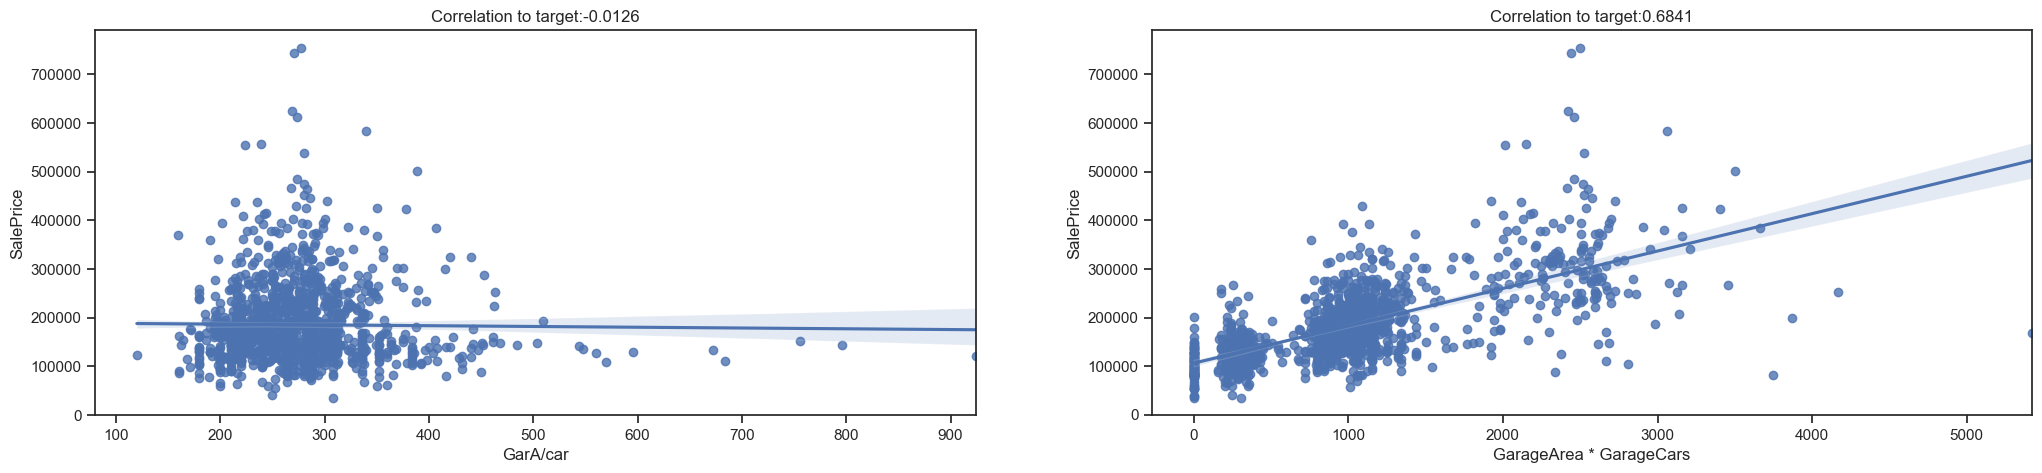

In [639]:
#Graficar para ver si hay algú  outlier que pueda aparecer de estas combinaciones
sns.reset_defaults()
sns.set(style="ticks", color_codes=True)
fig = plt.figure(figsize = (25,5))
fig_1 = fig.add_subplot(121)
sns.regplot( x= 'GarA/car', y = "SalePrice", data = t )
plt.title("Correlation to target:{:1.4f}".format(t["GarA/car"].corr(t["SalePrice"])))
fig_ = fig.add_subplot(122)
sns.regplot( x= 'GarageArea * GarageCars', y = "SalePrice", data = t )
plt.title("Correlation to target:{:1.4f}".format(t["GarageArea * GarageCars"].corr(t["SalePrice"])))

#Aparece otro outlier??
t[t["GarageArea * GarageCars"] > 3700]

In [640]:
#Se gana correlacion eliminando el outlier?
#Si se gana se elimina, si no se mantiene
d = t[t["GarageArea * GarageCars"] < 3700]
d["GarageArea * GarageCars"].corr(d["SalePrice"])

0.7080885960396965

In [641]:
## Como se produce un aumento de 0,68 a 0.70 se eliminan los outliers
#Eliminamos los outliers
train = train[train["GarageArea"] * train["GarageCars"] < 3700] #con eso elimino todos los outliers que aparecieron (4)
train.shape[0]

1453

In [642]:
##Conclusion: se crea un nuevo feature: 'GarageArea * GarageCars' y se eliminan los dos que lo componen

new_features.append('GarageArea * GarageCars')
remove_features.append(["GarageArea", "GarageCars"])


In [643]:
##Continuamos con los siguientes, relacionados con basement
#Creo dos tipos posibles de combinaciones de estos dos features y analizo la corrrlacion con target resultante

t = train[[ 'TotalBsmtSF', '1stFlrSF', 'SalePrice']]
t['TotalBsmt/1stFlrSF'] = t["TotalBsmtSF"]/t["1stFlrSF"]
t['TotalBsmt * 1stFlrSF'] =  t["TotalBsmtSF"] * t["1stFlrSF"]

#Analizo la correlacion resultante
t.corr()["SalePrice"] #


##Vemos que la multiplicacion genera una mejor correlacion de ambos features: 0.68


TotalBsmtSF            0.6513
1stFlrSF               0.6318
SalePrice              1.0000
TotalBsmt/1stFlrSF     0.1986
TotalBsmt * 1stFlrSF   0.6838
Name: SalePrice, dtype: float64

0.6864123500742738

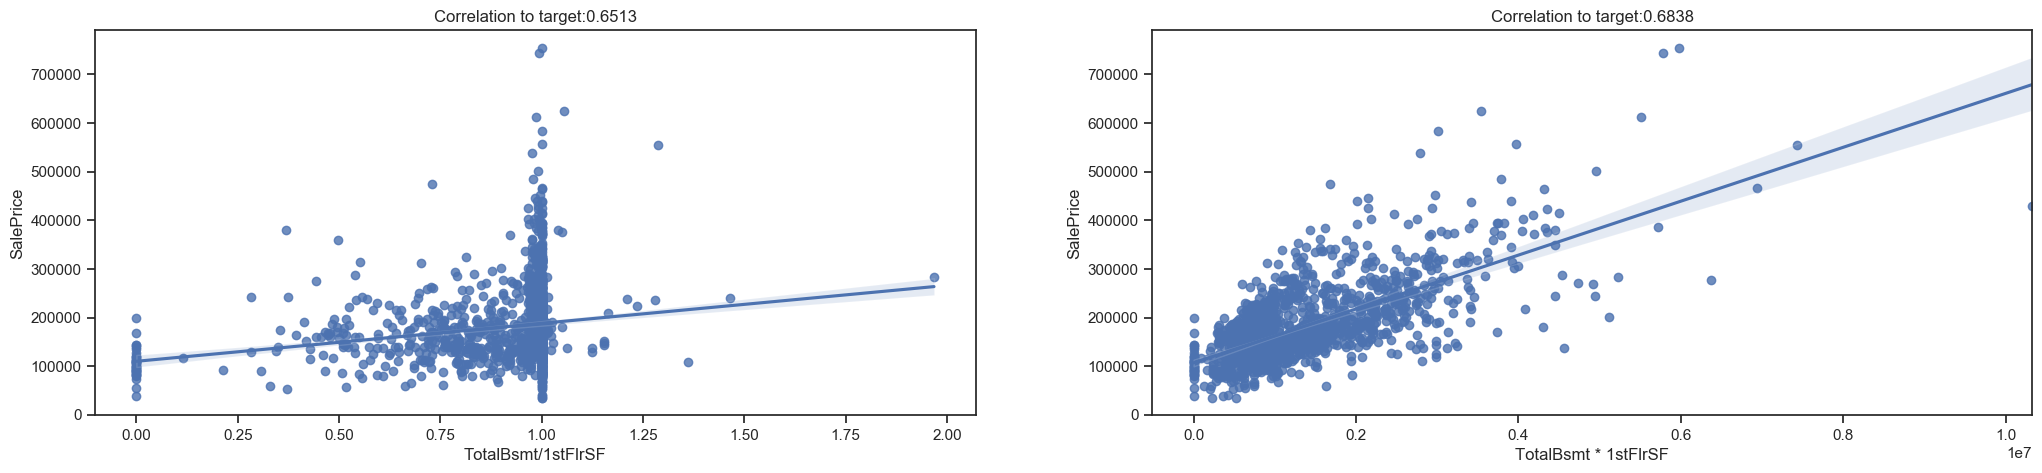

In [644]:
#Graficar para ver si hay algú  outlier que pueda aparecer de estas combinaciones
sns.reset_defaults()
sns.set(style="ticks", color_codes=True)
fig = plt.figure(figsize = (25,5))
fig_1 = fig.add_subplot(121)
sns.regplot( x= "TotalBsmt/1stFlrSF", y = "SalePrice", data = t )
plt.title("Correlation to target:{:1.4f}".format(t["TotalBsmtSF"].corr(t["SalePrice"])))
fig_ = fig.add_subplot(122)
sns.regplot( x= 'TotalBsmt * 1stFlrSF', y = "SalePrice", data = t )
plt.title("Correlation to target:{:1.4f}".format(t["TotalBsmt * 1stFlrSF"].corr(t["SalePrice"])))

#Aparece otro outlier??
t[t["TotalBsmt * 1stFlrSF"] > 10000000]

#Se gana correlacion eliminando el outlier?
#Si se gana se elimina, si no se mantiene
d = t[t["TotalBsmt * 1stFlrSF"] < 10000000]
d["TotalBsmt * 1stFlrSF"].corr(d["SalePrice"])


In [645]:
##Conclusion: no se gana mucha correlacion, de manera que no se elimina el outlier. Se crea un nuevo feature: "TotalBsmt * 1stFlrSF" y se eliminan los dos originales
new_features.append("TotalBsmt * 1stFlrSF")
remove_features.append(["TotalBsmt","1stFlrSF"])


In [646]:
new_features


['GarageArea * GarageCars', 'TotalBsmt * 1stFlrSF']

In [647]:
##Continuamos con YearBuilt y YearRemodAdd
#Creo dos tipos posibles de combinaciones de estos dos features y analizo la corrrlacion con target resultante

t = train[[ 'YearBuilt', 'YearRemodAdd',"GarageYrBlt", 'SalePrice']]
t['YearBuilt/YearRemodAdd'] = t["YearBuilt"]/t["YearRemodAdd"]
t['YearBuilt * YearRemodAdd'] =  t["YearBuilt"] * t["YearRemodAdd"]
t['YearBuilt * GarageYrBlt'] =  t["YearBuilt"] * t["GarageYrBlt"] #También examino esta posibilidad

#Analizo la correlacion resultante
t.corr()["SalePrice"] #


##Vemos que la multiplicacion de los años genera una mejor correlacion de ambos features: 0.5773

YearBuilt                  0.5238
YearRemodAdd               0.5069
GarageYrBlt                0.4878
SalePrice                  1.0000
YearBuilt/YearRemodAdd     0.2202
YearBuilt * YearRemodAdd   0.5773
YearBuilt * GarageYrBlt    0.5230
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'Correlation to target:0.5773')

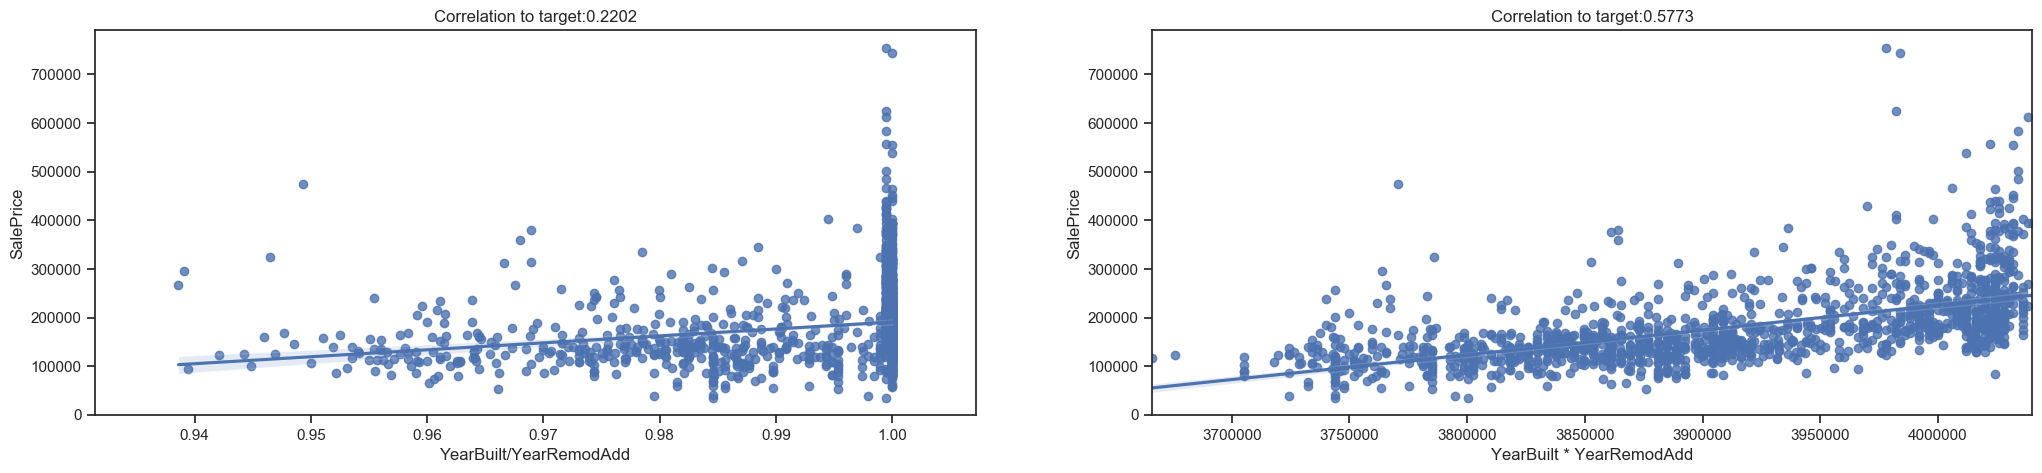

In [648]:
#Graficar para ver si hay algún  outlier que pueda aparecer de estas combinaciones
sns.reset_defaults()
sns.set(style="ticks", color_codes=True)
fig = plt.figure(figsize = (25,5))
fig_1 = fig.add_subplot(121)
sns.regplot( x= "YearBuilt/YearRemodAdd", y = "SalePrice", data = t )
plt.title("Correlation to target:{:1.4f}".format(t['YearBuilt/YearRemodAdd'].corr(t["SalePrice"])))
fig_ = fig.add_subplot(122)
sns.regplot( x= 'YearBuilt * YearRemodAdd', y = "SalePrice", data = t )
plt.title("Correlation to target:{:1.4f}".format(t["YearBuilt * YearRemodAdd"].corr(t["SalePrice"])))



In [649]:
#Aparece otro outlier?? revismos los dos de arriba
train[(train["YearBuilt"]* train["YearRemodAdd"] > 395000) & (train["SalePrice"] > 700000)]



MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
691   60          RL      104.0000      21535    Pave   NaN   IR1      Lvl         AllPub    Corner    Gtl       NoRidge      Norm       Norm       1Fam     2Story     10           6            1994       1995          Gable     WdShngl  HdBoard     HdBoard     BrkFace   1170.0000    Ex        TA        PConc      Ex       TA       Gd           GLQ          1455        Unf          0           989        2444         GasA    Ex        Y          SBrkr      2444      1872      0             4316       0             1             3         1         4             1             Ex          10            Typ        2           Ex          Attchd    1994.0000     Fin          3           832         TA         TA         Y          382         50           0              0          0            0         NaN    NaN    NaN         0        1       2007    WD       Normal        755000   
1182  60          RL      160.0000      15623    Pave   NaN   IR1      Lvl         AllPub    Corner    Gtl       NoRidge      Norm       Norm       1Fam     2Story     10           5            1996       1996          Hip       CompShg  Wd Sdng     ImStucc     None      0.0000       Gd        TA        PConc      Ex       TA       Av           GLQ          2096        Unf          0           300        2396         GasA    Ex        Y          SBrkr      2411      2065      0             4476       1             0             3         1         4             1             Ex          10            Typ        2           TA          Attchd    1996.0000     Fin          3           813         TA         TA         Y          171         78           0              0          0            555       Ex     MnPrv  NaN         0        7       2007    WD       Abnorml       745000

In [650]:
#No parecen ser outliers
#Conclusion: se agrega "YearBuilt * "YearRemodAdd" como nuevo feature y se eliminan los dos que lo componen
new_features.append( "YearBuilt * YearRemodAdd")
remove_features.append(["YearBuilt","YearRemodAdd"])
new_features

['GarageArea * GarageCars', 'TotalBsmt * 1stFlrSF', 'YearBuilt * YearRemodAdd']

In [651]:
##Continuamos con FullBath

# BsmtFullBath: Basement full bathrooms

# BsmtHalfBath: Basement half bathrooms

# FullBath: Full bathrooms above grade

# HalfBath: Half baths above grade


#Creemos y experimentemos con nuevos features
t = train[[ 'BsmtFullBath', 'BsmtHalfBath',"FullBath", 'HalfBath', "SalePrice"]]
t['Total_Bath'] = t["FullBath"] + 0.5 * t["HalfBath"] 
t['Total_Bsmt_Bath'] = t["BsmtFullBath"] + 0.5 * t["BsmtHalfBath"] 
t["TotalBathrooms"] = t["FullBath"] + 0.5 * t["HalfBath"] + t["BsmtFullBath"] + 0.5 * t["BsmtHalfBath"] 

#Analizo la correlacion resultante
t.corr()["SalePrice"] #


##Vemos que  de las dos fórmulas la que da mejor correlacion es Totalbathrooms, con 0.63, lo cual es una mejora

BsmtFullBath      0.2289 
BsmtHalfBath      -0.0177
FullBath          0.5617 
HalfBath          0.2843 
SalePrice         1.0000 
Total_Bath        0.5999 
Total_Bsmt_Bath   0.2268 
TotalBathrooms    0.6369 
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'Correlation to target:0.6369')

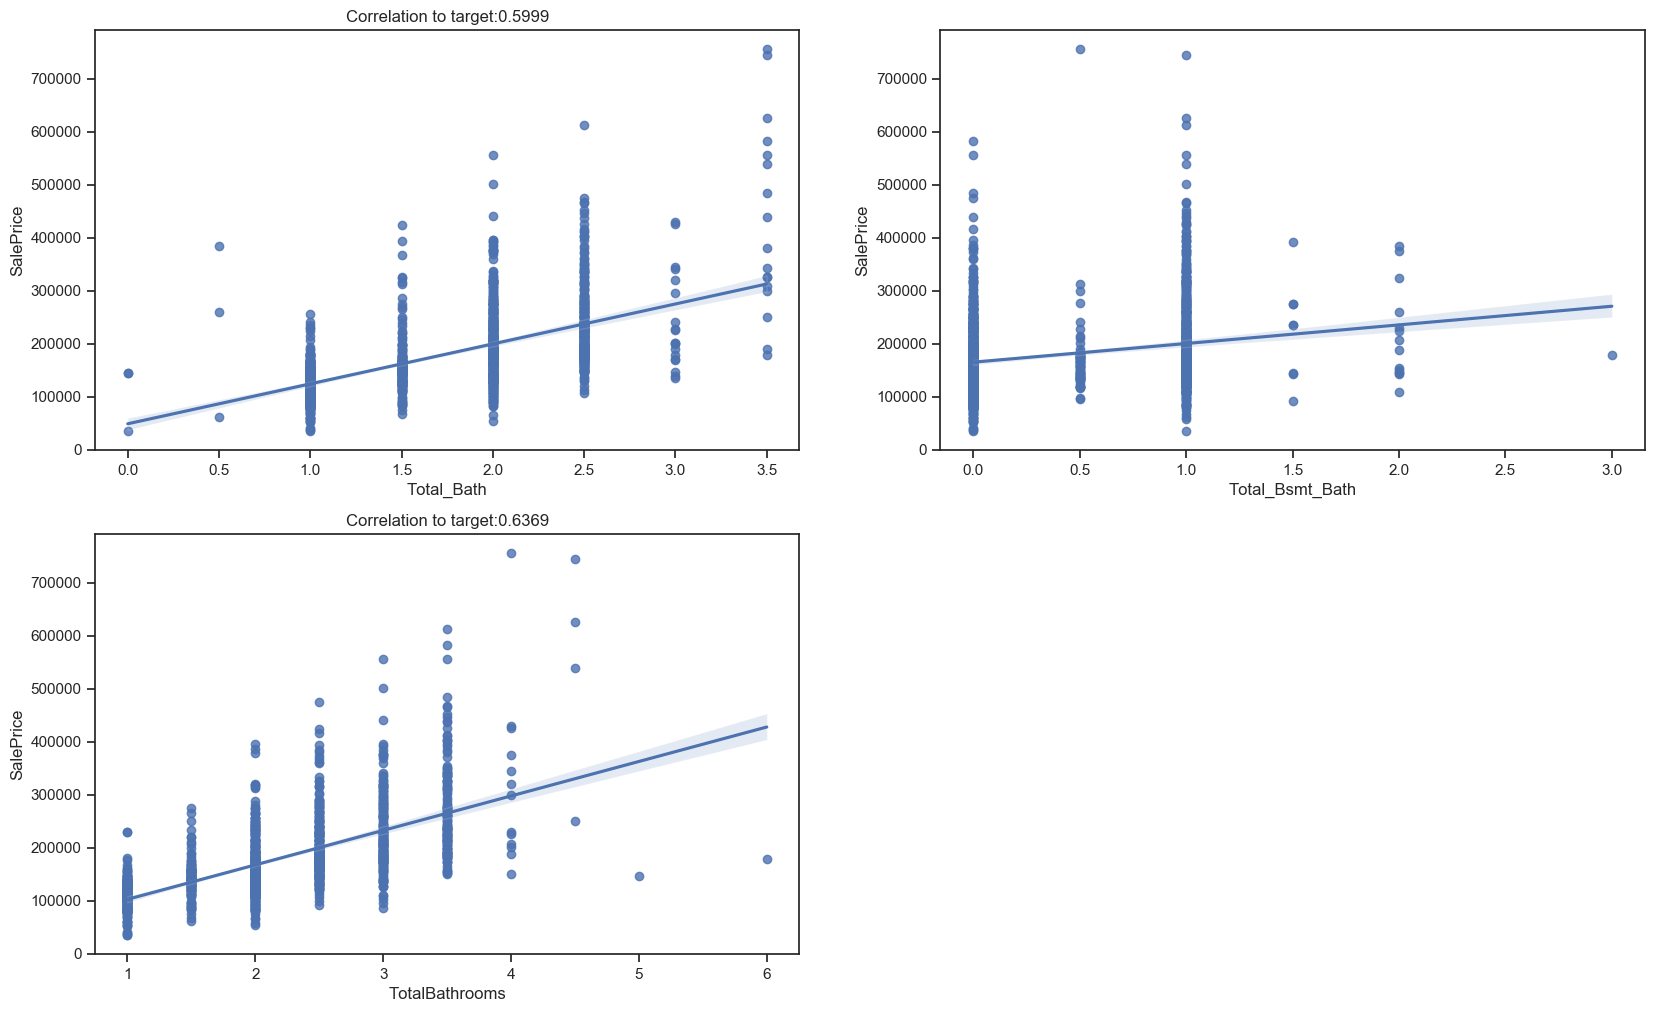

In [652]:
#Graficar para ver si hay algún  outlier que pueda aparecer de estas combinaciones
sns.reset_defaults()
sns.set(style="ticks", color_codes=True)
fig = plt.figure(figsize = (20,12))
fig_1 = fig.add_subplot(221)
sns.regplot( x= "Total_Bath", y = "SalePrice", data = t )
plt.title("Correlation to target:{:1.4f}".format(t['Total_Bath'].corr(t["SalePrice"])))
fig_2 = fig.add_subplot(222)
sns.regplot( x= 'Total_Bsmt_Bath', y = "SalePrice", data = t )
fig_3 = fig.add_subplot(223)
sns.regplot( x= 'TotalBathrooms', y = "SalePrice", data = t )
plt.title("Correlation to target:{:1.4f}".format(t["TotalBathrooms"].corr(t["SalePrice"])))



In [653]:
#Aparece otro outlier?? revismos los dos de arriba
t[t["TotalBathrooms"] > 4.7]

BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  SalePrice  Total_Bath  Total_Bsmt_Bath  TotalBathrooms
738  3             0             3         0         179000    3.0000      3.0000           6.0000         
921  2             0             2         2         145900    3.0000      2.0000           5.0000

In [654]:
#Ubico sus indices para ver qué pasa en train
train.loc[[738,921],  :]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
738  90          RL      60.0000       10800    Pave   NaN   Reg      Lvl         AllPub    Inside    Gtl       Edwards      Norm       Norm       Duplex   1Story     5            5            1987       1988          Gable     CompShg  Plywood     Plywood     None      0.0000       TA        TA        CBlock     Gd       Gd       Gd           GLQ          1200        Unf          0           0          1200         GasA    TA        Y          SBrkr      1200      0         0             1200       3             0             3         0         3             1             TA          5             Typ        0           NaN         NaN       nan           NaN          0           0           NaN        NaN        Y          120         0            0              0          0            0         NaN    NaN    NaN         0        3       2009    WD       Alloca        179000   
921  90          RL      67.0000       8777     Pave   NaN   Reg      Lvl         AllPub    Inside    Gtl       Edwards      Feedr      Norm       Duplex   1.5Fin     5            7            1900       2003          Gable     CompShg  MetalSd     MetalSd     None      0.0000       TA        TA        CBlock     TA       TA       No           ALQ          1084        Unf          0           188        1272         GasA    Gd        Y          SBrkr      1272      928       0             2200       2             0             2         2         4             2             TA          9             Typ        0           NaN         NaN       nan           NaN          0           0           NaN        NaN        N          0           70           0              0          0            0         NaN    GdPrv  NaN         0        9       2008    WD       Normal        145900

In [655]:
#Se gana correlacion eliminando los outliers?
#Si se gana se elimina, si no se mantiene
d = t[t["TotalBathrooms"] < 4.7]
d["TotalBathrooms"].corr(d["SalePrice"])

0.6462853769575145

In [656]:
#La correlacion mejora. Se eliminan:
train = train[(train["FullBath"] + 0.5 * train["HalfBath"] + train["BsmtFullBath"] + 0.5 * train["BsmtHalfBath"] ) < 4.7]
train.shape[0]

1451

In [657]:
##Conclusion: se eliminan los 2 outliers y se incropora el nuevo feature totalbathrooms, eliminando todos los otros:
remove_features.append(['BsmtFullBath', 'BsmtHalfBath',"FullBath", 'HalfBath'])
new_features.append("TotalBathrooms")

In [658]:
remove_features

[['GarageArea', 'GarageCars'],
 ['TotalBsmt', '1stFlrSF'],
 ['YearBuilt', 'YearRemodAdd'],
 ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']]

In [659]:
##Continuamos analizando Porch
porch_cols = train.filter(like='orch', axis=1).columns
porch_cols #todos estos features aluden a superficie de este tipo de porches que tiene cada casa. Algunos tienen más de uno
list(porch_cols)

['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

In [660]:
#Se les agrega woodeck
#Creemos y experimentemos con nuevos features
t = train[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch','WoodDeckSF', "SalePrice"]]
# t['Total_Bath'] = t["FullBath"] + 0.5 * t["HalfBath"] 
# t['Total_Bsmt_Bath'] = t["BsmtFullBath"] + 0.5 * t["BsmtHalfBath"] 
t["TotalPorch"] = t["OpenPorchSF"] + t['EnclosedPorch']+ t['3SsnPorch'] + t['ScreenPorch'] + t['WoodDeckSF'] #sumamos para analizar la superficie total de porch

#Analizo la correlacion resultante
t.corr()["SalePrice"] #


##Vemos que  de las dos fórmulas la que da mejor correlacion es Total, con 0.39, lo cual es una mejora

OpenPorchSF     0.3210 
EnclosedPorch   -0.1289
3SsnPorch       0.0446 
ScreenPorch     0.1114 
WoodDeckSF      0.3264 
SalePrice       1.0000 
TotalPorch      0.3938 
Name: SalePrice, dtype: float64

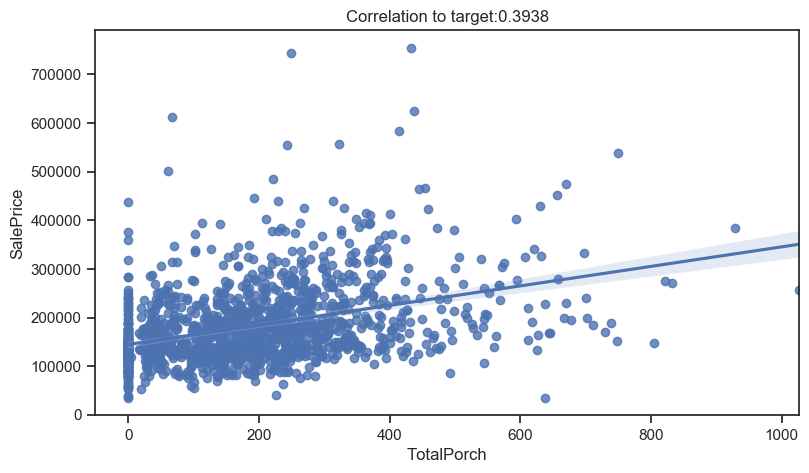

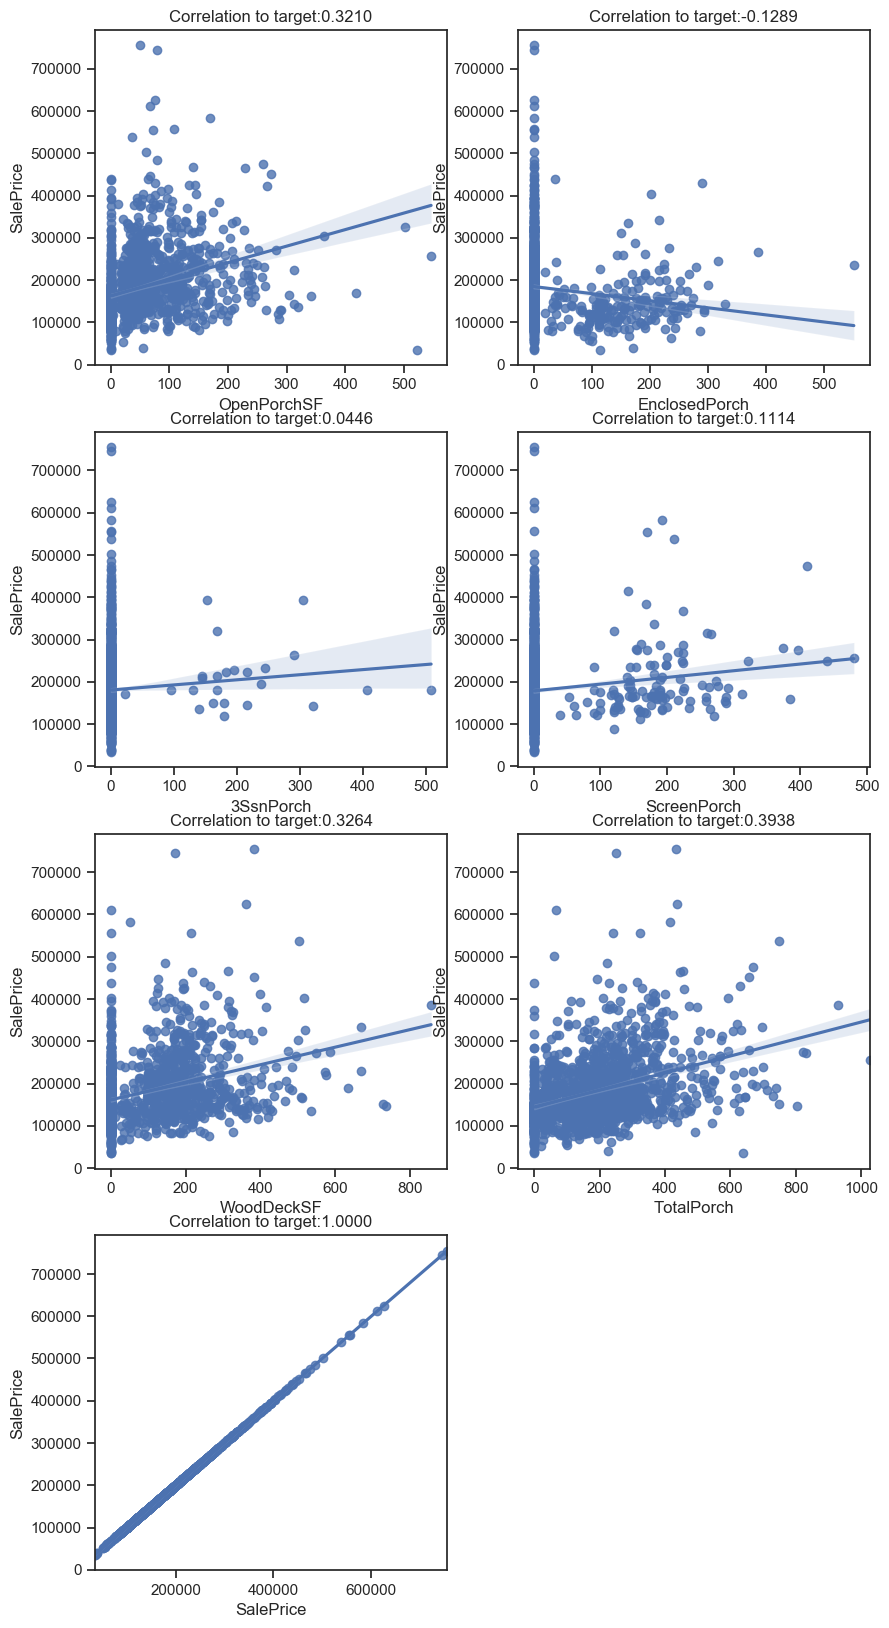

In [661]:
#Graficar para ver si hay algún  outlier que pueda aparecer de estas combinaciones
#t["TotalPorch"] = np.log1p(t["TotalPorch"])
sns.reset_defaults()
sns.set(style="ticks", color_codes=True)
fig = plt.figure(figsize = (20,5))
fig_1 = fig.add_subplot(121)
sns.regplot( x= 'TotalPorch', y = "SalePrice", data = t )
plt.title("Correlation to target:{:1.4f}".format(t["TotalPorch"].corr(t["SalePrice"])))

def plot_vars(cols, t, target):
    sns.reset_defaults()
    sns.set(style="ticks", color_codes=True)
    fig = plt.figure(figsize = (10,20))
    i = 1
    for col in cols:
        fig_i= fig.add_subplot(420 + i)
        sns.regplot( x= col, y = target, data = t )
        plt.title("Correlation to target:{:1.4f}".format(t[col].corr(t[target])))
        i +=1
        
cols = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch','WoodDeckSF',"TotalPorch", "SalePrice"]
plot_vars(cols, t, "SalePrice")

In [662]:
#Conclusion: TotalPorch tiene una mayor correlacion, por lo que se agrega. Sin embargo hay que tenr cuidado porque se ve graficamente que tiene una alta varianza
##lo que puede llevar a complex models or overfitting...

new_features.append("TotalPorch")
remove_features += ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch','WoodDeckSF']


###PAUSA PARA LEER AQUI EL WILEY Y ENTRENARSE EN LEER MEJOR SCATTERPLOTS E INDETIFICAR COMPORTAMIENTOS (VARIANZAS, ETC)


In [663]:
#Continuamos
sum

Dtype  Uniques  Nulls  % Nulls    Skew  Kurtosis  Correlation
SalePrice      int64    663      0     0.0000   1.8830  6.5360    1.0000      
OverallQual    int64    10       0     0.0000   0.2170  0.0960    0.7910      
GrLivArea      int64    861      0     0.0000   1.3670  4.8950    0.7090      
GarageCars     int64    5        0     0.0000   -0.3430 0.2210    0.6400      
GarageArea     int64    441      0     0.0000   0.1800  0.9170    0.6230      
TotalBsmtSF    int64    721      0     0.0000   1.5240  13.2500   0.6140      
1stFlrSF       int64    753      0     0.0000   1.3770  5.7460    0.6060      
FullBath       int64    4        0     0.0000   0.0370  -0.8570   0.5610      
TotRmsAbvGrd   int64    12       0     0.0000   0.6760  0.8810    0.5340      
YearBuilt      int64    112      0     0.0000   -0.6130 -0.4400   0.5230      
YearRemodAdd   int64    61       0     0.0000   -0.5040 -1.2720   0.5070      
GarageYrBlt    float64  97       81    0.0600   -0.6490 -0.4180   0.4860      
MasVnrArea     float64  327      8     0.0100   2.6690  10.0820   0.4770      
Fireplaces     int64    4        0     0.0000   0.6500  -0.2170   0.4670      
BsmtFinSF1     int64    637      0     0.0000   1.6860  11.1180   0.3860      
LotFrontage    float64  110      259   0.1800   2.1640  17.4530   0.3520      
WoodDeckSF     int64    274      0     0.0000   1.5410  2.9930    0.3240      
2ndFlrSF       int64    417      0     0.0000   0.8130  -0.5530   0.3190      
OpenPorchSF    int64    202      0     0.0000   2.3640  8.4900    0.3160      
HalfBath       int64    3        0     0.0000   0.6760  -1.0770   0.2840      
LotArea        int64    1073     0     0.0000   12.2080 203.2430  0.2640      
BsmtFullBath   int64    4        0     0.0000   0.5960  -0.8390   0.2270      
BsmtUnfSF      int64    780      0     0.0000   0.9200  0.4750    0.2140      
BedroomAbvGr   int64    8        0     0.0000   0.2120  2.2310    0.1680      
ScreenPorch    int64    76       0     0.0000   4.1220  18.4390   0.1110      
PoolArea       int64    8        0     0.0000   14.8280 223.2680  0.0920      
MoSold         int64    12       0     0.0000   0.2120  -0.4040   0.0460      
3SsnPorch      int64    20       0     0.0000   10.3040 123.6620  0.0450      
BsmtFinSF2     int64    144      0     0.0000   4.2550  20.1130   -0.0110     
BsmtHalfBath   int64    3        0     0.0000   4.1030  16.3970   -0.0170     
MiscVal        int64    21       0     0.0000   24.4770 701.0030  -0.0210     
LowQualFinSF   int64    24       0     0.0000   9.0110  83.2350   -0.0260     
YrSold         int64    5        0     0.0000   0.0960  -1.1910   -0.0290     
OverallCond    int64    9        0     0.0000   0.6930  1.1060    -0.0780     
MSSubClass     int64    15       0     0.0000   1.4080  1.5800    -0.0840     
EnclosedPorch  int64    120      0     0.0000   3.0900  10.4310   -0.1290     
KitchenAbvGr   int64    4        0     0.0000   4.4880  21.5320   -0.1360     
BsmtQual       object   4        37    0.0300   nan     nan       nan         
GarageFinish   object   3        81    0.0600   nan     nan       nan         
Neighborhood   object   25       0     0.0000   nan     nan       nan         
LandSlope      object   3        0     0.0000   nan     nan       nan         
GarageQual     object   5        81    0.0600   nan     nan       nan         
GarageCond     object   5        81    0.0600   nan     nan       nan         
PavedDrive     object   3        0     0.0000   nan     nan       nan         
Utilities      object   2        0     0.0000   nan     nan       nan         
LandContour    object   4        0     0.0000   nan     nan       nan         
LotShape       object   4        0     0.0000   nan     nan       nan         
Alley          object   2        1369  0.9400   nan     nan       nan         
Street         object   2        0     0.0000   nan     nan       nan         
PoolQC         object   3        1453  1.0000   nan     nan       n

In [664]:
###A continuacion se analizan los features relacionados con las dimensiones y similares

# LotArea: Lot size in square feet
    
# LotShape: General shape of property

#        Reg	Regular	
#        IR1	Slightly irregular
#        IR2	Moderately Irregular
#        IR3	Irregular
       
# LandContour: Flatness of the property

#        Lvl	Near Flat/Level	
#        Bnk	Banked - Quick and significant rise from street grade to building
#        HLS	Hillside - Significant slope from side to side
#        Low	Depression

	
# LotConfig: Lot configuration

#        Inside	Inside lot
#        Corner	Corner lot
#        CulDSac	Cul-de-sac dead end...
#        FR2	Frontage on 2 sides of property
#        FR3	Frontage on 3 sides of property
	
# LandSlope: Slope of property
		
#        Gtl	Gentle slope
#        Mod	Moderate Slope	
#        Sev	Severe Slope

In [665]:
cols_cont = [ "LandContour", "LotConfig"]
t = train[["LotArea", "LotShape", "LandContour", "LotConfig", "LandSlope", "SalePrice"]]

def ordinal_encode(data):
    oe = OrdinalEncoder()
    oe.fit(data)
    data_ordinal = oe.transform(data)
    return data_ordinal

# Se crea una ecoding especial para landslope y lotshape
landslope = {}
landslope["Gtl"] = 3
landslope["Mod"] = 2
landslope["Sev"] = 1

lotshape = {}

lotshape["Reg"] = 4
lotshape["IR1"] = 3
lotshape["IR2"] = 2
lotshape["IR3"] = 1


t["LotShape"] = t["LotShape"].map(lotshape)
t["LandSlope"] = t["LandSlope"].map(landslope)


t[cols_cont] = ordinal_encode(t[cols_cont])
t.head(2)
t.corr()["SalePrice"]

LotArea       0.2696 
LotShape      -0.2708
LandContour   0.0146 
LotConfig     -0.0678
LandSlope     -0.0517
SalePrice     1.0000 
Name: SalePrice, dtype: float64

In [666]:
##Creamos intentos de new features
t["Area*Shape*Slope"] = t["LotArea"] * t["LotShape"] * t["LandSlope"]
t["Area*Slope"] = t["LotArea"] * t["LandSlope"]

#testing correlations...
t.corr()["SalePrice"]


LotArea            0.2696 
LotShape           -0.2708
LandContour        0.0146 
LotConfig          -0.0678
LandSlope          -0.0517
SalePrice          1.0000 
Area*Shape*Slope   0.3197 
Area*Slope         0.3976 
Name: SalePrice, dtype: float64

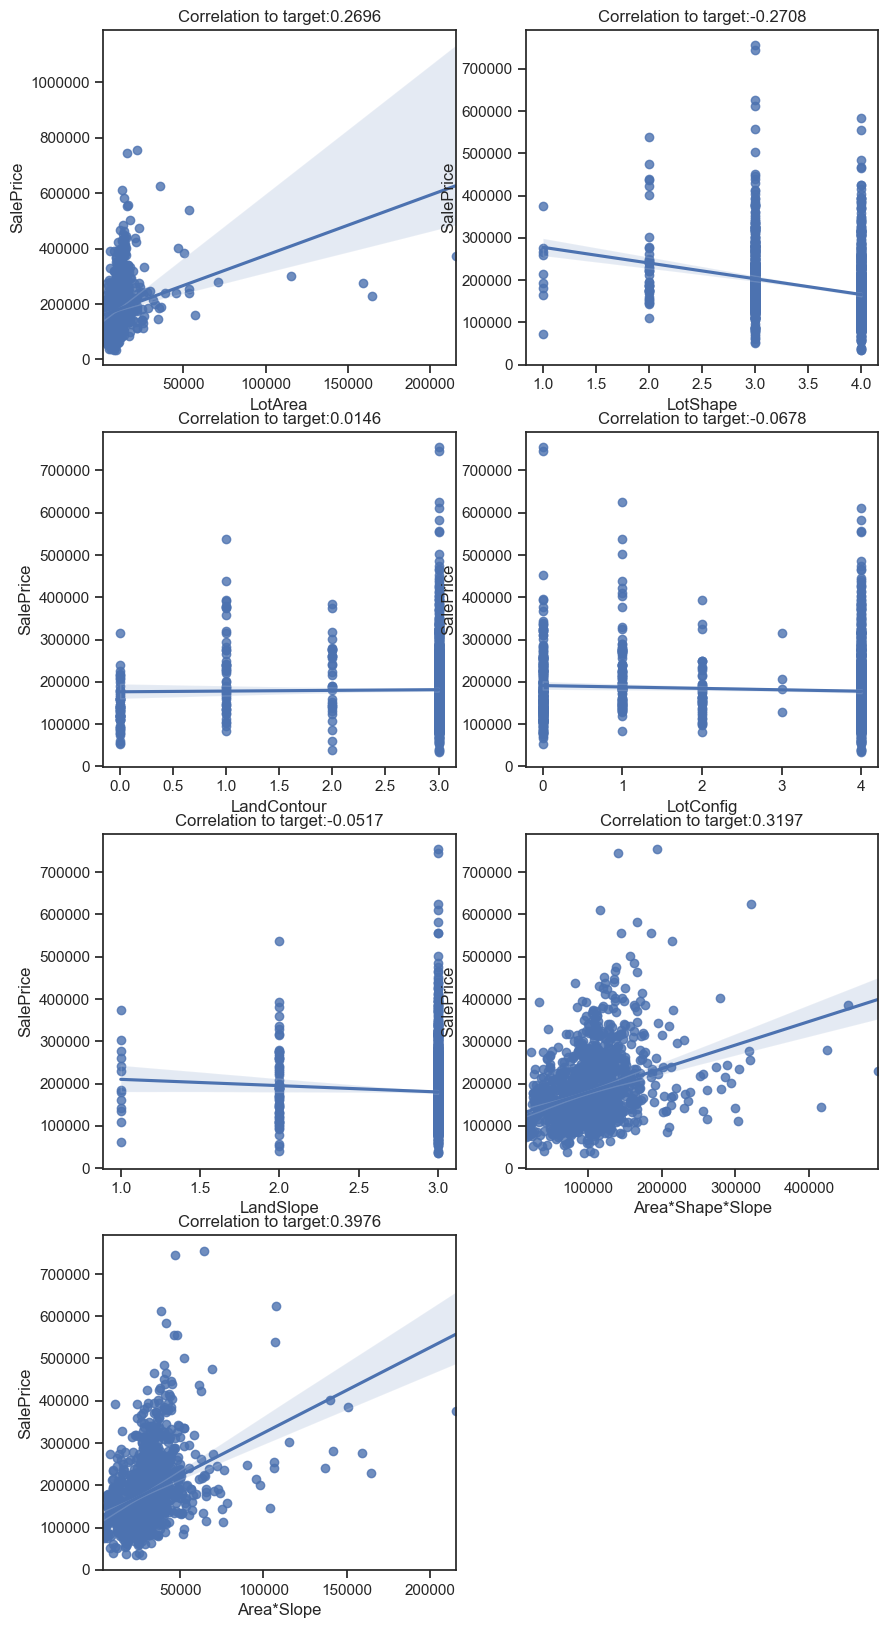

In [667]:
plot_vars(cols  = ["LotArea", "LotShape", "LandContour", "LotConfig", "LandSlope", "Area*Shape*Slope", "Area*Slope"], t = t, target = "SalePrice" )

In [668]:
t.columns

Index(['LotArea', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'SalePrice', 'Area*Shape*Slope', 'Area*Slope'],
      dtype='object')

Text(0.5, 1.0, 'Correlation to target:0.3976')

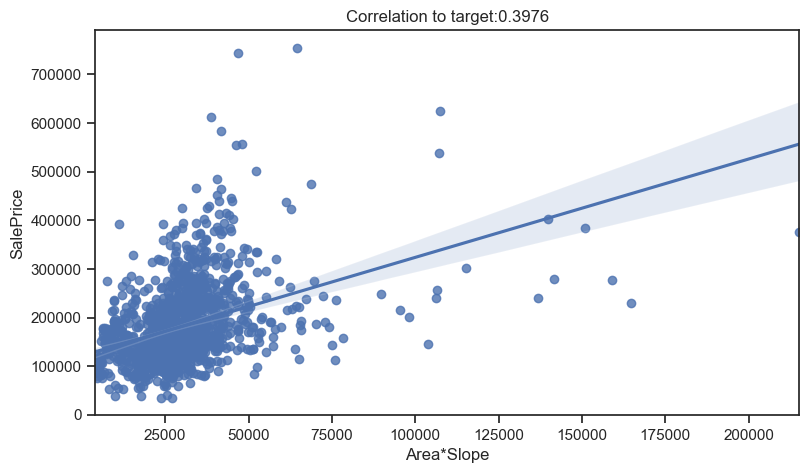

In [669]:
#Se ve que Area*Slope genera una correlacion mas alta que la de LotArea sola (.397)

#Veamos si hay outliers
#Se supone que hay 3, voy a mirar de cerca...
sns.reset_defaults()
sns.set(style="ticks", color_codes=True)
fig = plt.figure(figsize = (20,5))
fig_1 = fig.add_subplot(121)
sns.regplot( x= "Area*Slope", y = "SalePrice", data = t )
plt.title("Correlation to target:{:1.4f}".format(t["Area*Slope"].corr(t["SalePrice"])))



Text(0.5, 1.0, 'Correlation to target:0.4106')

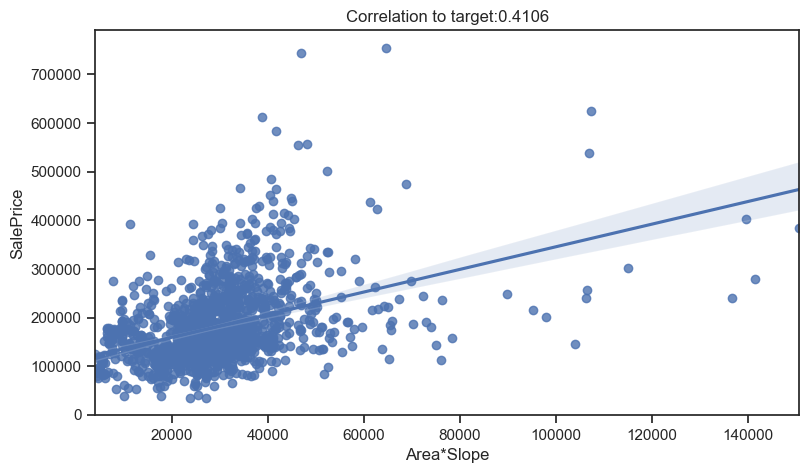

In [670]:
#Se ven 3 que estaban ya en el plot de LotArea

#Mejora la correlacion si los elimino?

d = t[t["Area*Slope"] < 155000]

sns.reset_defaults()
sns.set(style="ticks", color_codes=True)
fig = plt.figure(figsize = (20,5))
fig_1 = fig.add_subplot(121)
sns.regplot( x= "Area*Slope", y = "SalePrice", data = d )
plt.title("Correlation to target:{:1.4f}".format(d["Area*Slope"].corr(t["SalePrice"])))
   
#La correlacion aumenta a .4106


In [671]:
#Conclusion:
#Se agrega nuevo feature y se eliminan los dos que lo conforman
#Se eliminan los outliers que aparecieron
new_features.append("Area*Slope")
remove_features += ["LotArea","LandSlope"]

train = train[train["LotArea"] < 155000]
train.shape[0]


1448

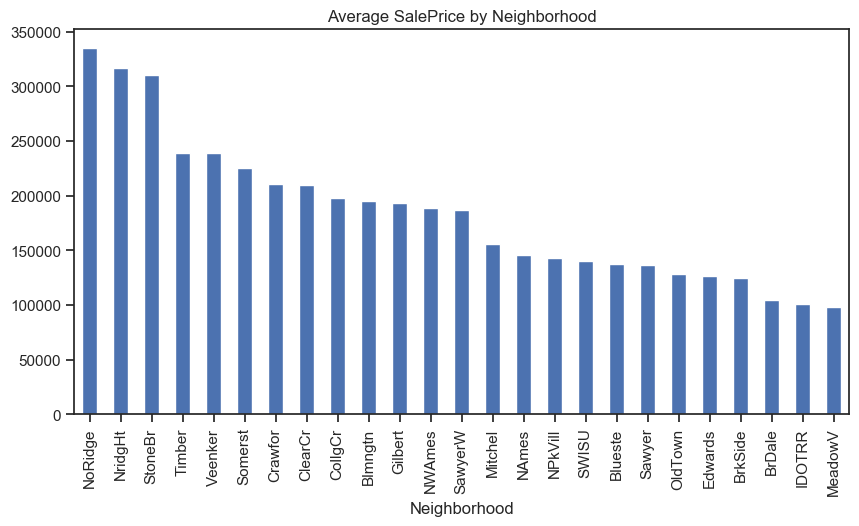

In [672]:
###Continuamos analizando neighborhood para ver cuanto influye en el precio
#Como es una var categiorica hay que analizarla de otra forma

#Precios promedio por vecindario
#Cantifdad de casa vendidas por vecindario

av_prices = train.groupby("Neighborhood")["SalePrice"].mean().sort_values(ascending = False)
av_prices.plot.bar(title = "Average SalePrice by Neighborhood", figsize = (10,5))

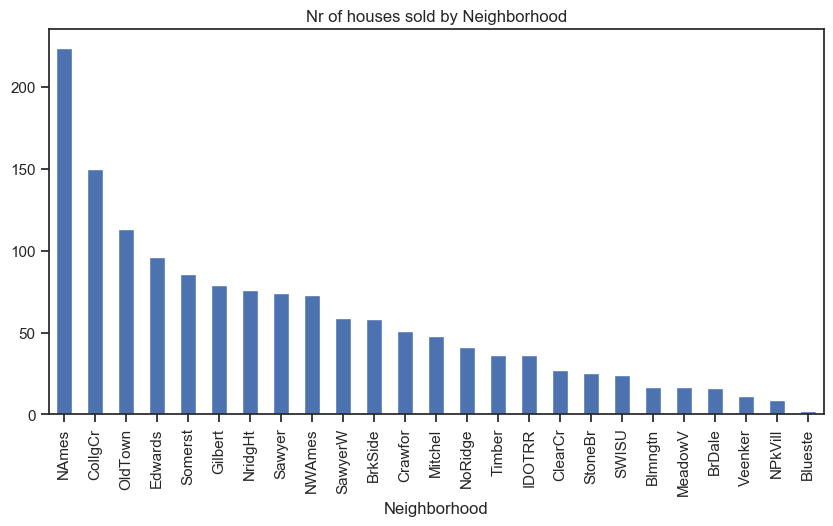

In [673]:
sold_neigh = train.groupby("Neighborhood").size().sort_values(ascending = False)
sold_neigh.plot.bar(title = "Nr of houses sold by Neighborhood", figsize = (10,5))

In [674]:
train["Neighborhood"].value_counts()/train["Neighborhood"].shape[0]

NAmes     0.1547
CollgCr   0.1036
OldTown   0.0780
Edwards   0.0663
Somerst   0.0594
Gilbert   0.0546
NridgHt   0.0525
Sawyer    0.0511
NWAmes    0.0504
SawyerW   0.0407
BrkSide   0.0401
Crawfor   0.0352
Mitchel   0.0331
NoRidge   0.0283
IDOTRR    0.0249
Timber    0.0249
ClearCr   0.0186
StoneBr   0.0173
SWISU     0.0166
Blmngtn   0.0117
MeadowV   0.0117
BrDale    0.0110
Veenker   0.0076
NPkVill   0.0062
Blueste   0.0014
Name: Neighborhood, dtype: float64

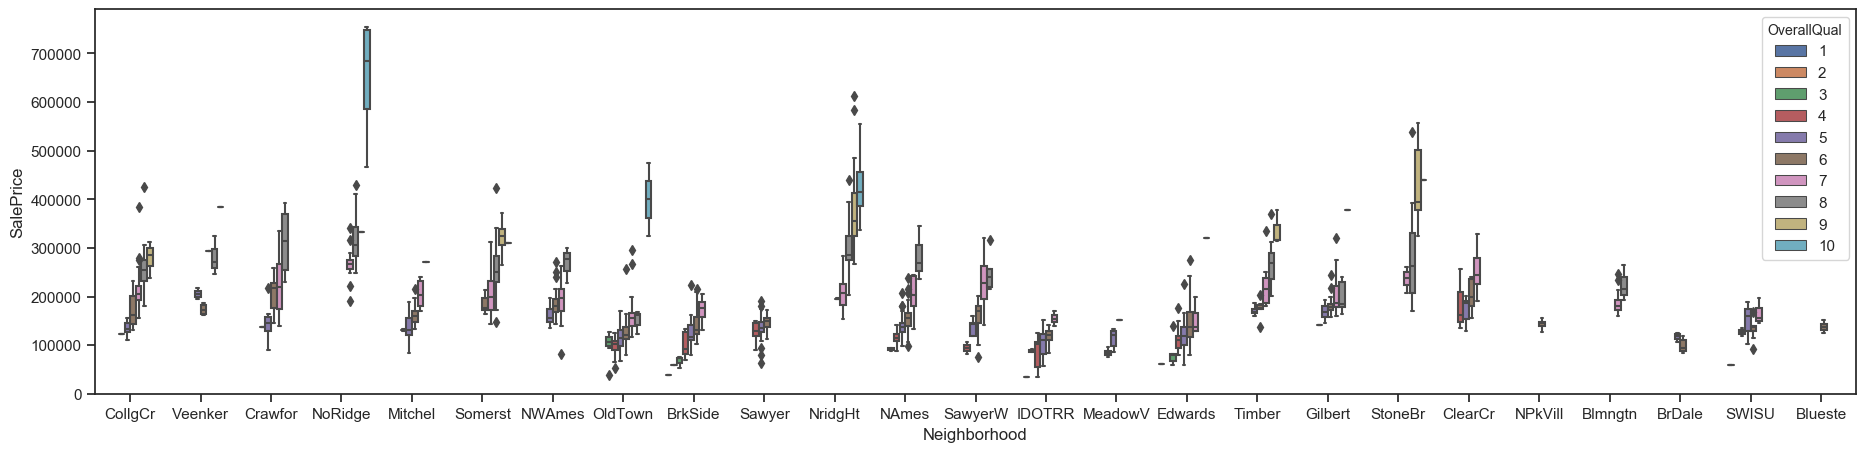

In [675]:
sns.reset_defaults()
sns.set(style="ticks", color_codes=True)
fig = plt.figure(figsize = (50,5))
fig_1 = fig.add_subplot(121)
sns.boxplot(x = "Neighborhood", y = "SalePrice", data = train, hue = "OverallQual")

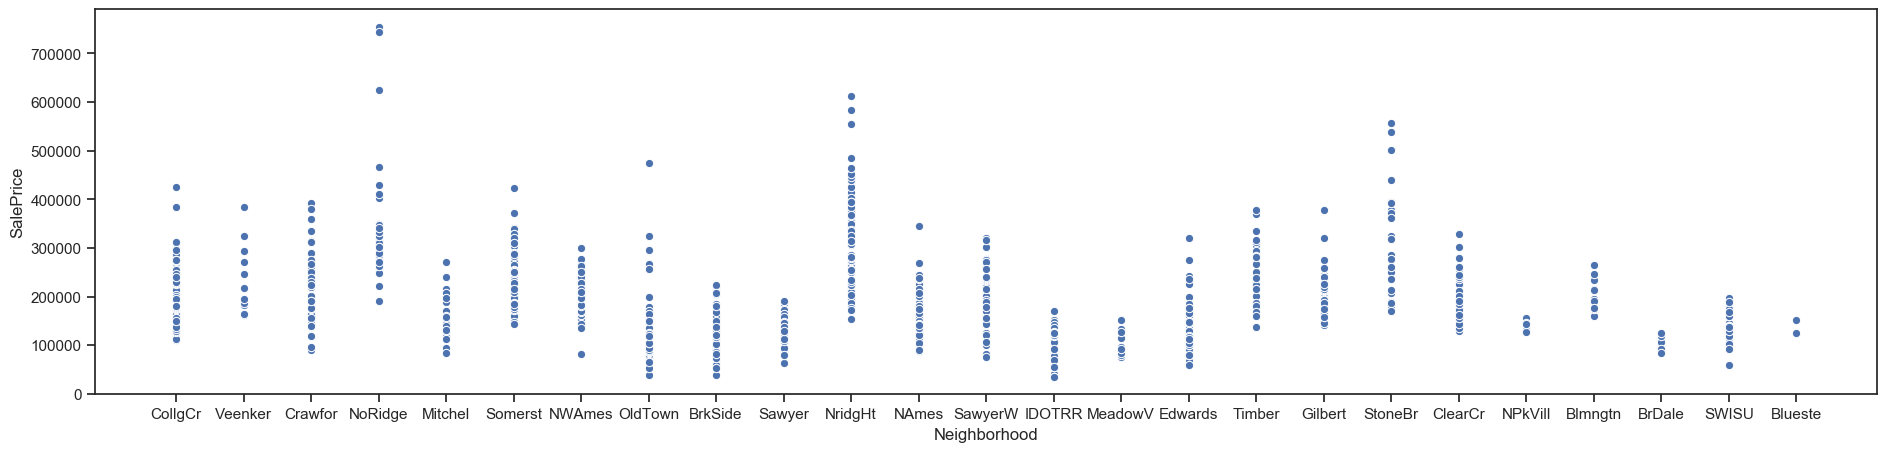

In [676]:
fig = plt.figure(figsize = (23,5))
sns.scatterplot(x = "Neighborhood", y = "SalePrice", data = train)

YrSold  Average Price
0  1974    294000       
1  1976    195500       
2  1977    165000       
3  1978    194000       
4  1981    385000       
5  1984    162500       
6  1993    324000       
7  1995    270000       
8  1996    245500

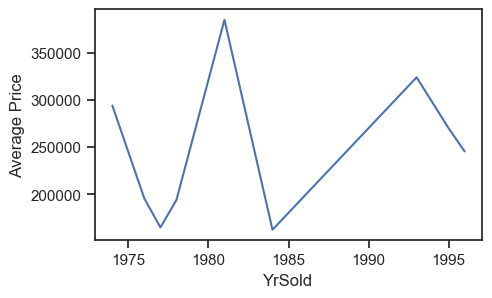

In [677]:
##Relacion entre el año de venta y el precio de venta segun vecindario...
neigh = list(train["Neighborhood"].value_counts().index)

##Plotear precio promedio por año segun cada vecindario
c = train[train["Neighborhood"]== "Veenker"].groupby("YearBuilt")["SalePrice"].mean()
d = pd.DataFrame({"YrSold": c.index, "Average Price": c.values} )
fig = plt.figure(figsize = (5,3))

# ]g = sns.catplot(y= 'YearlyPriceByNeighborhood', x = 'YrSold', col='Neighborhood', data=YearlyPrice, kind="point", aspect=.6, col_wrap=7, height=4, col_order=Neig.index)
sns.lineplot(y= 'Average Price', x = 'YrSold', data = d)
d

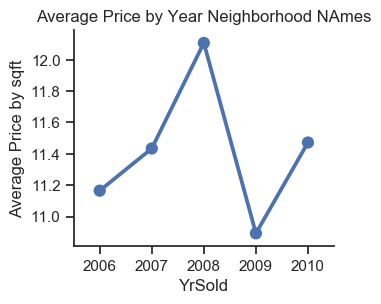

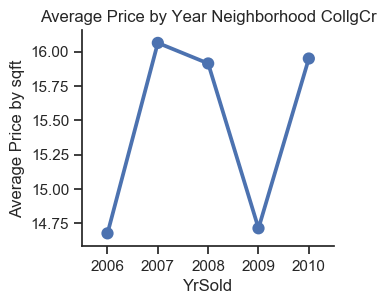

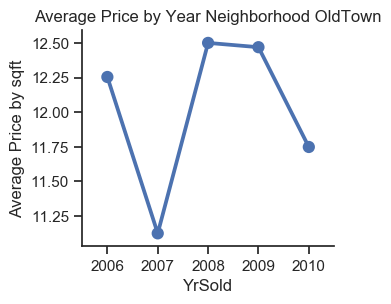

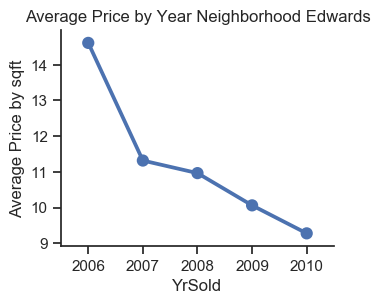

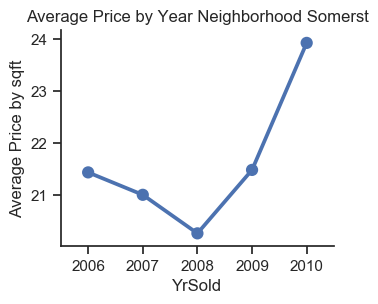

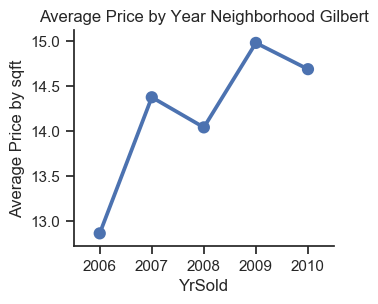

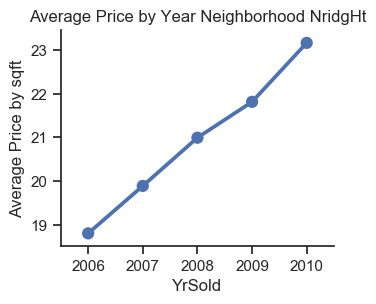

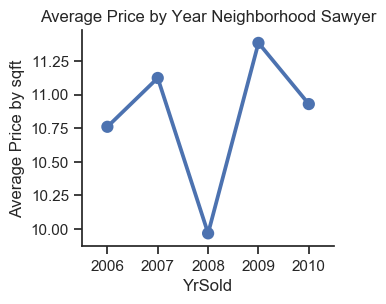

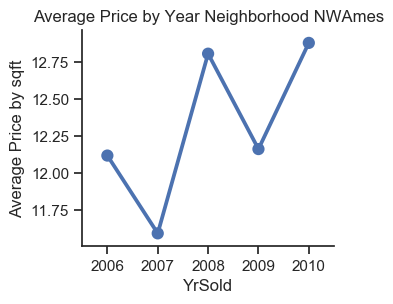

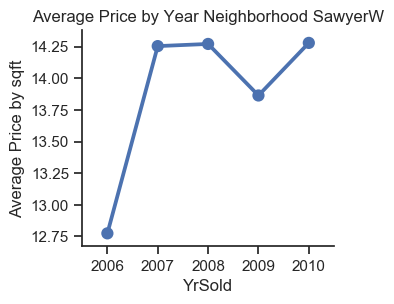

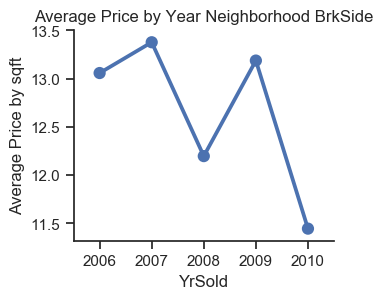

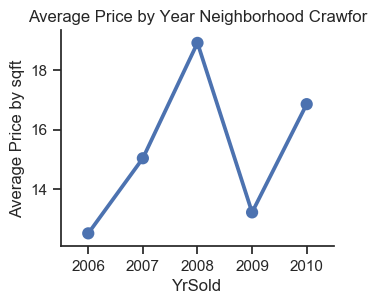

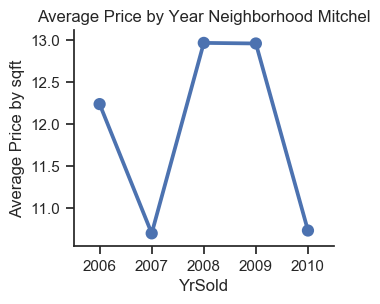

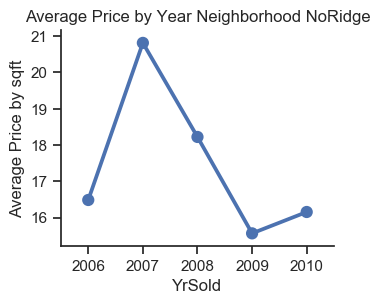

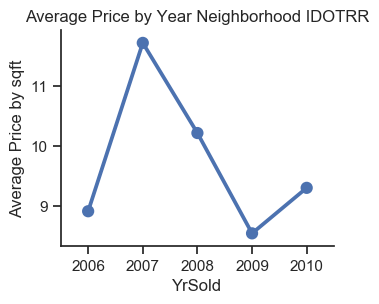

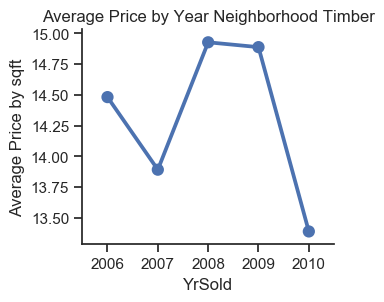

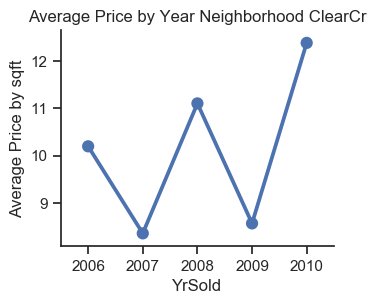

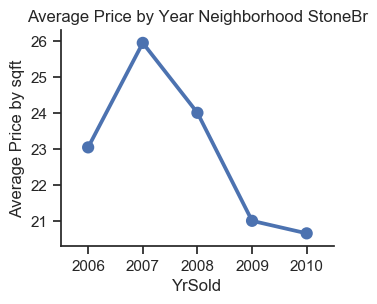

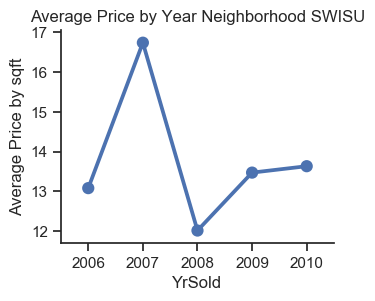

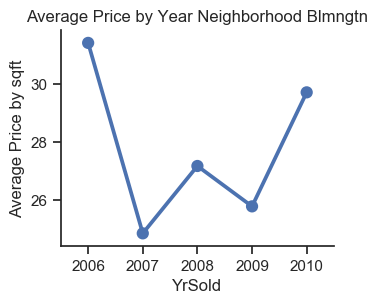

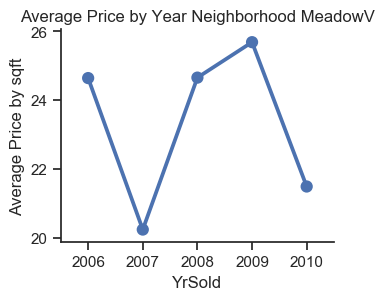

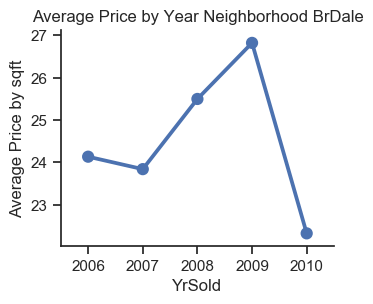

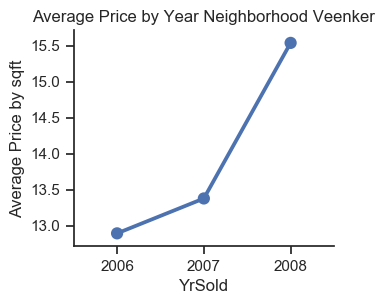

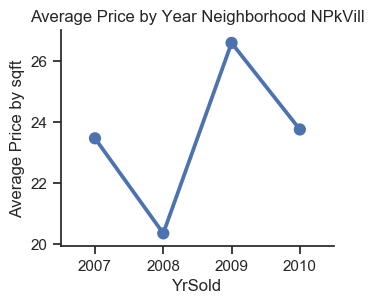

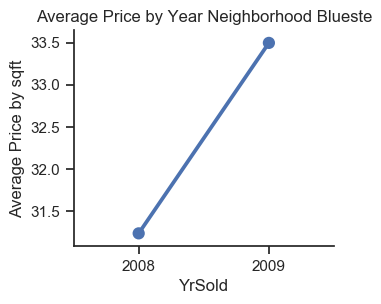

In [678]:
##Relacion entre el año de venta y el precio de venta segun vecindario...
#Tiene más sentido estudiar el valor del m2 por vecindario, como se suele hacer en corretajes

neigh = list(train["Neighborhood"].value_counts().index) #lista de barrios

t = train[["Neighborhood", "YrSold", "SalePrice"]]

#Creamos un nuevo feature de precio promedio por superficie
t["TotalArea"] = (train.TotalBsmtSF.fillna(0) + train.WoodDeckSF.fillna(0) + train.GrLivArea.fillna(0) + 
                   train.LotArea.fillna(0) + train.MasVnrArea.fillna(0) + train.GarageArea.fillna(0) + 
                   train.OpenPorchSF.fillna(0) + train["3SsnPorch"].fillna(0) + train.ScreenPorch.fillna(0) + 
                   train.EnclosedPorch.fillna(0) + train.PoolArea.fillna(0) )

t["PriceArea"] = t["SalePrice"] / t["TotalArea"] #precio por m2

##Plotear precio promedio por año segun cada vecindario
#g = sns.catplot(y= 'YearlyPriceByNeighborhood', x = 'YrSold', col='Neighborhood', data=YearlyPrice, kind="point", aspect=.6, col_wrap=7, height=4, col_order=neigh)
# ]g = sns.catplot(y= 'YearlyPriceByNeighborhood', x = 'YrSold', col='Neighborhood', data=YearlyPrice, kind="point", aspect=.6, col_wrap=7, height=4, col_order=Neig.index)


# ##Plotear precio promedio por año segun cada vecindario
for barrio in neigh:
    c = t[t["Neighborhood"]== barrio].groupby("YrSold")["PriceArea"].mean()
    d = pd.DataFrame({"YrSold": c.index, "Average Price by sqft": c.values} )
    #fig = plt.figure(figsize = (2,2))
    sns.catplot(y= 'Average Price by sqft', x = 'YrSold', data = d,  kind="point", aspect = 1.2, height = 3)
    plt.title("Average Price by Year Neighborhood {}".format(barrio))
    


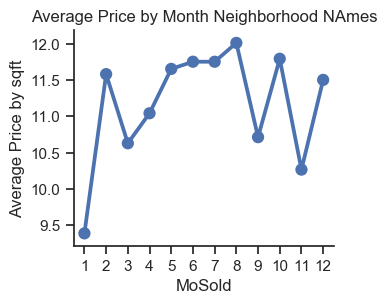

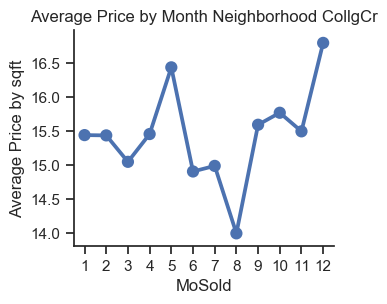

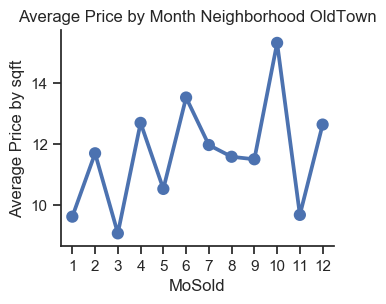

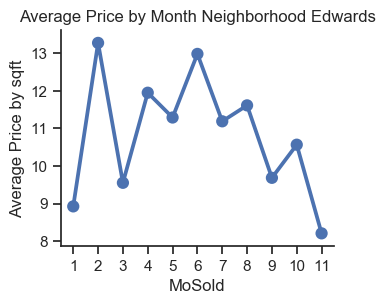

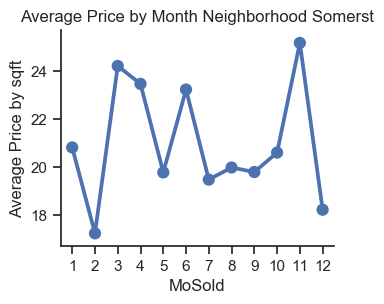

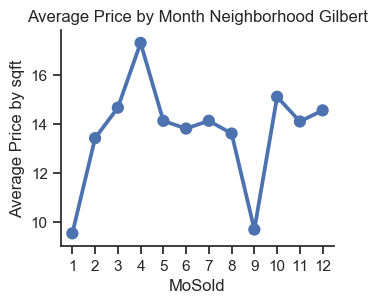

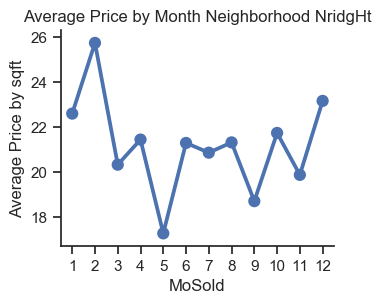

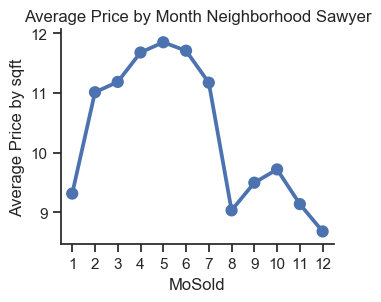

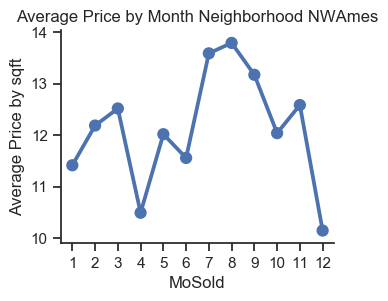

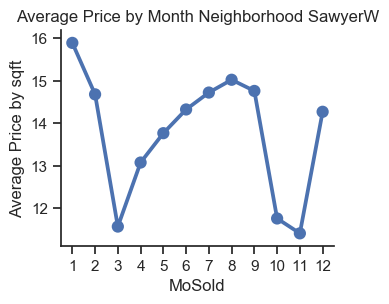

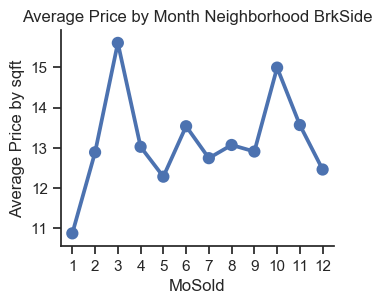

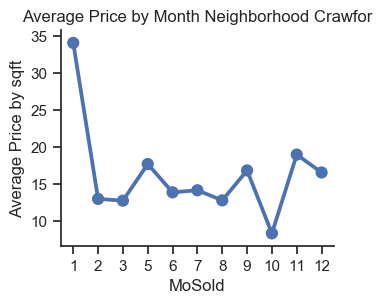

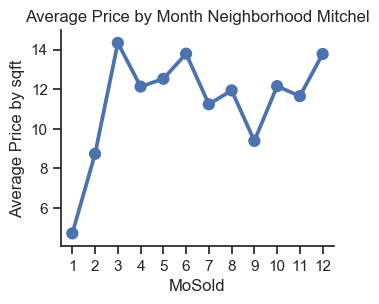

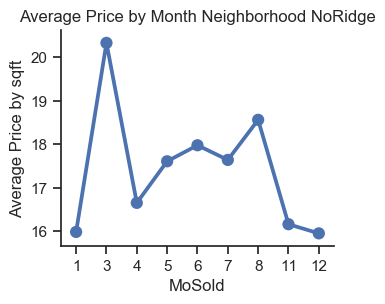

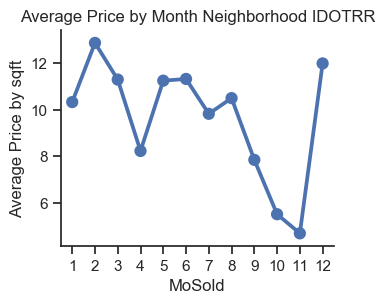

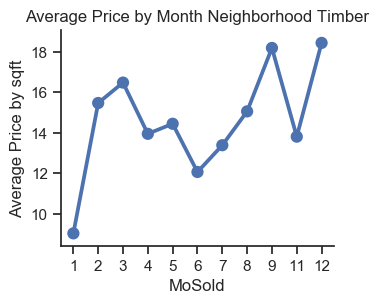

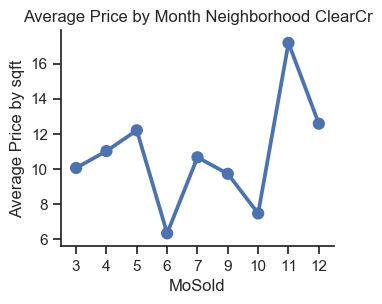

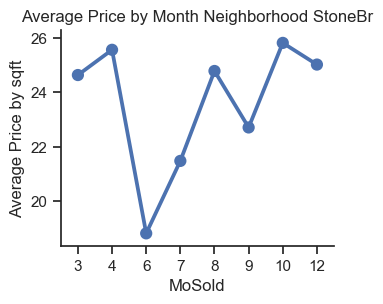

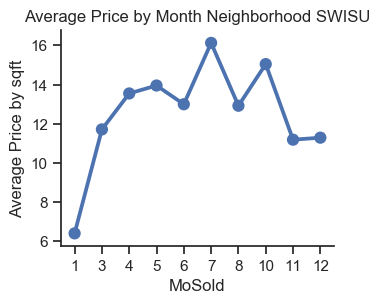

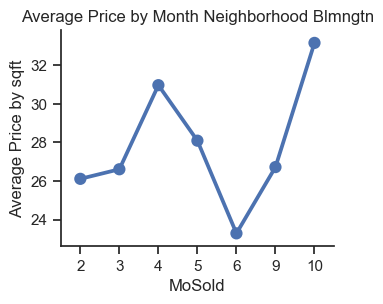

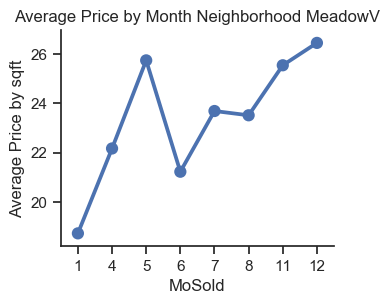

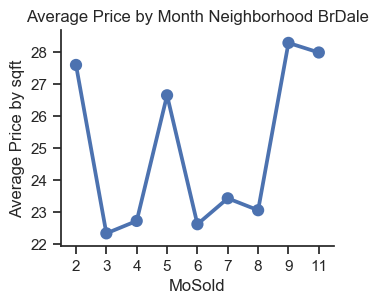

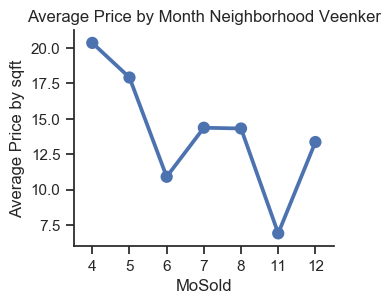

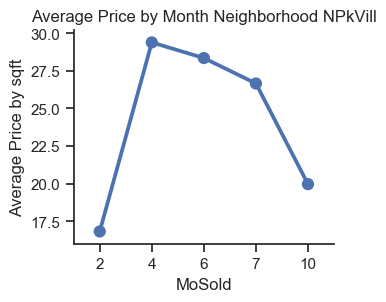

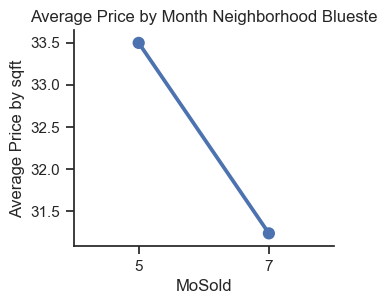

In [679]:
##Lo mismo pero por mes
##Relacion entre el año de venta y el precio de venta segun vecindario...
#Tiene más sentido estudiar el valor del m2 por vecindario, como se suele hacer en corretajes

neigh = list(train["Neighborhood"].value_counts().index) #lista de barrios

t = train[["Neighborhood", "MoSold", "SalePrice"]]

#Creamos un nuevo feature de precio promedio por superficie
t["TotalArea"] = (train.TotalBsmtSF.fillna(0) + train.WoodDeckSF.fillna(0) + train.GrLivArea.fillna(0) + 
                   train.LotArea.fillna(0) + train.MasVnrArea.fillna(0) + train.GarageArea.fillna(0) + 
                   train.OpenPorchSF.fillna(0) + train["3SsnPorch"].fillna(0) + train.ScreenPorch.fillna(0) + 
                   train.EnclosedPorch.fillna(0) + train.PoolArea.fillna(0) )

t["PriceArea"] = t["SalePrice"] / t["TotalArea"] #precio por m2

##Plotear precio promedio por año segun cada vecindario
#g = sns.catplot(y= 'YearlyPriceByNeighborhood', x = 'MoSold', col='Neighborhood', data=YearlyPrice, kind="point", aspect=.6, col_wrap=7, height=4, col_order=neigh)
# ]g = sns.catplot(y= 'YearlyPriceByNeighborhood', x = 'MoSold', col='Neighborhood', data=YearlyPrice, kind="point", aspect=.6, col_wrap=7, height=4, col_order=Neig.index)


# ##Plotear precio promedio por año segun cada vecindario
for barrio in neigh:
    c = t[t["Neighborhood"]== barrio].groupby("MoSold")["PriceArea"].mean()
    d = pd.DataFrame({"MoSold": c.index, "Average Price by sqft": c.values} )
    #fig = plt.figure(figsize = (2,2))
    sns.catplot(y= 'Average Price by sqft', x = 'MoSold', data = d,  kind="point", aspect = 1.2, height = 3)
    plt.title("Average Price by Month Neighborhood {}".format(barrio))
    




In [680]:
#train.filter(like='Y', axis=1)

In [681]:
###Hay outliers detectables? En month pueden verse varios posibles, pero se opta por los más evidentes, que aparecen en Crawfor

In [682]:
t[(t["Neighborhood"] == "Crawfor") & (t["PriceArea"] > 30)]

Neighborhood  MoSold  SalePrice  TotalArea  PriceArea
1181  Crawfor      11      392500    9875.0000  39.7468   
1405  Crawfor      1       275000    8074.0000  34.0599

In [683]:
##Se eliminan estos outliers:
train.drop(index = [1181, 1405], axis = 0, inplace = True)

In [684]:
#new shape
print("Shape of train dataset after outliers removal from neighborhoods:", train.shape[0])

Shape of train dataset after outliers removal from neighborhoods: 1446


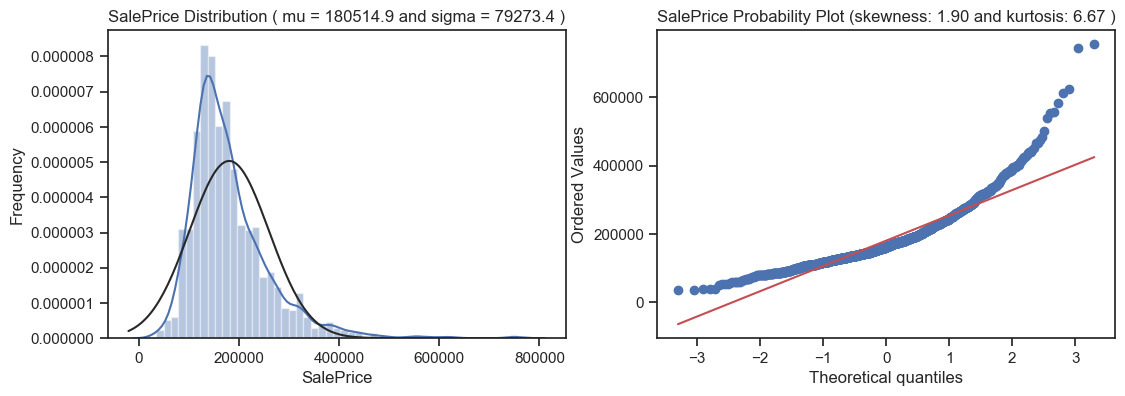

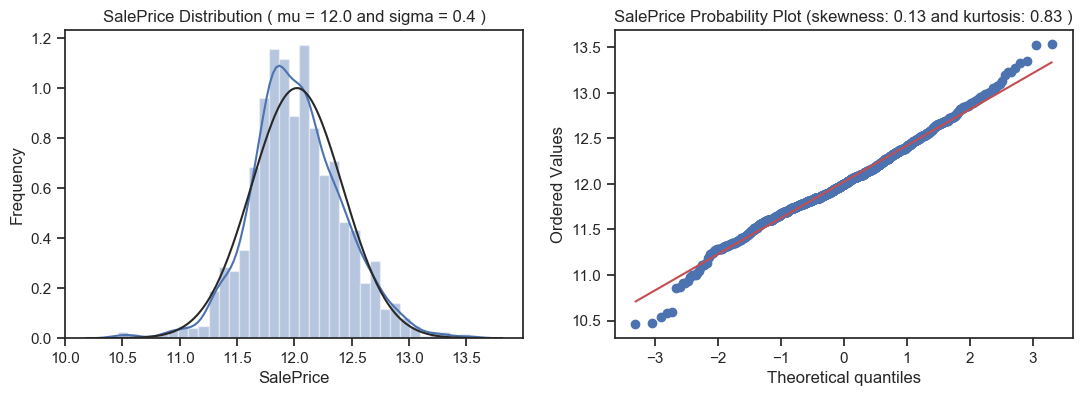

In [685]:
###CHECK THE DISTRIBUTION OF TARGET VARIABLE
##Modulo para plotear

def QQ_plot(data, target):
    #Crea la figura
    fig = plt.figure(figsize = (13,4))
    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)
    #Kernel density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit = norm)
    fig1.set_title(target + ' Distribution ( mu = {:.1f} and sigma = {:.1f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(target)
    fig1.set_ylabel("Frequency")
    
    #Creamos el QQ-plot
    fig2 = fig.add_subplot(122)
    res = stats.probplot(data, plot = fig2)
    fig2.set_title(target + ' Probability Plot (skewness: {:.2f} and kurtosis: {:.2f} )'.format(data.skew(), data.kurt()), loc='center')
    
    #Print results
    
    
    
QQ_plot(data = train["SalePrice"], target = "SalePrice")
QQ_plot(data = np.log1p(train["SalePrice"]), target = "SalePrice")


In [686]:
train.filter(like = "Porch")

OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch
0     61           0              0          0          
1     0            0              0          0          
2     42           0              0          0          
3     35           272            0          0          
4     84           0              0          0          
...   ..          ..             ..         ..          
1455  40           0              0          0          
1456  0            0              0          0          
1457  60           0              0          0          
1458  0            112            0          0          
1459  68           0              0          0          

[1446 rows x 4 columns]

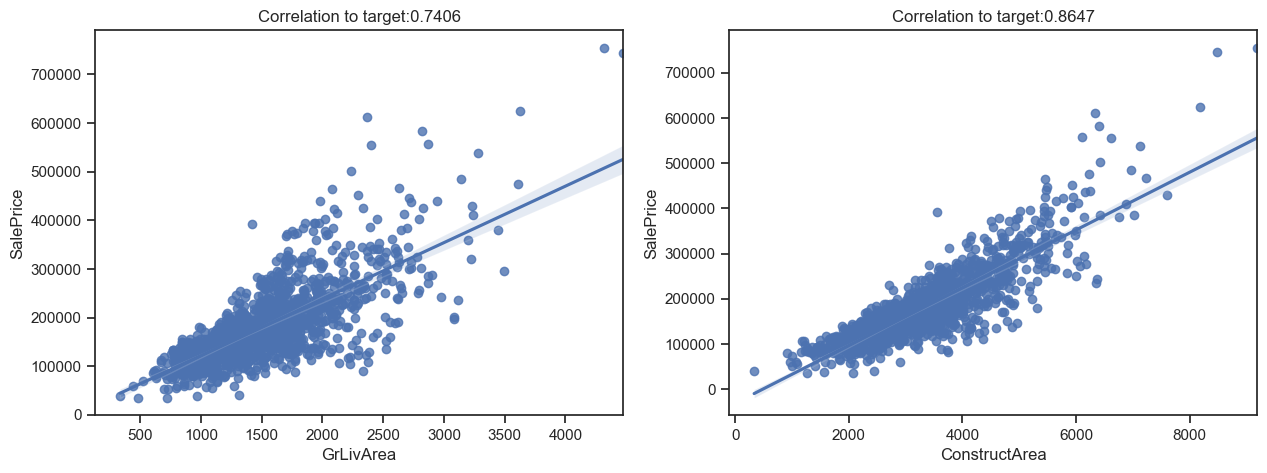

In [687]:
#ANALYSIS AND EVALUATION OF A NEW POSSIBLE FEATURE ACCORDING TO SOME EXPERT ADVICE


#Creamos un nuevo feature de SUPERFICIE CONSTRUIDA



t = train[['SalePrice', 'GrLivArea']]
t['ConstructArea'] = (train.TotalBsmtSF.fillna(0) + train.WoodDeckSF.fillna(0) + train.GrLivArea.fillna(0) + 
                       train.MasVnrArea.fillna(0) + train.GarageArea.fillna(0) + train.OpenPorchSF.fillna(0) + 
                       train["3SsnPorch"].fillna(0) + train.ScreenPorch.fillna(0) + train.EnclosedPorch.fillna(0) + 
                       train.PoolArea.fillna(0) )

#Vale la pena este nuevo feature? Veamos su correlacion con SalePrice
fig = plt.figure(figsize = (15,5))
fig1 = fig.add_subplot(121)
sns.regplot( x= "GrLivArea", y = "SalePrice", data = t )
plt.title("Correlation to target:{:1.4f}".format(t["GrLivArea"].fillna(0).corr(t["SalePrice"])))
fig2 = fig.add_subplot(122)
sns.regplot( x= "ConstructArea", y = "SalePrice", data = t )
plt.title("Correlation to target:{:1.4f}".format(t["ConstructArea"].corr(t["SalePrice"])))
plt.show()


In [688]:
##Se ve que ConstructArea (feature compuesto de la suma de los features de conrtsuccion) es mucho mas solido en correlacion y varianza


In [689]:
#Saving the dataset for gym_module
train.to_csv("train_dataset.csv")

In [690]:
##Conviene conservar los dos features o eliminar GrLivArea? Se realiza un analisis basado en una regresion. 
##Hacemos una regresion de combinaciones de las dos features respecto de SalePrice, e incluimos combinaciones polinomiales

In [691]:
t.columns

Index(['SalePrice', 'GrLivArea', 'ConstructArea'], dtype='object')

In [692]:
#Generamos X e y
y = np.log1p(t["SalePrice"]) #se transformó el target


#Rescaling X
scale = RobustScaler()
X = scale.fit_transform(t[["ConstructArea", "GrLivArea"]])

#Creating train and test sets
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 101)

lr = LinearRegression()



In [693]:
#Comenzamos...
#Modulo para dar resultados
def results():
    print("Coefficients:", lr.coef_)
    print("Root Mean Square Error: %.4f"% np.expm1(np.sqrt(mean_squared_error(y_test, y_pred))))
    print("R-squared test set: %.4f"% r2_score(y_test, y_pred))
    print('--------------------------------------------------------------------------------\n')
    
          
#1. Regresion con solo GrLivArea
print("Regression with GrlivArea:")

lr.fit(x_train[:,1].reshape(-1,1), y_train)
y_pred = lr.predict(x_test[:,1].reshape(-1,1))
results()

#2. Regresion con solo ConstructArea
print("Regression with ConstructArea:")

lr.fit(x_train[:,0].reshape(-1,1), y_train)
y_pred = lr.predict(x_test[:,0].reshape(-1,1))
results()

#3. Regresion with both features
print("Regression with both features:")
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
results()

#4. Polynomial regressor of order 3 with ConstructArea (1,a,a2,a3)
print("Polynomial regressor of order 3 with ConstructArea:")
cubic = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False) #instanciamos
X_cubic = cubic.fit_transform(x_train[:,0].reshape(-1,1)) # se crean todos los features nuevos
lr.fit(X_cubic, y_train)
X_cubic_test = cubic.fit_transform(x_test[:,0].reshape(-1,1))
y_pred = lr.predict(X_cubic_test)
results()

#5. Polynomial regressor of order 3 with both features (1,a,a2,a3, b, ab2, etc)
print("Polynomial regressor of order 3 with both features:")
cubic = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False) #instanciamos
X_cubic = cubic.fit_transform(x_train) # se crean todos los features nuevos
lr.fit(X_cubic, y_train)
X_cubic_test = cubic.fit_transform(x_test) #nuevos features para test
y_pred = lr.predict(X_cubic_test)
results()







Regression with GrlivArea:
Coefficients: [0.36957117]
Root Mean Square Error: 0.3181
R-squared test set: 0.5492
--------------------------------------------------------------------------------

Regression with ConstructArea:
Coefficients: [0.42152472]
Root Mean Square Error: 0.2432
R-squared test set: 0.7200
--------------------------------------------------------------------------------

Regression with both features:
Coefficients: [0.41765626 0.00479717]
Root Mean Square Error: 0.2429
R-squared test set: 0.7205
--------------------------------------------------------------------------------

Polynomial regressor of order 3 with ConstructArea:
Coefficients: [ 0.43923274 -0.04706669  0.0072413 ]
Root Mean Square Error: 0.2386
R-squared test set: 0.7295
--------------------------------------------------------------------------------

Polynomial regressor of order 3 with both features:
Coefficients: [ 0.40675349  0.03596324 -0.05551087  0.04859164 -0.05524813  0.00571584
  0.06577479 -0.

In [694]:
##Los mejores resultados se obtuvieron del regresor polinomial de orden 3 para ConstructArea solitario

In [695]:
####DATA CLEANING
#Concat data for cleaning work:
all_data = pd.concat((train.drop("SalePrice", axis =1), test), axis = 0)
all_data.shape

(2905, 79)

In [696]:
all_data.isnull().sum().sort_values(ascending = False)

nulos = pd.DataFrame(all_data.isnull().sum().sort_values(ascending = False))
nulos[nulos.values > 0].count()

0    34
dtype: int64

In [697]:
nul = summary_2(train, "SalePrice")[["Dtype","Nulls",  "% Nulls"]].sort_values(by = "% Nulls", ascending = False)
nul = nul[nul["Nulls"] >0]
nul["Non_null"] = train.shape[0] - nul["Nulls"]
nul

Dtype  Nulls  % Nulls  Non_null
PoolQC        object   1440  1.0000    6       
MiscFeature   object   1395  0.9600    51      
Alley         object   1356  0.9400    90      
Fence         object   1166  0.8100    280     
FireplaceQu   object   685   0.4700    761     
LotFrontage   float64  256   0.1800    1190    
GarageCond    object   78    0.0500    1368    
GarageQual    object   78    0.0500    1368    
GarageType    object   78    0.0500    1368    
GarageFinish  object   78    0.0500    1368    
GarageYrBlt   float64  78    0.0500    1368    
BsmtExposure  object   38    0.0300    1408    
BsmtQual      object   37    0.0300    1409    
BsmtCond      object   37    0.0300    1409    
BsmtFinType2  object   38    0.0300    1408    
BsmtFinType1  object   37    0.0300    1409    
MasVnrType    object   8     0.0100    1438    
MasVnrArea    float64  8     0.0100    1438    
Electrical    object   1     0.0000    1445

In [698]:
##Hay algun feature categorico que esté muy skewed?? Si es asi, no tiene valor preidctivo y se elimina
#En este caso utilities

cat_feat = all_data.select_dtypes(include = ["object"]).columns 

def cat_skewed(data, feat): ##Busca y entrega categorical cargadas en extremo a una sola clase
    skewed = []
    for f in feat:
        if all_data.groupby(f).size()[0] >= 0.99 * all_data[f].shape[0]: #cargada 99% a una clase
            skewed.append((f, all_data.groupby(f).size()[0]))
    return skewed

cat_skewed(all_data, cat_feat)


[('Utilities', 2902)]

In [699]:
#Por lo anterior eliminamos el feature Utilities...
all_data.drop(["Utilities"], axis = 1, inplace= True)


In [700]:
##Analisis de nulls y data quality en features

In [701]:
#Partimos por Garage
all_data.groupby("GarageType").size()

GarageType
2Types     22  
Attchd     1716
Basment    36  
BuiltIn    185 
CarPort    15  
Detchd     777 
dtype: int64

In [702]:
##Summary
#Separo todos los feats rel to Garage
#Summary de nulls
#Summary de garagearea y garagecars == 0
#Sumary de records con garageyear nulo pero garagetype no nulo---> detached

#Fiilna de nulos de garagetype con NA (en vez de cero por ser categoricos)

#fillna de garagearea con garagetype detached usando median
#fillna de garagearea con 0 para el resto

#fillna de garagecars con garagetype detached usando median
#fillna de garagecars con 0 para el resto

#fillna de garageyrblt con garagetype detached usando median
#fillna de garageyrbltcon 0 para el resto

#fillna de resto que son categ con garagetype detached
#fillna de resto categorico con NA para el resto

#ANALYSIS

## Lo central es ver si hay binconsistencias donde porejemplo no haya año de construccion del garage pero
##si hay calificacion de su tipo 

##Si se revisa se vera que todos los nulls de estas categorias estan juntos, salvo en dos casos donde
##el feat garagetype tiene un valor no nulo (detchd). Por eso se toman esos dos casos ylos nulos se reemplazan por las medianas
#y modas de cada columna, y al resto de todos los nulos se reemplazan por 0 o NA segun numerico o categorico
#Nota: "NA" es una categoria agregada a la clasificacion de cada categorico






In [703]:
feat = ['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageArea', 'GarageCars']

In [704]:
#Summary of nulls..
all_data[feat].isnull().sum().sort_values(ascending = False)

GarageCond      156
GarageQual      156
GarageFinish    156
GarageYrBlt     156
GarageType      154
GarageCars      1  
GarageArea      1  
dtype: int64

In [705]:
##Sumario de los que tienen 0
for f in feat:
    print(f, ":", (all_data[f] == 0).sum())


GarageYrBlt : 0
GarageType : 0
GarageFinish : 0
GarageQual : 0
GarageCond : 0
GarageArea : 154
GarageCars : 154


In [706]:
#Car y Area tienen ceros, que es como si tuvieran nulos ahi (ademas de sus nulls)

In [707]:
all_data[all_data["GarageCars"] == 0][feat]

GarageYrBlt GarageType GarageFinish GarageQual GarageCond  GarageArea  GarageCars
39   nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
48   nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
78   nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
88   nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
89   nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
99   nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
108  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
125  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
127  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
140  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
148  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
155  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
163  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
165  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
198  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
210  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
241  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
250  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
287  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
291  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
307  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
375  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
386  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
393  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
431  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
434  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
441  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
464  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
495  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
520  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
528  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
533  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
535  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
562  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
582  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
613  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
614  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
620  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
636  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
638  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
649  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
705  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
710  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
750  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
784  nan           NaN        NaN          NaN

In [708]:
##Summary de records con garageyrblt nulo pero garagetype no nulo---> detached
all_data[(all_data["GarageYrBlt"].isnull()) & (all_data["GarageType"].isnull() == False)][feat]

GarageYrBlt GarageType GarageFinish GarageQual GarageCond  GarageArea  GarageCars
666  nan           Detchd     NaN          NaN        NaN       360.0000    1.0000     
1116 nan           Detchd     NaN          NaN        NaN       nan         nan

In [709]:
all_data[(all_data["GarageYrBlt"].isnull()) & (all_data["GarageArea"].isnull() == False)][feat]

GarageYrBlt GarageType GarageFinish GarageQual GarageCond  GarageArea  GarageCars
39   nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
48   nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
78   nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
88   nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
89   nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
99   nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
108  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
125  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
127  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
140  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
148  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
155  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
163  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
165  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
198  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
210  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
241  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
250  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
287  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
291  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
307  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
375  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
386  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
393  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
431  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
434  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
441  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
464  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
495  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
520  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
528  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
533  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
535  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
562  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
582  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
613  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
614  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
620  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
636  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
638  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
649  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
705  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
710  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
750  nan           NaN        NaN          NaN        NaN       0.0000      0.0000     
784  nan           NaN        NaN          NaN

In [710]:
#Fillna de nulos de garagetype con NA (en vez de cero por ser categoricos)
all_data["GarageType"] = all_data["GarageType"].fillna("NA")

In [711]:
def fil_f(all_data, feat):
    
    for f in feat:
        if all_data[f].dtype == 'object':
            c_mode = all_data[f].mode()
            all_data.loc[all_data["GarageType"] == "Detchd",  f] = all_data.loc[all_data["GarageType"] == "Detchd", f].fillna(c_mode)
            all_data[f] = all_data[f].fillna("NA")
        else:
            c_median = all_data[f].median()
            all_data.loc[all_data["GarageType"] == "Detchd",  f] = all_data.loc[all_data["GarageType"] == "Detchd", f].fillna(c_median)
            all_data[f] = all_data[f].fillna(0)
            
    return all_data

In [712]:
all_data = fil_f(all_data, feat)

In [713]:
#Check the nulls
all_data[feat].isnull().sum()

GarageYrBlt     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
GarageArea      0
GarageCars      0
dtype: int64

In [714]:
# DEAR ===AHORA ME QUEDAN ANALYSIS Y REPEAT!

In [715]:
###########NALAISIS DE MASONRY VENEER
##Continuamos 
mas_cols  = all_data.filter(like='Mas', axis=1).columns

In [716]:
mas_cols

Index(['MasVnrType', 'MasVnrArea'], dtype='object')

In [717]:
#Nulos en cada una
all_data[mas_cols].isnull().sum()


MasVnrType    24
MasVnrArea    23
dtype: int64

In [718]:
#Nulos en ambas
all_data[(all_data["MasVnrType"].isnull()) & (all_data["MasVnrArea"].isnull())][mas_cols].shape[0]

23

In [719]:
all_data[(all_data["MasVnrType"].isnull()) & (all_data["MasVnrArea"].isnull())][mas_cols]

MasVnrType  MasVnrArea
234   NaN       nan        
529   NaN       nan        
650   NaN       nan        
936   NaN       nan        
973   NaN       nan        
977   NaN       nan        
1243  NaN       nan        
1278  NaN       nan        
231   NaN       nan        
246   NaN       nan        
422   NaN       nan        
532   NaN       nan        
544   NaN       nan        
581   NaN       nan        
851   NaN       nan        
865   NaN       nan        
880   NaN       nan        
889   NaN       nan        
908   NaN       nan        
1132  NaN       nan        
1197  NaN       nan        
1226  NaN       nan        
1402  NaN       nan

In [720]:
#Nulo en Type pero no en Area
all_data[(all_data["MasVnrType"].isnull()) & (all_data["MasVnrArea"].isnull() == False)][mas_cols].shape[0]
all_data[(all_data["MasVnrType"].isnull()) & (all_data["MasVnrArea"].isnull() == False)][mas_cols]


MasVnrType  MasVnrArea
1150  NaN       198.0000

In [721]:
#Nulo en Area pero no en Type
all_data[(all_data["MasVnrType"].isnull() == False) & (all_data["MasVnrArea"].isnull())][mas_cols].shape[0]

0

In [722]:
##Buscar ceros
all_data[all_data["MasVnrArea"] == 0].shape[0]

1732

In [723]:
all_data[(all_data["MasVnrArea"] == 0) & (all_data["MasVnrType"].isnull() == False) ].shape[0]

1732

In [724]:
all_data[(all_data["MasVnrArea"] == 0) & (all_data["MasVnrType"] != "None") ][mas_cols]

MasVnrType  MasVnrArea
688   BrkFace   0.0000     
1241  Stone     0.0000     
859   BrkFace   0.0000

In [725]:
all_data[all_data["MasVnrArea"] == 0][mas_cols]

MasVnrType  MasVnrArea
1     None      0.0000     
3     None      0.0000     
5     None      0.0000     
8     None      0.0000     
9     None      0.0000     
...    ...         ...     
1453  None      0.0000     
1454  None      0.0000     
1455  None      0.0000     
1456  None      0.0000     
1457  None      0.0000     

[1732 rows x 2 columns]

In [726]:
#Clases en MasVnrType
all_data["MasVnrType"].value_counts()

None       1736
BrkFace    877 
Stone      244 
BrkCmn     24  
Name: MasVnrType, dtype: int64

In [727]:
#Hay algun record donde masvtype es None pero area tiene valor no cero ni nulo?
all_data[(all_data["MasVnrArea"] != 0) & (all_data["MasVnrType"]== "None") ].shape[0]

7

In [728]:
all_data[(all_data["MasVnrArea"] != 0) & (all_data["MasVnrType"]== "None")][mas_cols]

MasVnrType  MasVnrArea
624   None      288.0000   
773   None      1.0000     
1230  None      1.0000     
1300  None      344.0000   
1334  None      312.0000   
209   None      285.0000   
992   None      1.0000

In [729]:
##Summary
#Nulls: 23 typre y 24 masvarea
##En todas salvo una están ambas nula y nula
##Nulo en type pero no en area= 1
# Nulo en area pero no entype = 0
# Registros con masvnrarea = 0  1738. En todas menos 3 masvrntype es None
# Clase de masvnrtype mas frcuente = BrkFace
# Hay 7 records donde type es nulo pero area es mayor a cero


## Es None una categoria?
# Su  no lo es la debo imputar?
#O bien None/zero es una forma correcta de de cdecir que no hay amsoneria en la casa?
#Que hago con los 1738 registros que dicen tener masvnrtype None pero area cero. Están correctos (ver pregunta anterior)?
#Como imputo donde vnrtype es nulo pero tiene area? (mode?)
#Como imputo donde vnrty no es nulo pero area si es NUll? (median?)
#Hay 7 records donde type es nulo pero area es mayor a cero: como lo imputo?

#Tesis:
# - dejar tranquilo None/zeros
#Imputar mode/median
#Hay 7 records donde type es nulo pero area es mayor a cero: imputar con el siguiente más frcuente BrkFace

##IMPUTACION:

#Imputar nos None con area >0 (los 7) con el BrkFace (segundo mas frecuente)
# Impouar type nulo con area >0 con Brk face
# En los 3 casos de masvnrtype distinto de None y area = 0 imputar area con median de area de los type que no son None
# Imputar el resto con None y 0 (todos los otros casos)


    


In [730]:
#Imputar nos None con area >0 (los 7) con el BrkFace (segundo mas frecuente)
all_data[(all_data["MasVnrArea"] != 0) & (all_data["MasVnrType"]== "None")][mas_cols]

#Uso del loc: data.loc[condiciones que deben cunmplir los registros, columna que me interesa] = entre la columna
all_data.loc[(all_data["MasVnrArea"] != 0) & (all_data["MasVnrType"]== "None"), "MasVnrType"] = "BrkFace"


In [731]:
 #En los 3 casos de masvnrtype distinto de None y area = 0 imputar area con median de area de los type que no son None
all_data.loc[(all_data["MasVnrArea"] == 0) & (all_data["MasVnrType"] != "None"), ["MasVnrArea"]] = all_data[(all_data["MasVnrType"] != "None") & (all_data["MasVnrArea"] > 0)]["MasVnrArea"].median()

In [732]:
#Imputar el resto con None y 0 (todos los otros casos)
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0) 

In [733]:
##Checking final de nulos:
all_data[mas_cols].isnull().sum()

MasVnrType    0
MasVnrArea    0
dtype: int64

In [734]:
###########NALAISIS DE MASONRY VENEER
##Continuamos 
mas_cols  = all_data.filter(like='Mas', axis=1).columns

In [735]:
mas_cols

Index(['MasVnrType', 'MasVnrArea'], dtype='object')

In [736]:
#Nulos en cada una
all_data[mas_cols].isnull().sum()


MasVnrType    0
MasVnrArea    0
dtype: int64

In [737]:
#Nulos en ambas
all_data[(all_data["MasVnrType"].isnull()) & (all_data["MasVnrArea"].isnull())][mas_cols].shape[0]

0

In [738]:
all_data[(all_data["MasVnrType"].isnull()) & (all_data["MasVnrArea"].isnull())][mas_cols]

Empty DataFrame
Columns: [MasVnrType, MasVnrArea]
Index: []

In [739]:
#Nulo en Type pero no en Area
all_data[(all_data["MasVnrType"].isnull()) & (all_data["MasVnrArea"].isnull() == False)][mas_cols].shape[0]
all_data[(all_data["MasVnrType"].isnull()) & (all_data["MasVnrArea"].isnull() == False)][mas_cols]


Empty DataFrame
Columns: [MasVnrType, MasVnrArea]
Index: []

In [740]:
#Nulo en Area pero no en Type
all_data[(all_data["MasVnrType"].isnull() == False) & (all_data["MasVnrArea"].isnull())][mas_cols].shape[0]

0

In [741]:
##Buscar ceros
all_data[all_data["MasVnrArea"] == 0].shape[0]

1752

In [742]:
all_data[(all_data["MasVnrArea"] == 0) & (all_data["MasVnrType"].isnull() == False) ].shape[0]

1752

In [743]:
all_data[(all_data["MasVnrArea"] == 0) & (all_data["MasVnrType"] != "None") ][mas_cols]

Empty DataFrame
Columns: [MasVnrType, MasVnrArea]
Index: []

In [744]:
all_data[all_data["MasVnrArea"] == 0][mas_cols]

MasVnrType  MasVnrArea
1     None      0.0000     
3     None      0.0000     
5     None      0.0000     
8     None      0.0000     
9     None      0.0000     
...    ...         ...     
1453  None      0.0000     
1454  None      0.0000     
1455  None      0.0000     
1456  None      0.0000     
1457  None      0.0000     

[1752 rows x 2 columns]

In [745]:
#Clases en MasVnrType
all_data["MasVnrType"].value_counts()

None       1753
BrkFace    884 
Stone      244 
BrkCmn     24  
Name: MasVnrType, dtype: int64

In [746]:
#Hay algun record donde masvtype es None pero area tiene valor no cero ni nulo?
all_data[(all_data["MasVnrArea"] != 0) & (all_data["MasVnrType"]== "None") ].shape[0]

1

In [747]:
all_data[(all_data["MasVnrArea"] != 0) & (all_data["MasVnrType"]== "None")][mas_cols]

MasVnrType  MasVnrArea
1150  None      198.0000

In [748]:
##Summary
#Nulls: 23 typre y 24 masvarea
##En todas salvo una están ambas nula y nula
##Nulo en type pero no en area= 1
# Nulo en area pero no entype = 0
# Registros con masvnrarea = 0  1738. En todas menos 3 masvrntype es None
# Clase de masvnrtype mas frcuente = BrkFace
# Hay 7 records donde type es nulo pero area es mayor a cero


## Es None una categoria?
# Su  no lo es la debo imputar?
#O bien None/zero es una forma correcta de de cdecir que no hay amsoneria en la casa?
#Que hago con los 1738 registros que dicen tener masvnrtype None pero area cero. Están correctos (ver pregunta anterior)?
#Como imputo donde vnrtype es nulo pero tiene area? (mode?)
#Como imputo donde vnrty no es nulo pero area si es NUll? (median?)
#Hay 7 records donde type es nulo pero area es mayor a cero: como lo imputo?

#Tesis:
# - dejar tranquilo None/zeros
#Imputar mode/median
#Hay 7 records donde type es nulo pero area es mayor a cero: imputar con el siguiente más frcuente BrkFace

##IMPUTACION:

#Imputar nos None con area >0 (los 7) con el BrkFace (segundo mas frecuente)
# Impouar type nulo con area >0 con Brk face
# En los 3 casos de masvnrtype distinto de None y area = 0 imputar area con median de area de los type que no son None
# Imputar el resto con None y 0 (todos los otros casos)


    


In [749]:
#Imputar nos None con area >0 (los 7) con el BrkFace (segundo mas frecuente)
all_data[(all_data["MasVnrArea"] != 0) & (all_data["MasVnrType"]== "None")][mas_cols]

#Uso del loc: data.loc[condiciones que deben cunmplir los registros, columna que me interesa] = entre la columna
all_data.loc[(all_data["MasVnrArea"] != 0) & (all_data["MasVnrType"]== "None"), "MasVnrType"] = "BrkFace"


In [750]:
 #En los 3 casos de masvnrtype distinto de None y area = 0 imputar area con median de area de los type que no son None
all_data.loc[(all_data["MasVnrArea"] == 0) & (all_data["MasVnrType"] != "None"), ["MasVnrArea"]] = all_data[(all_data["MasVnrType"] != "None") & (all_data["MasVnrArea"] > 0)]["MasVnrArea"].median()

In [751]:
#Imputar el resto con None y 0 (todos los otros casos)
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0) 

In [752]:
##Checking final de nulos:
all_data[mas_cols].isnull().sum()

MasVnrType    0
MasVnrArea    0
dtype: int64

In [753]:
###########NALAISIS DE MASONRY VENEER
##Continuamos 
mas_cols  = all_data.filter(like='Mas', axis=1).columns

In [754]:
all_data[(all_data["GarageYrBlt"].isnull()) & (all_data["GarageCars"].isnull() == False)][feat]

Empty DataFrame
Columns: [GarageYrBlt, GarageType, GarageFinish, GarageQual, GarageCond, GarageArea, GarageCars]
Index: []

In [755]:
mas_cols

Index(['MasVnrType', 'MasVnrArea'], dtype='object')

In [756]:
#Nulos en cada una
all_data[mas_cols].isnull().sum()


MasVnrType    0
MasVnrArea    0
dtype: int64

In [757]:
#Nulos en ambas
all_data[(all_data["MasVnrType"].isnull()) & (all_data["MasVnrArea"].isnull())][mas_cols].shape[0]

0

In [758]:
all_data[(all_data["MasVnrType"].isnull()) & (all_data["MasVnrArea"].isnull())][mas_cols]

Empty DataFrame
Columns: [MasVnrType, MasVnrArea]
Index: []

In [759]:
#Nulo en Type pero no en Area
all_data[(all_data["MasVnrType"].isnull()) & (all_data["MasVnrArea"].isnull() == False)][mas_cols].shape[0]
all_data[(all_data["MasVnrType"].isnull()) & (all_data["MasVnrArea"].isnull() == False)][mas_cols]


Empty DataFrame
Columns: [MasVnrType, MasVnrArea]
Index: []

In [760]:
#Nulo en Area pero no en Type
all_data[(all_data["MasVnrType"].isnull() == False) & (all_data["MasVnrArea"].isnull())][mas_cols].shape[0]

0

In [761]:
##Buscar ceros
all_data[all_data["MasVnrArea"] == 0].shape[0]

1752

In [762]:
all_data[(all_data["MasVnrArea"] == 0) & (all_data["MasVnrType"].isnull() == False) ].shape[0]

1752

In [763]:
all_data[(all_data["MasVnrArea"] == 0) & (all_data["MasVnrType"] != "None") ][mas_cols]

Empty DataFrame
Columns: [MasVnrType, MasVnrArea]
Index: []

In [764]:
all_data[all_data["MasVnrArea"] == 0][mas_cols]

MasVnrType  MasVnrArea
1     None      0.0000     
3     None      0.0000     
5     None      0.0000     
8     None      0.0000     
9     None      0.0000     
...    ...         ...     
1453  None      0.0000     
1454  None      0.0000     
1455  None      0.0000     
1456  None      0.0000     
1457  None      0.0000     

[1752 rows x 2 columns]

In [765]:
#Clases en MasVnrType
all_data["MasVnrType"].value_counts()

None       1752
BrkFace    885 
Stone      244 
BrkCmn     24  
Name: MasVnrType, dtype: int64

In [766]:
#Hay algun record donde masvtype es None pero area tiene valor no cero ni nulo?
all_data[(all_data["MasVnrArea"] != 0) & (all_data["MasVnrType"]== "None") ].shape[0]

0

In [767]:
all_data[(all_data["MasVnrArea"] != 0) & (all_data["MasVnrType"]== "None")][mas_cols]

Empty DataFrame
Columns: [MasVnrType, MasVnrArea]
Index: []

In [768]:
##Summary
#Nulls: 23 typre y 24 masvarea
##En todas salvo una están ambas nula y nula
##Nulo en type pero no en area= 1
# Nulo en area pero no entype = 0
# Registros con masvnrarea = 0  1738. En todas menos 3 masvrntype es None
# Clase de masvnrtype mas frcuente = BrkFace
# Hay 7 records donde type es nulo pero area es mayor a cero


## Es None una categoria?
# Su  no lo es la debo imputar?
#O bien None/zero es una forma correcta de de cdecir que no hay amsoneria en la casa?
#Que hago con los 1738 registros que dicen tener masvnrtype None pero area cero. Están correctos (ver pregunta anterior)?
#Como imputo donde vnrtype es nulo pero tiene area? (mode?)
#Como imputo donde vnrty no es nulo pero area si es NUll? (median?)
#Hay 7 records donde type es nulo pero area es mayor a cero: como lo imputo?

#Tesis:
# - dejar tranquilo None/zeros
#Imputar mode/median
#Hay 7 records donde type es nulo pero area es mayor a cero: imputar con el siguiente más frcuente BrkFace

##IMPUTACION:

#Imputar nos None con area >0 (los 7) con el BrkFace (segundo mas frecuente)
# Impouar type nulo con area >0 con Brk face
# En los 3 casos de masvnrtype distinto de None y area = 0 imputar area con median de area de los type que no son None
# Imputar el resto con None y 0 (todos los otros casos)


    


In [769]:
#Imputar nos None con area >0 (los 7) con el BrkFace (segundo mas frecuente)
all_data[(all_data["MasVnrArea"] != 0) & (all_data["MasVnrType"]== "None")][mas_cols]

#Uso del loc: data.loc[condiciones que deben cunmplir los registros, columna que me interesa] = entre la columna
all_data.loc[(all_data["MasVnrArea"] != 0) & (all_data["MasVnrType"]== "None"), "MasVnrType"] = "BrkFace"


In [770]:
 #En los 3 casos de masvnrtype distinto de None y area = 0 imputar area con median de area de los type que no son None
all_data.loc[(all_data["MasVnrArea"] == 0) & (all_data["MasVnrType"] != "None"), ["MasVnrArea"]] = all_data[(all_data["MasVnrType"] != "None") & (all_data["MasVnrArea"] > 0)]["MasVnrArea"].median()

In [771]:
#Imputar el resto con None y 0 (todos los otros casos)
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0) 

In [772]:
##Checking final de nulos:
all_data[mas_cols].isnull().sum()

MasVnrType    0
MasVnrArea    0
dtype: int64

In [773]:
###

In [774]:
miss = all_data.isnull().sum().sort_values(ascending = False)

In [775]:
miss[miss > 0]

PoolQC          2896
MiscFeature     2803
Alley           2708
Fence           2335
FireplaceQu     1415
LotFrontage     483 
BsmtExposure    82  
BsmtCond        82  
BsmtQual        81  
BsmtFinType2    80  
BsmtFinType1    79  
MSZoning        4   
BsmtFullBath    2   
BsmtHalfBath    2   
Functional      2   
KitchenQual     1   
SaleType        1   
Electrical      1   
Exterior2nd     1   
TotalBsmtSF     1   
BsmtUnfSF       1   
BsmtFinSF2      1   
BsmtFinSF1      1   
Exterior1st     1   
dtype: int64

In [776]:
###CONTINUAMOS CON BASEMENT RELATED FEATURES

b_cols  = all_data.filter(like='Bsm', axis=1).columns

In [777]:
b_cols

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'BsmtFullBath', 'BsmtHalfBath'],
      dtype='object')

In [778]:
all_data[b_cols].head() 

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
0  Gd       TA       No           GLQ         706.0000     Unf         0.0000      150.0000   856.0000     1.0000        0.0000       
1  Gd       TA       Gd           ALQ         978.0000     Unf         0.0000      284.0000   1262.0000    0.0000        1.0000       
2  Gd       TA       Mn           GLQ         486.0000     Unf         0.0000      434.0000   920.0000     1.0000        0.0000       
3  TA       Gd       No           ALQ         216.0000     Unf         0.0000      540.0000   756.0000     1.0000        0.0000       
4  Gd       TA       Av           GLQ         655.0000     Unf         0.0000      490.0000   1145.0000    1.0000        0.0000

In [779]:
#Checking the nulls
all_data[b_cols].isnull().sum().sort_values(ascending = False)

BsmtExposure    82
BsmtCond        82
BsmtQual        81
BsmtFinType2    80
BsmtFinType1    79
BsmtHalfBath    2 
BsmtFullBath    2 
TotalBsmtSF     1 
BsmtUnfSF       1 
BsmtFinSF2      1 
BsmtFinSF1      1 
dtype: int64

In [780]:
#Checking the ones with zeros...
b_num = all_data[b_cols].select_dtypes(exclude= object).columns
b_cat = all_data[b_cols].select_dtypes(include= object).columns
b_num
for n in b_num:
    print(n, ":", all_data[all_data[n] == 0].shape[0])


BsmtFinSF1 : 927
BsmtFinSF2 : 2559
BsmtUnfSF : 240
TotalBsmtSF : 78
BsmtFullBath : 1701
BsmtHalfBath : 2732


In [781]:
##Notas
# casos de feats que tengan clasificacion NA (no tiene basement) pero que igual tenga datos en las otras features
# En los casos de cero todos parecen tambien tener cero
# No hay ningun feat categorico que tenga clasisfacion NA
#Notar que BsmtUnfSF = BsmtFinSF1'  +  'BsmtFinSF2' + 'BsmtUnfSF'
#Mirando los nulls, hay 78 registros de casas con fullbsmtsf zero, lo que significa que no tienen bsmt

#Acciones
# Fiilna de numericos con mediana de sus categorias asociadas: ej BsmtFinSF1 se rellena con valor mediano de su categoria BsmtFinType1




In [782]:
#buscando no zeros...

def no_zeros(data, col):
    nz = pd.DataFrame(columns = col)
    for c in col:
        pd.concat((nz, data.loc[data[c] == 0, : ]), axis = 0)
        
    return nz

nz2 = no_zeros(all_data, b_cols)

In [783]:
nz2

Empty DataFrame
Columns: [BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath]
Index: []

In [784]:
##Most frquent classes in each feature
for c in b_cat:
    print(c, ":", all_data.groupby(c).size().sort_values(ascending = False))

BsmtQual : BsmtQual
TA    1277
Gd    1206
Ex    253 
Fa    88  
dtype: int64
BsmtCond : BsmtCond
TA    2594
Gd    121 
Fa    103 
Po    5   
dtype: int64
BsmtExposure : BsmtExposure
No    1899
Av    417 
Gd    268 
Mn    239 
dtype: int64
BsmtFinType1 : BsmtFinType1
Unf    849
GLQ    844
ALQ    426
Rec    287
BLQ    268
LwQ    152
dtype: int64
BsmtFinType2 : BsmtFinType2
Unf    2481
Rec    104 
LwQ    87  
BLQ    67  
ALQ    52  
GLQ    34  
dtype: int64


In [785]:
b_cols

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'BsmtFullBath', 'BsmtHalfBath'],
      dtype='object')

In [786]:
##Pares a revisar:

#'BsmtFinType1', 'BsmtFinSF1'
# 'BsmtFinType2', 'BsmtFinSF2'

#Fillna de BsmtFinType1', 'BsmtFinSF1' con moda de BsmtFinType1 (Unf)

# fillna de BsmtFinType2', 'BsmtFinSF2' con moda de BsmtFinType2' (Unf)

# chequear que pasa con 78 casas de totalbsmt = 0 (no hay subterraneo) 
# Hay 2 casas que tienen todos los datos menos el BsmtQual (81 rn total cpn 2 que tienen datos y el resto todo pelado)

#Ver casos donde Bmstype es no nulo pero tiene  valosres Bsmtsf nulo o cero (se reemplazan con median de su categoria?)

#Chequear BsmtCond y los totalbsmtsf

#Bsmatexposure: fillna pero solo donde bsmttotal sea >0 (si es cero no hay basement)


In [787]:
##3...chequear que pasa con 78 casas de totalbsmt = 0 (no hay subterraneo) 

all_data[all_data["TotalBsmtSF"] == 0][b_cols] ##estan completamente vacias

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
17    NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
39    NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
90    NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
102   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
156   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
182   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
259   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
342   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
362   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
371   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
392   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
520   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
532   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
533   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
553   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
646   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
705   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
736   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
749   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
778   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
868   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
894   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
897   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
984   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
1000  NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
1011  NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
1035  NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
1045  NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
104

In [788]:
#revision de los 81 bsmtqual que son nan...
all_data[all_data['BsmtQual'].isnull()][b_cols]

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
17    NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
39    NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
90    NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
102   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
156   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
182   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
259   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
342   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
362   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
371   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
392   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
520   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
532   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
533   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
553   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
646   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
705   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
736   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
749   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
778   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
868   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
894   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
897   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
984   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
1000  NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
1011  NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
1035  NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
1045  NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
104

In [789]:
#2.  Zoom a los registros que no son nulos asociados a sbsmtWQual...
all_data[(all_data['BsmtQual'].isnull()) & (all_data["TotalBsmtSF"] != 0) & (all_data["TotalBsmtSF"].isnull() == False)][b_cols]


BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
757  NaN      Fa       No           Unf         0.0000       Unf         0.0000      173.0000   173.0000     0.0000        0.0000       
758  NaN      TA       No           Unf         0.0000       Unf         0.0000      356.0000   356.0000     0.0000        0.0000

In [790]:
#Ver casos donde Bmstype es no nulo pero tiene  valosres Bsmtsf nulo o cero (se reemplazan con median de su categoria?)
all_data[(all_data["BsmtFinType1"].isnull == False) & (all_data["BsmtFinSF1"] > 0)][b_cols]

Empty DataFrame
Columns: [BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath]
Index: []

In [791]:
all_data[(all_data["BsmtFinType2"].isnull == False) & (all_data["BsmtFinSF2"] > 0)][b_cols]

Empty DataFrame
Columns: [BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath]
Index: []

In [792]:
## 1..Check bsmtcond y Totalbsmsf
all_data[all_data["BsmtCond"].isnull() & all_data["TotalBsmtSF"] > 0][b_cols]

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
580   Gd       NaN      Mn           GLQ         1044.0000    Rec         382.0000    0.0000     1426.0000    1.0000        0.0000       
725   TA       NaN      No           BLQ         1033.0000    Unf         0.0000      94.0000    1127.0000    0.0000        1.0000       
1064  TA       NaN      Av           ALQ         755.0000     Unf         0.0000      240.0000   995.0000     0.0000        0.0000

In [793]:
## Casos:
# basmtcond nulo pero totalbssf no nulo : 1..(hay 3)
#BsmtQual nulo pero totalbssf no nulo : ..2 (hay 2)
# 78 casas de totalbsmt = 0 (no hay subterraneo) : ..3 (hay 78)
#bsmstqual null y bsmtcond no nulo: ..4 ( hay 2)
#bsmstqual no null y bsmtcond nulo: ...5 ( hay 3)
#bsmtcond o bsmt qual no nulos pero total bsmtsf es cero: No hay



In [794]:
#4.... bsmstqual null y bsmtcond no nulo
all_data[(all_data["BsmtQual"].isnull()) & (all_data["BsmtCond"].isnull() == False)][b_cols]

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
757  NaN      Fa       No           Unf         0.0000       Unf         0.0000      173.0000   173.0000     0.0000        0.0000       
758  NaN      TA       No           Unf         0.0000       Unf         0.0000      356.0000   356.0000     0.0000        0.0000

In [795]:
#5....bsmstqual no null y bsmtcond nulo
all_data[(all_data["BsmtCond"].isnull()) & (all_data["BsmtQual"].isnull() == False)][b_cols]

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
580   Gd       NaN      Mn           GLQ         1044.0000    Rec         382.0000    0.0000     1426.0000    1.0000        0.0000       
725   TA       NaN      No           BLQ         1033.0000    Unf         0.0000      94.0000    1127.0000    0.0000        1.0000       
1064  TA       NaN      Av           ALQ         755.0000     Unf         0.0000      240.0000   995.0000     0.0000        0.0000

In [796]:
#bsmtcond o bsmt qual no nulos pero total bsmtsf es cero
all_data[(all_data["BsmtCond"].isnull() == False) & (all_data["TotalBsmtSF"] == 0) ][b_cols]


Empty DataFrame
Columns: [BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath]
Index: []

In [797]:
all_data[(all_data["BsmtQual"].isnull() == False) & (all_data["TotalBsmtSF"] == 0) ][b_cols]


Empty DataFrame
Columns: [BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath]
Index: []

In [798]:
b_cols

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'BsmtFullBath', 'BsmtHalfBath'],
      dtype='object')

In [799]:
all_data[['BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']]

BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF
0     GLQ         706.0000     Unf         0.0000      150.0000   856.0000    
1     ALQ         978.0000     Unf         0.0000      284.0000   1262.0000   
2     GLQ         486.0000     Unf         0.0000      434.0000   920.0000    
3     ALQ         216.0000     Unf         0.0000      540.0000   756.0000    
4     GLQ         655.0000     Unf         0.0000      490.0000   1145.0000   
...   ...              ...     ...            ...           ...         ...   
1454  Unf         0.0000       Unf         0.0000      546.0000   546.0000    
1455  Rec         252.0000     Unf         0.0000      294.0000   546.0000    
1456  ALQ         1224.0000    Unf         0.0000      0.0000     1224.0000   
1457  GLQ         337.0000     Unf         0.0000      575.0000   912.0000    
1458  LwQ         758.0000     Unf         0.0000      238.0000   996.0000    

[2905 rows x 6 columns]

In [800]:
##NOTA TAREA: CUANDO UNO DE LOS TYPE1 O TYPE2 ESTA BAJO UNF SIGNIFICA UNFINISHED Y POR TANTO DEBE TENER CERO SF
# Y LA SUPERICIE SIN CONSTRUIR DEBE IR A BSMTUNFSF

##ojo: la moda a veces es "No" o no tiene (valor mas repetido), asi que para imputar fijarse en el segundo valor mas repetido

In [801]:
all_data[b_cols].head()

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
0  Gd       TA       No           GLQ         706.0000     Unf         0.0000      150.0000   856.0000     1.0000        0.0000       
1  Gd       TA       Gd           ALQ         978.0000     Unf         0.0000      284.0000   1262.0000    0.0000        1.0000       
2  Gd       TA       Mn           GLQ         486.0000     Unf         0.0000      434.0000   920.0000     1.0000        0.0000       
3  TA       Gd       No           ALQ         216.0000     Unf         0.0000      540.0000   756.0000     1.0000        0.0000       
4  Gd       TA       Av           GLQ         655.0000     Unf         0.0000      490.0000   1145.0000    1.0000        0.0000

In [802]:
## MISSING DATA IMPUTATION
## Bsmatexposure: fillna con moda pero solo donde bsmttotal sea >0 (si es cero no hay basement): Av
all_data.loc[(all_data["BsmtExposure"].isnull()) & (all_data["TotalBsmtSF"].isnull() == False) & (all_data["TotalBsmtSF"] > 0) , ["BsmtExposure"]] = "Av"



In [803]:
##Idem con BsmtQual
all_data.loc[(all_data["BsmtQual"].isnull()) & (all_data["TotalBsmtSF"].isnull() == False) & (all_data["TotalBsmtSF"] > 0) , ["BsmtQual"]] = "TA"


In [804]:
##Idem con BsmtCond
all_data.loc[(all_data["BsmtCond"].isnull()) & (all_data["TotalBsmtSF"].isnull() == False) & (all_data["TotalBsmtSF"] > 0) , ["BsmtCond"]] = "TA"


In [805]:
#Idem con BsmtFinType2
all_data.loc[(all_data["BsmtFinType2"].isnull()) & (all_data["BsmtFinSF2"].isnull() == False) & (all_data["BsmtFinSF2"] > 0) , ["BsmtFinType2"]] = "Unf"


In [806]:
all_data["BsmtFinType1"].value_counts()

Unf    849
GLQ    844
ALQ    426
Rec    287
BLQ    268
LwQ    152
Name: BsmtFinType1, dtype: int64

In [807]:
all_data["BsmtFinType1"].isnull().sum()

79

In [808]:
#Idem con BsmtFinType1: NO HAY
all_data.loc[(all_data["BsmtFinType1"].isnull()) & (all_data["BsmtFinSF1"].isnull() == False) & (all_data["BsmtFinSF1"] > 0) , ["BsmtFinType1"]] 


Empty DataFrame
Columns: [BsmtFinType1]
Index: []

In [809]:
##Sutileza: se encontro un record donde BsmtFinType2 existe pero no tiene area, mientras  que al lado BsmtUnf tiene area.
#Por tanto se asume error y hay que apsar ese valor de area de unfinished al area de type2


In [810]:
all_data.loc[(all_data["BsmtFinType2"] == "BLQ") & (all_data["BsmtFinSF2"] == 0), :][b_cols]

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
10  Gd       TA       No           GLQ         1051.0000    BLQ         0.0000      354.0000   1405.0000    1.0000        0.0000

In [811]:
#Moviendo el valor
all_data.loc[(all_data["BsmtFinType2"] == "BLQ") & (all_data["BsmtFinSF2"] == 0), ["BsmtFinSF2"]] = 354.0
all_data.loc[(all_data["BsmtFinType2"] == "BLQ") & (all_data["BsmtFinSF2"] == 0), ["BsmtUnfSF"]] = 0.000000


In [812]:
#3Todas las que quedan corresponden a casas sin basement, asi que se fillna cion NA y zero a todo
all_data[b_cols].isnull().sum()

BsmtQual        79
BsmtCond        79
BsmtExposure    79
BsmtFinType1    79
BsmtFinSF1      1 
BsmtFinType2    79
BsmtFinSF2      1 
BsmtUnfSF       1 
TotalBsmtSF     1 
BsmtFullBath    2 
BsmtHalfBath    2 
dtype: int64

In [813]:
all_data[all_data["BsmtQual"].isnull()][b_cols]

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
17    NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
39    NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
90    NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
102   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
156   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
182   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
259   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
342   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
362   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
371   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
392   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
520   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
532   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
533   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
553   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
646   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
705   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
736   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
749   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
778   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
868   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
894   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
897   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
984   NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
1000  NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
1011  NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
1035  NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
1045  NaN      NaN      NaN          NaN         0.0000       NaN         0.0000      0.0000     0.0000       0.0000        0.0000       
104

In [814]:
##Fillna a categoricos con NA y numericos con 0:

for c in b_cat:
    all_data[c] = all_data[c].fillna("Na")
    
for c in b_num:
    all_data[c] = all_data[c].fillna("0")

In [815]:
#Final check
all_data[b_cols].isnull().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinType2    0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
dtype: int64

In [816]:
#CONTINUAMOS CON LOTFRONTAGE

all_data["LotFrontage"].isnull().sum()

483

In [817]:
l_cols  = all_data.filter(like='Lot', axis=1).columns

In [818]:
l_cols

Index(['LotFrontage', 'LotArea', 'LotShape', 'LotConfig'], dtype='object')

In [819]:
# Lotfrontage es el unico feature con nulls
all_data[l_cols].isnull().sum()

LotFrontage    483
LotArea        0  
LotShape       0  
LotConfig      0  
dtype: int64

In [820]:
##Que referencia uso para asignar los fillna? La mas razonable seria la mediana de lotfrontage correspondiente al barrio...
#3Hay que preocuparse de que no vaya a haber un Nan en neighborhood, pero se chequeo y hay cero null en ese feature
all_data.loc[all_data["LotFrontage"].isnull(), "Neighborhood"] 

7       NWAmes 
12      Sawyer 
14      NAmes  
16      NAmes  
24      Sawyer 
31      Sawyer 
42      SawyerW
43      CollgCr
50      Gilbert
64      CollgCr
66      NAmes  
76      NAmes  
84      Gilbert
95      Gilbert
100     NWAmes 
104     IDOTRR 
111     Gilbert
113     Crawfor
116     Sawyer 
120     ClearCr
126     NPkVill
131     Gilbert
133     Timber 
136     NAmes  
147     Gilbert
149     BrkSide
152     NWAmes 
153     ClearCr
160     Veenker
166     ClearCr
169     Timber 
170     OldTown
177     Sawyer 
180     Somerst
186     Mitchel
191     NAmes  
203     CollgCr
207     NAmes  
208     SawyerW
214     CollgCr
218     Crawfor
221     Gilbert
234     Gilbert
237     SawyerW
244     SawyerW
269     Edwards
287     NAmes  
288     Sawyer 
293     NWAmes 
307     IDOTRR 
308     Edwards
310     Gilbert
319     NWAmes 
328     BrkSide
330     NAmes  
342     NAmes  
346     NAmes  
347     NAmes  
351     ClearCr
356     Gilbert
360     Mitchel
361     BrkSide
364     

In [821]:
#3Filling nans with median according to neighborhood
med = []
neig = all_data["Neighborhood"].values
for n in neig:
    med.append(all_data[all_data["Neighborhood"] == n]["LotFrontage"].median())
    
for n, m in zip(neig, med):
    all_data.loc[(all_data["LotFrontage"].isnull()) & (all_data["Neighborhood"] == n), ["LotFrontage"]] = m

In [822]:
all_data["LotFrontage"].isnull().sum()

0

In [823]:
##Continuamos con Pool
p_col = all_data.filter(like='ool', axis=1).columns
p_col

Index(['PoolArea', 'PoolQC'], dtype='object')

In [824]:
all_data[p_col].isnull().sum() #pool area no tiene nulos pero poolqual si

PoolArea    0   
PoolQC      2896
dtype: int64

In [825]:
##Casos
#Poolq nulo y pool area mayor que zero:  fillna con overallqual calificacion/2 como referencia temporal (!)
#Poolq nulo y pool area  zero: fillna con "NA" No tiene piscina
#Pool qc no nulo y poolarea zero: fillna con "NA" NO HAY
#poolqc no nulo y poolarea nulo: fillna con mediana de pool para esa calificacion: NO HAY


In [826]:
all_data[p_col].head()

PoolArea PoolQC
0  0         NaN  
1  0         NaN  
2  0         NaN  
3  0         NaN  
4  0         NaN

In [827]:
all_data.loc[all_data["PoolQC"].isnull() & all_data["PoolArea"] > 0]["OverallQual"]

1139    3
Name: OverallQual, dtype: int64

In [828]:
#Pool nulo y pool area mayor que zero: fil fillna con overallqual calificacion/2 como referencia temporal
all_data[all_data["PoolQC"].isnull() & all_data["PoolArea"] > 0] # un solo caso

#Fillna
all_data.loc[all_data["PoolQC"].isnull() & all_data["PoolArea"] > 0, ["PoolQC"]] = all_data.loc[all_data["PoolQC"].isnull() & all_data["PoolArea"] > 0]["OverallQual"]/2

In [829]:
#Poolq nulo y pool area  zero: fillna con "NA"
all_data.loc[all_data["PoolQC"].isnull() & all_data["PoolArea"] ==  0, ["PoolQC"]] = "NA"

In [830]:
#Checking the final nulls
all_data[p_col].isnull().sum()

PoolArea    0
PoolQC      0
dtype: int64

In [831]:
#Checking nulls so far...
sum = all_data.isnull().sum().sort_values(ascending = False)
sum[sum>0]

MiscFeature    2803
Alley          2708
Fence          2335
FireplaceQu    1415
MSZoning       4   
Functional     2   
SaleType       1   
KitchenQual    1   
Electrical     1   
Exterior1st    1   
Exterior2nd    1   
dtype: int64

In [832]:
#Continuamos con electrical
all_data["Electrical"].value_counts()

SBrkr    2658
FuseA    187 
FuseF    50  
FuseP    8   
Mix      1   
Name: Electrical, dtype: int64

In [833]:
#Fillna with mode: SBrkr

In [834]:
all_data["Electrical"] = all_data["Electrical"].fillna("SBrkr")

In [835]:
#Ahora kitchen
all_data["KitchenQual"].value_counts()


TA    1485
Gd    1148
Ex    202 
Fa    69  
Name: KitchenQual, dtype: int64

In [836]:
all_data[all_data["KitchenQual"].isnull()]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinSF1 BsmtFinType2 BsmtFinSF2 BsmtUnfSF TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea BsmtFullBath BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition
95  50          RL      72.0000       10632    Pave   NaN   IR1      Lvl         Inside    Gtl       ClearCr      Norm       Norm       1Fam     1.5Fin     5            3            1917       1950          Gable     CompShg  Wd Sdng     Wd Sdng     None      0.0000       TA        TA        BrkTil     Gd       Fa       No           Unf         0.0000      Unf         0.0000     689.0000  689.0000     GasA    Gd        N          SBrkr      725       499       0             1224      0.0000       0.0000        1         1         3             1             NaN         6             Mod        0           NaN         Detchd    1917.0000     Unf         1.0000      180.0000     Fa         Fa         N          0           0            248            0          0            0         NA     NaN   NaN         0        1       2010    COD      Normal

In [837]:
all_data["KitchenQual"] = all_data["KitchenQual"].fillna("TA") #mode replacement

In [838]:
##Functional
all_data["Functional"].mode()[0]

'Typ'

In [839]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [840]:
##Miscelaneous, alley and fence
#Alley is scarce because is incommon to have houses with alleys, so we replace the nulls with NA
#Fence (reja): en usa hay muy pocas cass con rejas--->so we replace the nulls with NA
##Miscelaneous: no too common ___> so we replace the nulls with NA

In [841]:
all_data["Alley"] = all_data["Alley"].fillna("NA")
all_data["Fence"] = all_data["Fence"].fillna("NA")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("NA")

In [842]:
###FireplaceQ
f_col = all_data.filter(like='Fire', axis=1).columns
f_col


Index(['Fireplaces', 'FireplaceQu'], dtype='object')

In [843]:
#Casos
#Fireplaces null, fq no null: NO HAY
#Fireplaces no null, fq null: fillna with "NA" if fireplaces == 0
#Fireplaces 0, fq no null
#Fireplaces 0, fq null
#Fireplaces >0, fq null

In [844]:
##Fireplaces null, fq no null
all_data[(all_data["Fireplaces"].isnull()) & (all_data["FireplaceQu"].isnull() == False)]

Empty DataFrame
Columns: [MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition]
Index: []

In [845]:
#Fireplaces no null, fq null
all_data[(all_data["Fireplaces"].isnull() == False) & (all_data["FireplaceQu"].isnull())][f_col]


Fireplaces FireplaceQu
0     0           NaN       
5     0           NaN       
10    0           NaN       
12    0           NaN       
15    0           NaN       
...  ..           ...       
1452  0           NaN       
1453  0           NaN       
1454  0           NaN       
1455  0           NaN       
1457  0           NaN       

[1415 rows x 2 columns]

In [846]:
##Fireplaces 0, fq no null
all_data[(all_data["Fireplaces"] == 0) & (all_data["FireplaceQu"].isnull() == False)][f_col]


Empty DataFrame
Columns: [Fireplaces, FireplaceQu]
Index: []

In [847]:
##Fireplaces 0, fq null: replace with "NA"
all_data[(all_data["Fireplaces"] == 0) & (all_data["FireplaceQu"].isnull())][f_col]
all_data.loc[(all_data["Fireplaces"] == 0) & (all_data["FireplaceQu"].isnull()), ["FireplaceQu"]] = "NA"

In [848]:
all_data["FireplaceQu"].isnull().sum()

0

In [849]:
#MZoning, exteriors, saletype
all_data["MSZoning"].value_counts()

RL         2255
RM         458 
FV         139 
RH         25  
C (all)    24  
Name: MSZoning, dtype: int64

In [850]:
all_data["MSZoning"] = all_data["MSZoning"].fillna("RL")
all_data["SaleType"] = all_data["SaleType"].fillna(all_data["SaleType"].mode()[0])
all_data["Exterior1st"] = all_data["Exterior1st"].fillna(all_data["Exterior1st"].mode()[0])
all_data["Exterior2nd"] = all_data["Exterior2nd"].fillna(all_data["Exterior2nd"].mode()[0])

In [851]:
all_data["FireplaceQu"].isnull().sum()

#MZoning, exteriors, saletype
all_data["MSZoning"].value_counts()

all_data["MSZoning"] = all_data["MSZoning"].fillna("RL")
all_data["SaleType"] = all_data["SaleType"].fillna(all_data["SaleType"].mode()[0])
all_data["Exterior1st"] = all_data["Exterior1st"].fillna(all_data["Exterior1st"].mode()[0])
all_data["Exterior2nd"] = all_data["Exterior2nd"].fillna(all_data["Exterior2nd"].mode()[0])

In [852]:
###FINAL CHECK OF NULLS
all_data.isnull().sum().sum()


0

In [853]:
##Correccion error puntual de año erroneo
display(all_data.loc[all_data.GarageYrBlt==2207, ['GarageYrBlt', 'YearBuilt']])
all_data.loc[all_data.GarageYrBlt==2207.0, 'GarageYrBlt'] = 2007.0

GarageYrBlt  YearBuilt
1132 2207.0000     2006

In [854]:
###Exportar para analisis de nulls
all_data.to_csv("data_nulls.csv")

In [855]:
print("Alldata nulls:", all_data.isnull().sum().sum())

Alldata nulls: 0


In [856]:
data_nulls = pd.read_csv("data_nulls.csv")
data_nulls.isnull().sum().sum()

12788

In [857]:
##FEATURE ENCODING
#separa los features
f_num = all_data.select_dtypes(exclude= object).columns
f_cat = all_data.select_dtypes(include= object).columns

In [858]:
##O R D I N A L  F E A T U R E  E N C O D I N G

#Select ordinal categorical data and nominal also

cat_ordinal = ["LotShape", 'LandSlope', 'ExterQual', 'ExterCond', 
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 
       'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', "Street", 'CentralAir']

cat_nominal = list(set(f_cat) - set(cat_ordinal)) ## "Resta las listas y deja solo los nominales"

In [859]:
#Para que el encoding tenga realmente sentido hay que darle mas puntaje a las clases excelente, etc y hacia abajo
#Por ello solo queda crear diccionarios y mapear cada feature
#Para indicar que no hay (ej: basement) se mapea NA con 0


all_data["LandSlope"] = all_data["LandSlope"].map({"Gtl":3, "Mod":2, "Sev": 1}) 
all_data["ExterQual"] = all_data["ExterQual"].map({"Ex":5, "Gd":4, "TA":3, "Fa": 2, "Po":1, "NA": 0})#una escala para varios
all_data["ExterCond"] = all_data["ExterCond"].map({"Ex":5, "Gd":4, "TA":3, "Fa": 2, "Po":1, "NA": 0}) 
all_data["HeatingQC"] = all_data["HeatingQC"].map({"Ex":5, "Gd":4, "TA":3, "Fa": 2, "Po":1, "NA": 0}) 
all_data["KitchenQual"] = all_data["KitchenQual"].map({"Ex":5, "Gd":4, "TA":3, "Fa": 2, "Po":1, "NA": 0}) 
all_data["FireplaceQu"] = all_data["FireplaceQu"].map({"Ex":5, "Gd":4, "TA":3, "Fa": 2, "Po":1, "NA": 0})
all_data["GarageCond"] = all_data["GarageCond"].map({"Ex":5, "Gd":4, "TA":3, "Fa": 2, "Po":1, "NA": 0}) 
all_data["PavedDrive"] = all_data["PavedDrive"].map({"Y":3, "P":2, "N":1}) 
all_data["LotShape"] = all_data["LotShape"].map({"Reg":4, "IR1":3, "IR2":2, "IR3":1}) 
all_data["BsmtQual"] = all_data["BsmtQual"].map({"Ex":5, "Gd":4, "TA":3, "Fa": 2, "Po":1, "Na": 0}) 
all_data["BsmtCond"] = all_data["BsmtCond"].map({"Ex":5, "Gd":4, "TA":3, "Fa": 2, "Po":1, "Na": 0}) 
all_data["GarageQual"] = all_data["GarageQual"].map({"Ex":5, "Gd":4, "TA":3, "Fa": 2, "Po":1, "NA": 0}) 
all_data["PoolQC"] = all_data["PoolQC"].map({"Ex":4, "Gd":3, "TA":2, "Fa": 1, "NA": 0}) 
all_data["BsmtExposure"] = all_data["BsmtExposure"].map({"Gd":4, "Av":3, "Mn":2, "No":1, "Na": 0}) 
all_data["BsmtFinType1"] = all_data["BsmtFinType1"].map({"GLQ":6, "ALQ":5, "BLQ":4, "Rec": 3, "LwQ":2, "Unf":1,"Na":0})
all_data["BsmtFinType2"] = all_data["BsmtFinType2"].map({"GLQ":6, "ALQ":5, "BLQ":4, "Rec": 3, "LwQ":2, "Unf":1,"Na":0})
all_data["CentralAir"] = all_data["CentralAir"].map({"Y":1, "N": 0}) 
all_data["GarageFinish"] = all_data["GarageFinish"].map({"Fin":3, "RFn":2, "Unf":1, "NA":1}) 
all_data["Functional"] = all_data["Functional"].map({"Typ":7, "Min1":6, "Min2":5, "Mod": 4, "Maj1":3, "Maj2":2, "Sev":1,"Sal":0})
all_data["Street"] = all_data["Street"].map({"Grvl":0, "Pave": 1})
all_data["Fence"] = all_data["Fence"].map({"GdPrv":4,"MnPrv":3, "GdWo":2, "MnWw":1, "NA": 0}) 


In [860]:
all_data.to_csv("data_5.csv", na_rep='NA')

In [861]:
###NUEVO CHECK ANTES DE FE

all_data.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd

In [862]:
#FEATURE ENGINEERING: CREATING NEW FEATURES

#1. Including Pool features in Miscfeatures: mescelaneous incoudes tennis court, etc, son it would be correct to do it

p_col = all_data.filter(like='ool', axis=1).columns
misc_col = all_data.filter(like ="isc", axis = 1).columns



In [863]:
#Buscamos donde exista una piscina y haya miscfeatures para que la podamos agregar
all_data.loc[(all_data["MiscVal"] > 0) & (all_data["PoolArea"] > 0), list(misc_col) + list(p_col)]

#En todos los casos en que tengamos PoolArea >0 reemplazar Misfeature por "Pool" y a MiscVal sumarle el valor de PoolArea

MiscFeature  MiscVal  PoolArea  PoolQC
1386  TenC        2000     519       0

In [864]:
all_data.loc[all_data["PoolArea"] > 0,list(misc_col) + list(p_col)] 

MiscFeature  MiscVal  PoolArea  PoolQC
197   NA          0        512       0     
810   NA          0        648       0     
1170  NA          0        576       0     
1182  NA          0        555       0     
1386  TenC        2000     519       0     
1423  NA          0        738       0     
514   NA          0        144       0     
960   NA          0        368       0     
1043  NA          0        444       0     
1113  NA          0        228       0     
1139  NA          0        561       0     
1250  NA          0        800       0

In [865]:
# En todos los casos en que tengamos PoolArea >0 reemplazar Misfeature por "Pool" :
all_data.loc[all_data["PoolArea"] > 0,["MiscFeature"]] = "Pool" 

In [866]:
all_data.loc[all_data["PoolArea"] > 0,list(misc_col) + list(p_col)] 

MiscFeature  MiscVal  PoolArea  PoolQC
197   Pool        0        512       0     
810   Pool        0        648       0     
1170  Pool        0        576       0     
1182  Pool        0        555       0     
1386  Pool        2000     519       0     
1423  Pool        0        738       0     
514   Pool        0        144       0     
960   Pool        0        368       0     
1043  Pool        0        444       0     
1113  Pool        0        228       0     
1139  Pool        0        561       0     
1250  Pool        0        800       0

In [867]:
# MiscVal sumarle el valor de PoolArea
all_data.loc[all_data["PoolArea"]>0, ["MiscVal"]] = all_data.loc[all_data["PoolArea"]>0, 
                                                                 ["MiscVal", "PoolArea"]].\
                                                                    apply(lambda x:(x["MiscVal"] + x["PoolArea"]), axis = 1)
                                                                                                                        

In [868]:
all_data.head()

MSSubClass MSZoning  LotFrontage  LotArea  Street Alley  LotShape LandContour LotConfig  LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea  ExterQual  ExterCond Foundation  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1 BsmtFinSF1  BsmtFinType2 BsmtFinSF2 BsmtUnfSF TotalBsmtSF Heating  HeatingQC  CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea BsmtFullBath BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition
0  60          RL      65.0000       8450     1       NA    4         Lvl         Inside    3          CollgCr      Norm       Norm       1Fam     2Story     7            5            2003       2003          Gable     CompShg  VinylSd     VinylSd     BrkFace   196.0000     4          3          PConc      4         3         1             6            706.0000    1            0.0000     150.0000  856.0000     GasA    5          1           SBrkr      856       854       0             1710      1.0000       0.0000        2         1         3             1             4            8             7           0           0            Attchd    2003.0000     2            2.0000      548.0000     3           3           3           0           61           0              0          0            0         0       0      NA          0        2       2008    WD       Normal      
1  20          RL      80.0000       9600     1       NA    4         Lvl         FR2       3          Veenker      Feedr      Norm       1Fam     1Story     6            8            1976       1976          Gable     CompShg  MetalSd     MetalSd     None      0.0000       3          3          CBlock     4         3         4             5            978.0000    1            0.0000     284.0000  1262.0000    GasA    5          1           SBrkr      1262      0         0             1262      0.0000       1.0000        2         0         3             1             3            6             7           1           3            Attchd    1976.0000     2            2.0000      460.0000     3           3           3           298         0            0              0          0            0         0       0      NA          0        5       2007    WD       Normal      
2  60          RL      68.0000       11250    1       NA    3         Lvl         Inside    3          CollgCr      Norm       Norm       1Fam     2Story     7            5            2001       2002          Gable     CompShg  VinylSd     VinylSd     BrkFace   162.0000     4          3          PConc      4         3         2             6            486.0000    1            0.0000     434.0000  920.0000     GasA    5          1           SBrkr      920       866       0             1786      1.0000       0.0000        2         1         3             1             4            6             7           1           3            Attchd    2001.0000     2            2.0000      608.0000     3           3           3           0           42           0              0          0            0         0       0      NA          0        9       2008    WD       Normal      
3  70          RL      60.0000       9550     1       NA    3         Lvl         Corner    3          Crawfor      Norm       Norm       1Fam     2Story     7            5            1915       1970          Gable     CompShg  Wd Sdng     Wd Shng     None      0.0000       3          3          BrkTil     3         4         1             5            216.0000    1            0.0000     540.0000  756.0000     GasA    4          1           SBrkr      961    

In [869]:
###TEST NULOS ANTES DE NEW FEATURES
all_data.isnull().sum().sum()

0

In [870]:
###CREACION DE NUEVOS FEATURES A PARTIR DE CATEGORICOS ORDINALES

In [871]:
##Se crea un feature con todos los ordinales, los cuales son relativos a la calidad de la infraestructura
all_data["TotalPoints"] = (all_data.ExterQual + all_data.FireplaceQu + all_data.GarageQual + all_data.KitchenQual +
                            all_data.BsmtQual + all_data.BsmtExposure + all_data.BsmtFinType1 + all_data.PoolQC + 
                            all_data.ExterCond + all_data.BsmtCond + all_data.GarageCond + all_data.OverallCond +
                            all_data.BsmtFinType2 + all_data.HeatingQC) + all_data.OverallQual**2

##Se crea un feature que agrega los puntajes de todos los extras dentro la infarestructura
all_data["TotalExtraPoints"] = all_data.HeatingQC + all_data.PoolQC + all_data.FireplaceQu  + all_data.KitchenQual


In [872]:
##Qué tan buenos son estos features para el modelo? Se analiza usando la correlación

In [873]:
all_data.to_csv("data_6.csv")

In [874]:
%store all_data 

Stored 'all_data' (DataFrame)


In [875]:
new_features

['GarageArea * GarageCars',
 'TotalBsmt * 1stFlrSF',
 'YearBuilt * YearRemodAdd',
 'TotalBathrooms',
 'TotalPorch',
 'Area*Slope']

In [876]:
##Se crea un feature con todos los ordinales, los cuales son relativos a la calidad de la infraestructura
all_data["TotalPoints"] = (all_data.ExterQual + all_data.FireplaceQu + all_data.GarageQual + all_data.KitchenQual +
                            all_data.BsmtQual + all_data.BsmtExposure + all_data.BsmtFinType1 + all_data.PoolQC + 
                            all_data.ExterCond + all_data.BsmtCond + all_data.GarageCond + all_data.OverallCond +
                            all_data.BsmtFinType2 + all_data.HeatingQC) + all_data.OverallQual**2

##Se crea un feature que agrega los puntajes de todos los extras dentro la infarestructura
all_data["TotalExtraPoints"] = all_data.HeatingQC + all_data.PoolQC + all_data.FireplaceQu  + all_data.KitchenQual

In [877]:
def plot_vars(cols, t, target):
    sns.reset_defaults()
    sns.set(style="ticks", color_codes=True)
    fig = plt.figure(figsize = (10,20))
    i = 1
    for col in cols:
        fig_i= fig.add_subplot(9,2,i)
        sns.regplot( x= col, y = target, data = t )
        plt.title("Correlation to target:{:1.4f}".format(t[col].corr(t[target])))
        i +=1
        plt.show()

In [878]:
##Creamos dataset para analizar qué tan buenos son estos dos features
df = all_data.iloc[:len(y_train), :]
df["SalePrice"] = y_train

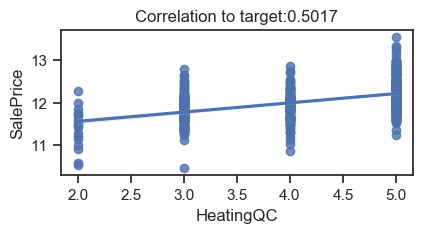

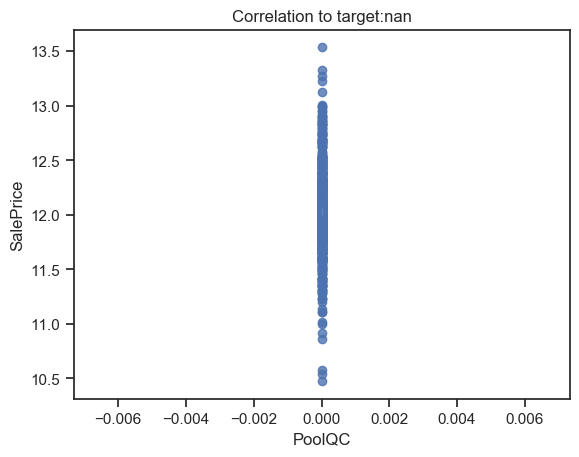

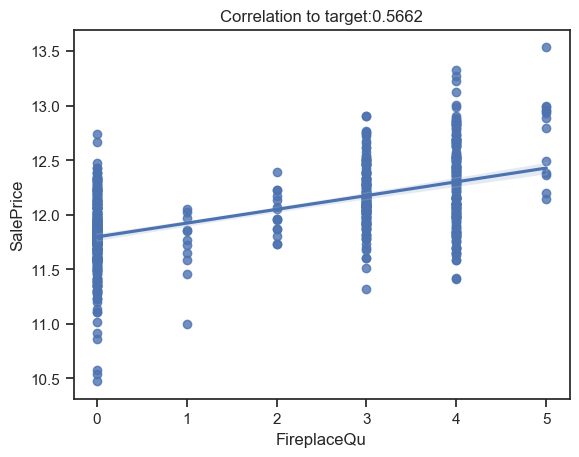

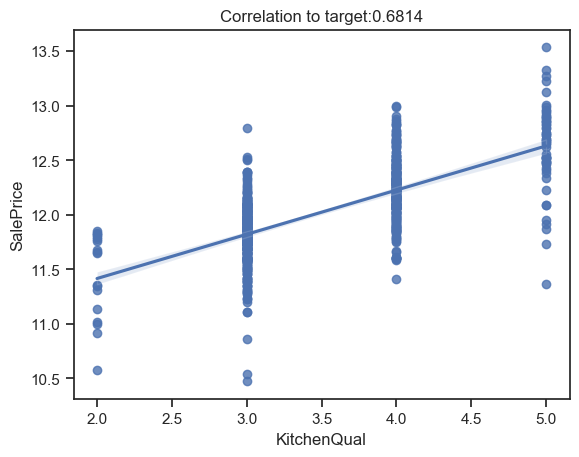

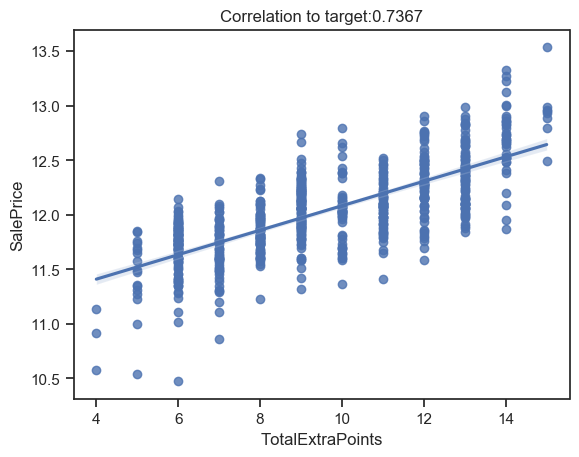

In [879]:
##Analisis gráfico y de correlación...
col_extra = ["HeatingQC",  "PoolQC",  "FireplaceQu",   "KitchenQual", "TotalExtraPoints"]
plot_vars(col_extra, df, "SalePrice")

##Se ve que extrapoints aporta una mayor correlación que todos los feats individuales

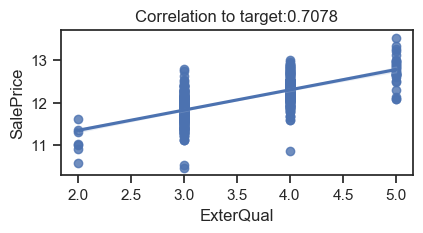

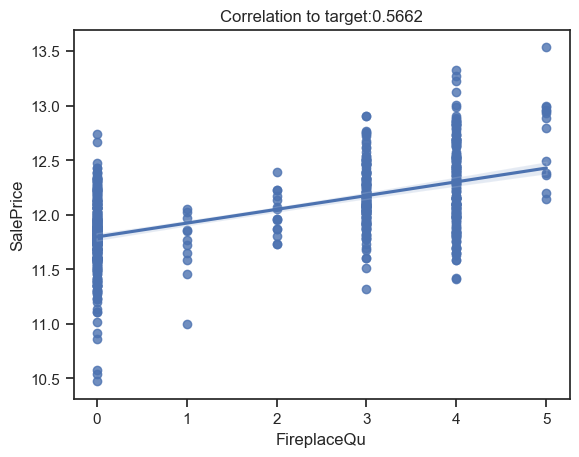

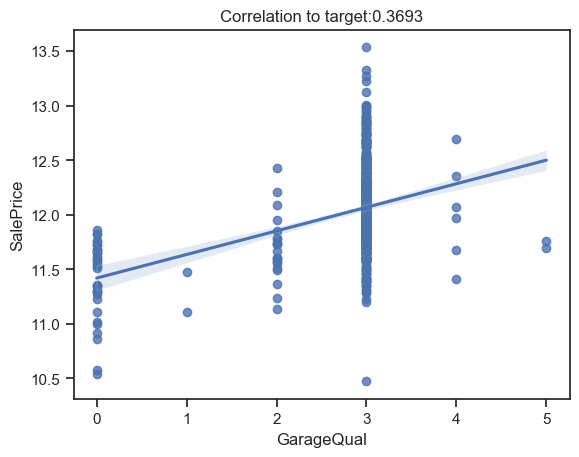

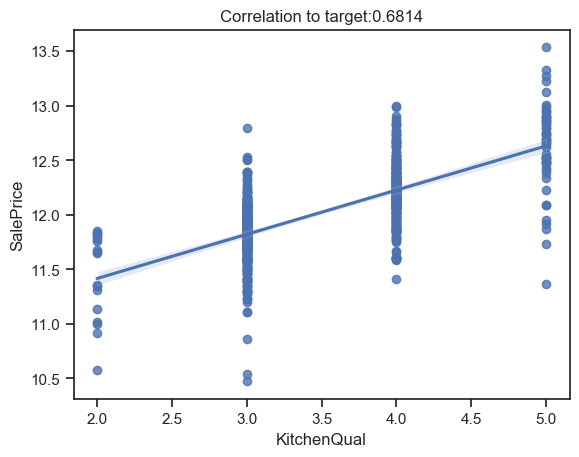

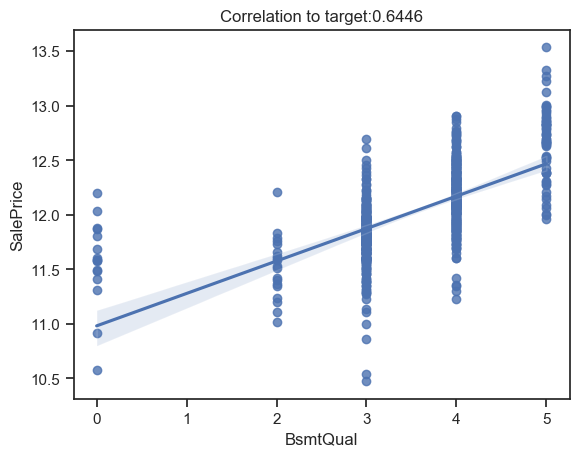

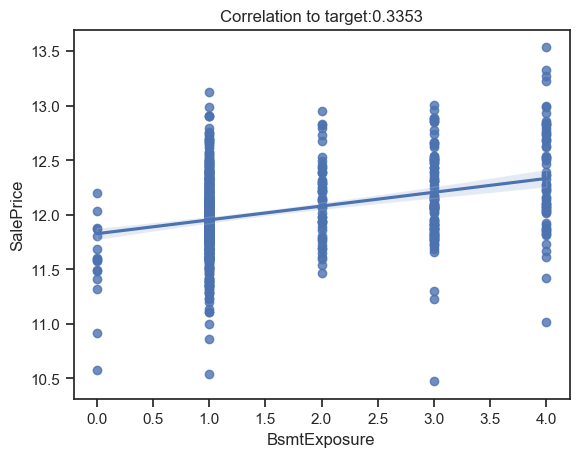

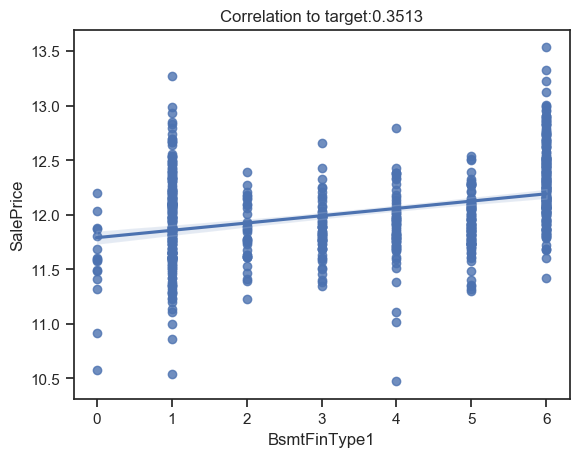

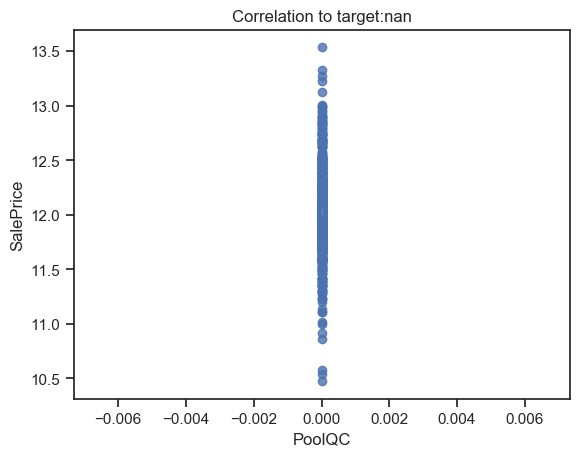

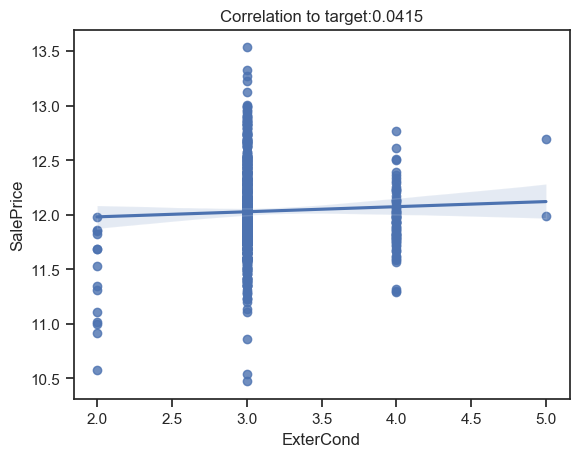

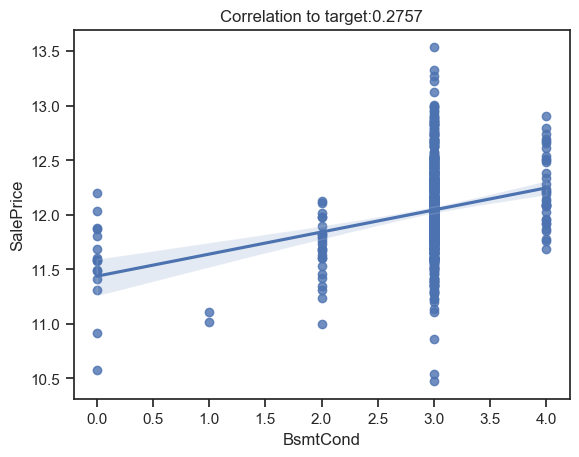

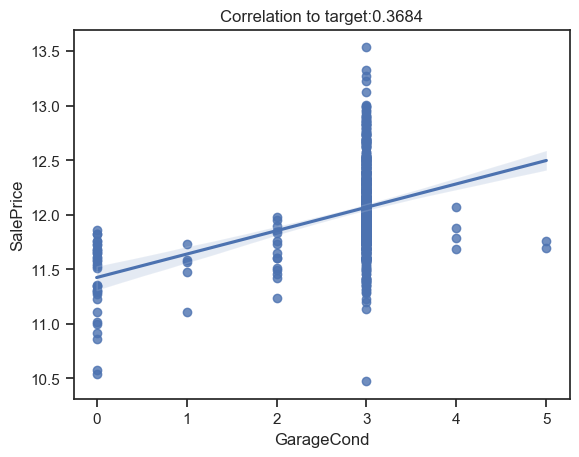

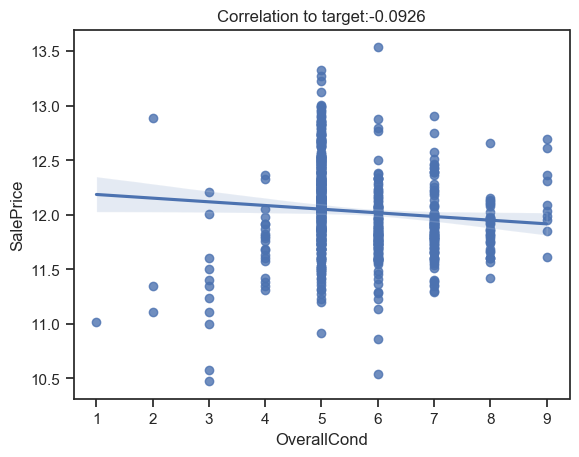

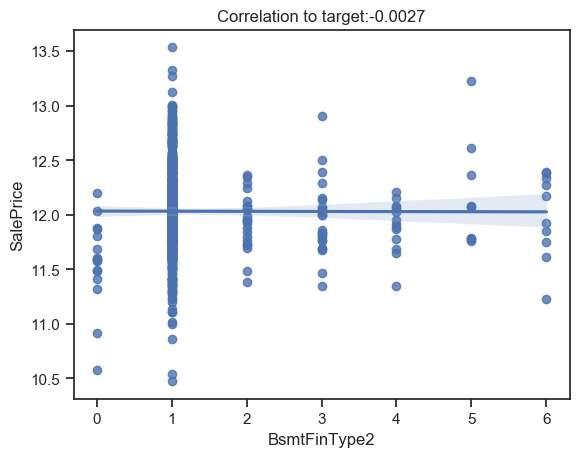

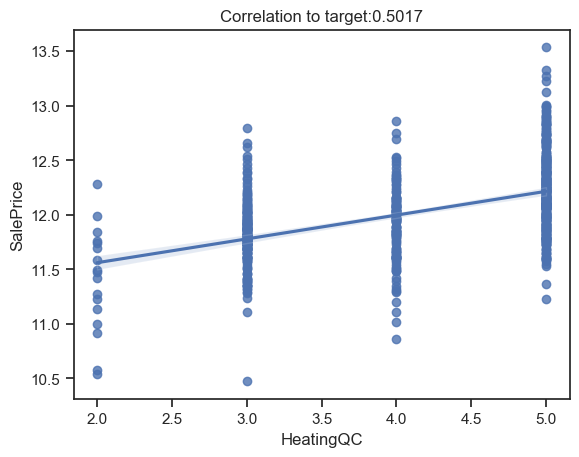

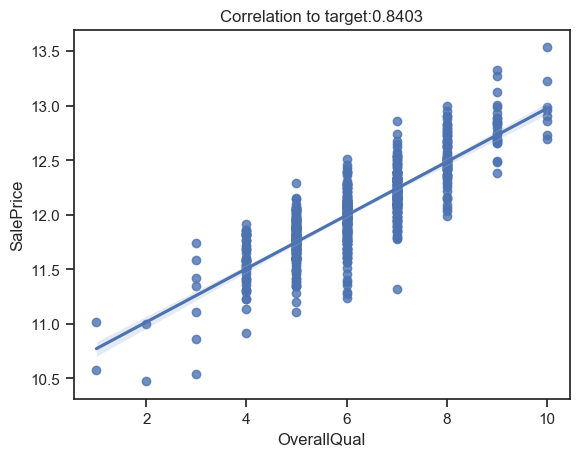

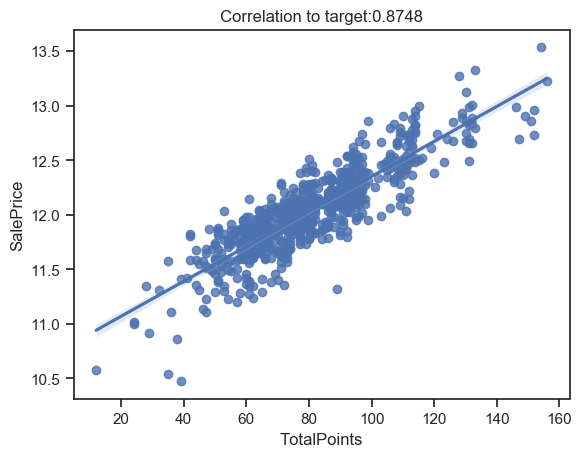

In [880]:
col_total = ["ExterQual" , "FireplaceQu" , "GarageQual" , "KitchenQual" ,
                            "BsmtQual" , "BsmtExposure" , "BsmtFinType1" , "PoolQC" , 
                            "ExterCond" , "BsmtCond" , "GarageCond" , "OverallCond" ,
                            "BsmtFinType2" , "HeatingQC" , "OverallQual", "TotalPoints"]
plot_vars(col_total, df, "SalePrice")

In [881]:
#Total points arroja una bella distribución con una correlación de .84 baja varianza

In [882]:
#Agregamos otros new features que habíamos creado y otros más que se le ocurrieron a Copetition
new_features = ['GarageArea * GarageCars','TotalBsmt * 1stFlrSF','YearBuilt * YearRemodAdd','TotalBathrooms',
 'TotalPorch','Area*Slope']
#Garagearea*Car
all_data["GarageArea_x_Car"] = all_data["GarageArea"] * all_data["GarageCars"]

#TotalBsmtx1stflr
all_data["TotalBsmtSF_x_Bsm"] = all_data["TotalBsmtSF"] * all_data["1stFlrSF"]

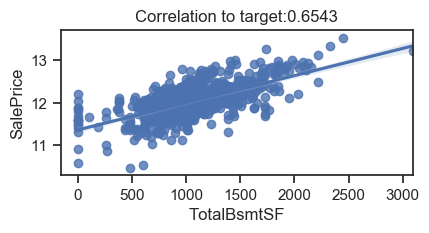

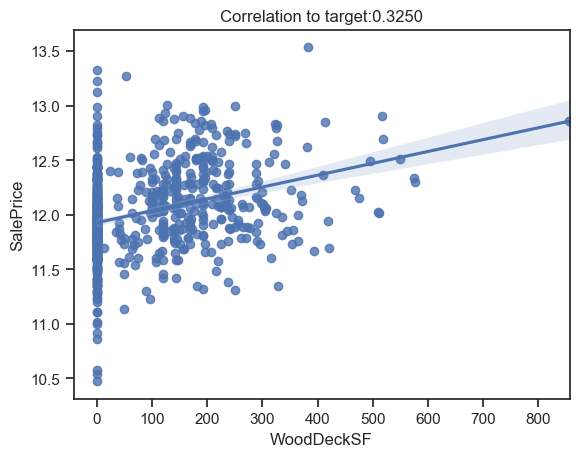

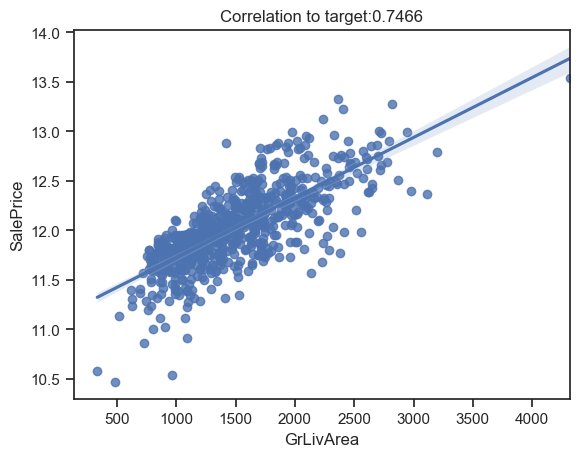

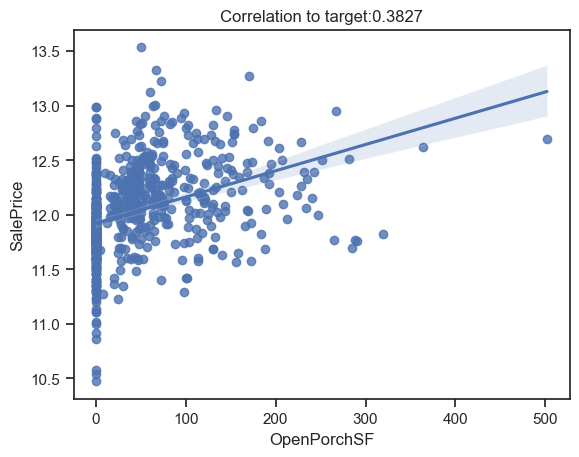

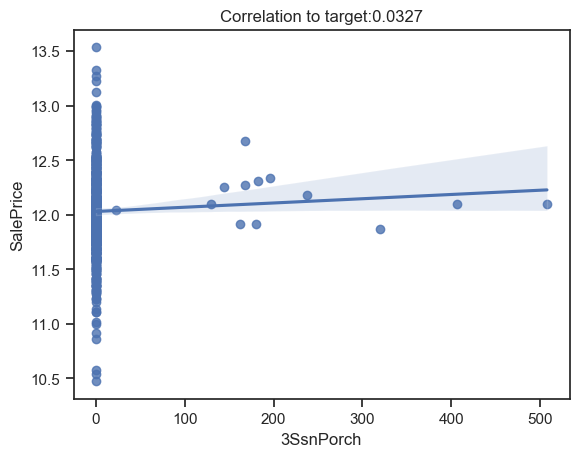

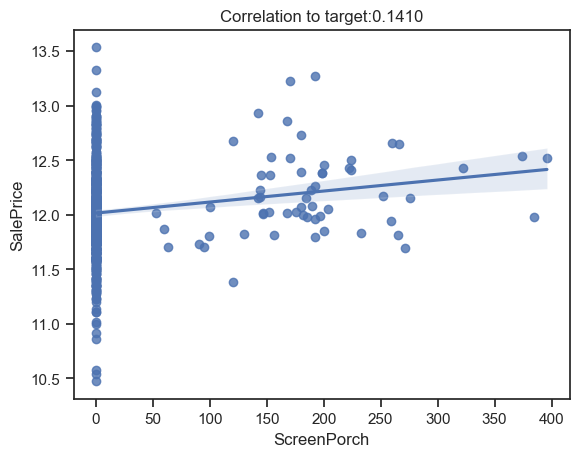

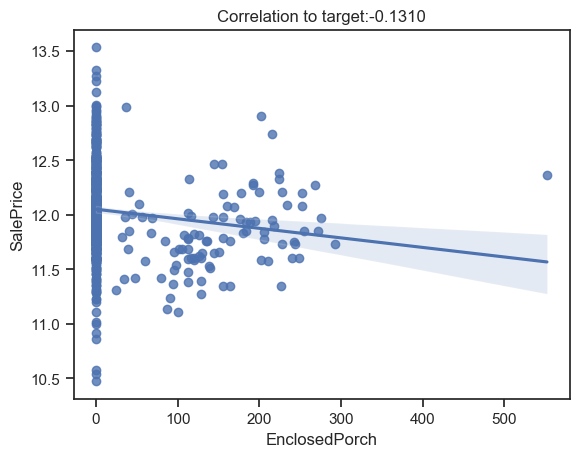

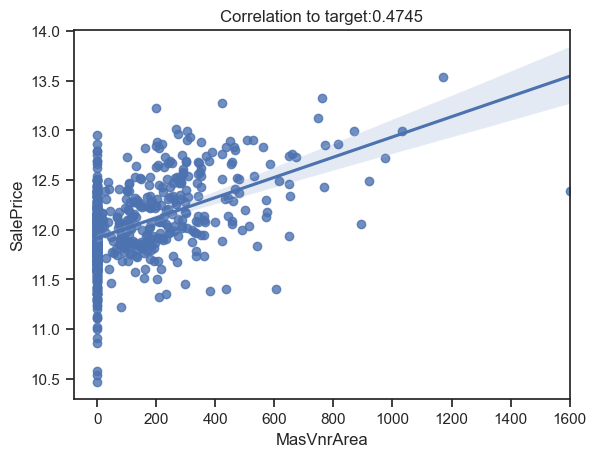

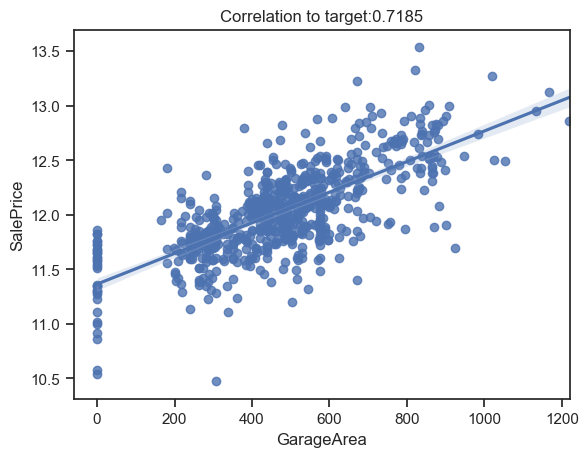

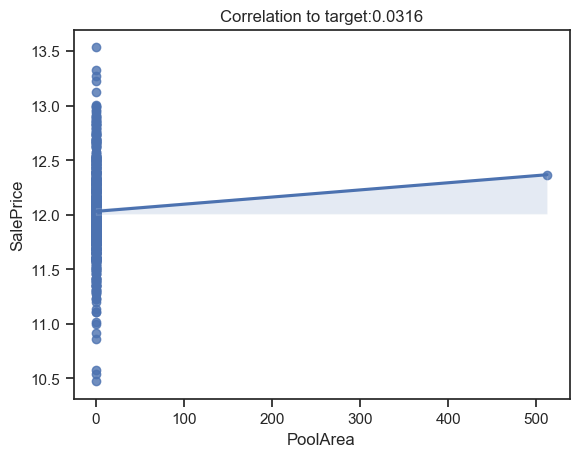

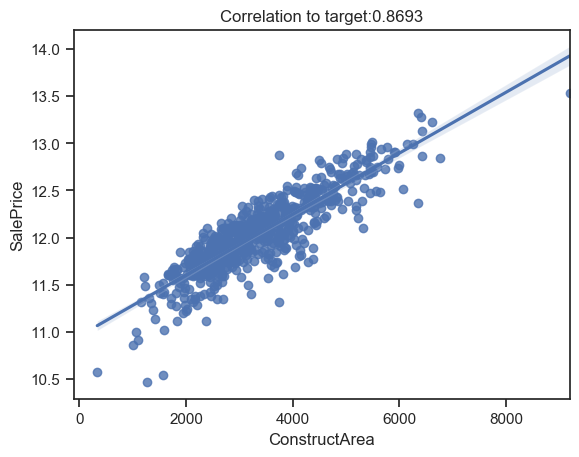

In [883]:
#Se crea un feature de area total de construccion
#Antes hay que convertir bsmtsf a int, porque es object
all_data["TotalBsmtSF"] = all_data["TotalBsmtSF"].astype("float64")
all_data['ConstructArea'] = (all_data.TotalBsmtSF + all_data.WoodDeckSF + all_data.GrLivArea +
                             all_data.OpenPorchSF + all_data["3SsnPorch"] + all_data.ScreenPorch + all_data.EnclosedPorch +
                             all_data.MasVnrArea + all_data.GarageArea + all_data.PoolArea )

#Testeamos qué tal se comporta...
df = all_data.iloc[:len(y_train), :]
df["SalePrice"] = y_train
col_const = ["TotalBsmtSF" , "WoodDeckSF" , "GrLivArea" ,
                             "OpenPorchSF" , "3SsnPorch" , "ScreenPorch" , "EnclosedPorch" ,
                             "MasVnrArea" , "GarageArea" , "PoolArea", "ConstructArea" ]
plot_vars(col_const, df, "SalePrice")


In [884]:
#3Muy buena correlacion de 0.86 en ConstructArea

In [885]:
new_features

['GarageArea * GarageCars',
 'TotalBsmt * 1stFlrSF',
 'YearBuilt * YearRemodAdd',
 'TotalBathrooms',
 'TotalPorch',
 'Area*Slope']

In [886]:
#TotalPorch
all_data["TotalPorch"] =  all_data["OpenPorchSF"] + all_data['EnclosedPorch']+ all_data['3SsnPorch'] 
+ all_data['ScreenPorch'] + all_data['WoodDeckSF']

#binarizacion de EnclosedPorch. NO se por qué no se hizo loo mismo con los otros features
all_data["EnclosedPorch"] = all_data["EnclosedPorch"].apply(lambda x: 1 if x else 0)

In [887]:
#GarageNewest
all_data["GarageNewest"] = all_data["YearBuilt"] > all_data["GarageYrBlt"]

#Eso me deja en True/False
all_data["GarageNewest"] = all_data["GarageNewest"].apply(lambda x: 1 if x else 0) # 1 si es True

In [888]:
#LotAreaMultSlope
all_data["LotAreaMultSlope"] = all_data["LotArea"] * all_data["LandSlope"]

In [889]:
#BsmtSFPoints

In [890]:
all_data["BsmtSFPoints"] = all_data["BsmtQual"]**2 + all_data["BsmtCond"] + all_data["BsmtExposure"] + all_data["BsmtFinType1"] + all_data["BsmtFinType2"] 

In [891]:
#['BsmtSFMultPoints']
all_data['BsmtSFMultPoints'] = all_data["TotalBsmtSF"] * (all_data["BsmtQual"]**2 + all_data["BsmtCond"] + all_data["BsmtExposure"] + all_data["BsmtFinType1"] + all_data["BsmtFinType2"] )

In [892]:
#TotalBathrooms
#Antes tengo que convertir dos features a numerico
all_data["BsmtFullBath"] = all_data["BsmtFullBath"].astype("int64")
all_data["BsmtHalfBath"] = all_data["BsmtHalfBath"].astype("int64")

all_data["TotBathrooms"] = all_data["FullBath"] +  all_data["HalfBath"] * 0.5 + all_data["BsmtFullBath"] + all_data["BsmtHalfBath"] * 0.5
##Cambio el type de TotBathrooms porque es int pero debe ser float
all_data["TotBathrooms"] = all_data["TotBathrooms"].astype("float64")

In [893]:
#Binarizacion de todos los bath del feature nuevo anterior
mas_cols  = ["FullBath", "HalfBath", "BsmtFullBath","BsmtHalfBath"]
for c in mas_cols:
    all_data[c] = all_data[c].apply(lambda x: 1 if x else 0)

In [894]:
all_data[mas_cols].head()

FullBath  HalfBath  BsmtFullBath  BsmtHalfBath
0  1         1         1             0           
1  1         0         0             1           
2  1         1         1             0           
3  1         0         1             0           
4  1         1         1             0

In [895]:
data_b = all_data.copy()
%store data_b

Stored 'data_b' (DataFrame)


In [896]:
%store all_data

Stored 'all_data' (DataFrame)


In [897]:
###TEST NULOS
all_data.isnull().sum().sum()

0

In [898]:
###ONE HOT ENCODING

In [899]:
#Chequear qué columnas debo incluir

In [900]:
categ_cols = all_data.select_dtypes(include = "object").columns

In [901]:
categ_cols

Index(['MSZoning', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'Electrical',
       'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition',
       'TotalBsmtSF_x_Bsm'],
      dtype='object')

In [902]:
##Comparando con las columnas del viejo, debo:
#Transformar a float ['BsmtFinSF2', 'BsmtUnfSF', 'BsmtFinSF1', 'TotalBsmtSF_x_Bsm']
#Agregar y convertir a object ['MoSold', 'MSSubClass']

convert_to_num = ['BsmtFinSF2', 'BsmtUnfSF', 'BsmtFinSF1', 'TotalBsmtSF_x_Bsm']
convert_to_obj = ['MoSold', 'MSSubClass']

for c in convert_to_num:
    all_data[c] = all_data[c].astype("float64")
    
for c in convert_to_obj:
    all_data[c] = all_data[c].astype("object")
    

In [903]:
categ_cols = all_data.select_dtypes(include = "object").columns

In [904]:
categ_cols

Index(['MSSubClass', 'MSZoning', 'Alley', 'LandContour', 'LotConfig',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature',
       'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')

In [905]:
dummy_cols = pd.get_dummies(data = all_data[categ_cols], columns=categ_cols).columns
all_data = pd.get_dummies(data = all_data, columns=categ_cols)##no voy a aplicar drop_first = True por ahora para seguir al viejo



In [906]:
all_data.shape

(2905, 258)

In [907]:
all_data.head(2)

LotFrontage  LotArea  Street  LotShape  LandSlope  OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  PoolQC  Fence  MiscVal  YrSold  TotalPoints  TotalExtraPoints  GarageArea_x_Car  TotalBsmtSF_x_Bsm  ConstructArea  TotalPorch  GarageNewest  LotAreaMultSlope  BsmtSFPoints  BsmtSFMultPoints  TotBathrooms  MSSubClass_20  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  MSSubClass_150  MSSubClass_160  MSSubClass_180  MSSubClass_190  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Alley_Grvl  Alley_NA  Alley_Pave  LandContour_Bnk  LandContour_HLS  LandContour_Low  LandContour_Lvl  LotConfig_Corner  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  Neighborhood_Blmngtn  Neighborhood_Blueste  Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Edwards  Neighborhood_Gilbert  Neighborhood_IDOTRR  Neighborhood_MeadowV  Neighborhood_Mitchel  Neighborhood_NAmes  Neighborhood_NPkVill  Neighborhood_NWAmes  Neighborhood_NoRidge  Neighborhood_NridgHt  Neighborhood_OldTown  Neighborhood_SWISU  Neighborhood_Sawyer  Neighborhood_SawyerW  Neighborhood_Somerst  Neighborhood_StoneBr  Neighborhood_Timber  Neighborhood_Veenker  Condition1_Artery  Condition1_Feedr  Condition1_Norm  Condition1_PosA  Condition1_PosN  Condition1_RRAe  Condition1_RRAn  Condition1_RRNe  Condition1_RRNn  Condition2_Artery  Condition2_Feedr  Condition2_Norm  Condition2_PosA  Condition2_PosN  Condition2_RRAe  Condition2_RRAn  Condition2_RRNn  BldgType_1Fam  BldgType_2fmCon  BldgType_Duplex  BldgType_Twnhs  BldgType_TwnhsE  HouseStyle_1.5Fin  HouseStyle_1.5Unf  HouseStyle_1Story  HouseStyle_2.5Fin  HouseStyle_2.5Unf  HouseStyle_2Story  HouseStyle_SFoyer  HouseStyle_SLvl  RoofStyle_Flat  RoofStyle_Gable  RoofStyle_Gambrel  RoofStyle_Hip  RoofStyle_Mansard  RoofStyle_Shed  RoofMatl_CompShg  RoofMatl_Membran  RoofMatl_Metal  RoofMatl_Roll  RoofMatl_Tar&Grv  RoofMatl_WdShake  RoofMatl_WdShngl  Exterior1st_AsbShng  Exterior1st_AsphShn  Exterior1st_BrkComm  Exterior1st_BrkFace  Exterior1st_CBlock  Exterior1st_CemntBd  Exterior1st_HdBoard  Exterior1st_ImStucc  Exterior1st_MetalSd  Exterior1st_Plywood  Exterior1st_Stone  Exterior1st_Stucco  Exterior1st_VinylSd  Exterior1st_Wd Sdng  Exterior1st_WdShing  Exterior2nd_AsbShng  Exterior2nd_AsphShn  Exterior2nd_Brk Cmn  Exterior2nd_BrkFace  Exterior2nd_CBlock  Exterior2nd_CmentBd  Exterior2nd_HdBoard  Exterior2nd_ImStucc  Exterior2nd_MetalSd  Exterior2nd_Other  Exterior2nd_Plywood  Exterior2nd_Stone  Exterior2nd_Stucco  Exterior2nd_VinylSd  Exterior2nd_Wd Sdng  Exterior2nd_Wd Shng  MasVnrType_BrkCmn  MasVnrType_BrkFace  MasVnrType_None  MasVnrType_Stone  Foundation_BrkTil  Foundation_CBlock  Foundation_PConc  Foundation_Slab  Foundation_Stone  Foundation_Wood  Heating_Floor  Heating_GasA  Heating_GasW  Heating_Grav  Heating_OthW  Heating_Wall  Electrical_FuseA  Electrical_FuseF  Electrical_FuseP  Electrical_Mix  Electrical_SBrkr  GarageType_2Types  GarageType_Attchd  GarageType_Basment  GarageType_BuiltIn  GarageType_CarPort  GarageType_Detchd  GarageType_NA  MiscFeature_Gar2  MiscFeature_NA  MiscFeature_Othr  MiscFeature_Pool  MiscFeature_Shed  MoSold_1  MoSold_2  MoSold_3  MoSold_4  MoSold_5  MoSold_6  MoSold_7  MoSold_8  MoSold_9  MoSold_10  MoSold_11  MoSold_12  SaleType_COD  SaleType_CWD  SaleType_Con  SaleTy

In [908]:
### ANALISIS ESPECIAL: HAY COLUMNAS QUE SUMEN CERO EN TOTAL EN EL TRAIN SET O CERO EN TOTAL EN EL TEST SET? SI ES ASÍ SE ELIMINAN

##Looking out in train set...

dum_z_train = []
for c in dummy_cols:
    if all_data[c][:len(y_train)].sum() == 0:
        dum_z_train.append(c)
print("Columns that sum zero in train set:", dum_z_train)
print("\n")
##Looking out in test set 
dum_z_test = []
for c in dummy_cols:
    if all_data[c][len(y_train):].sum() == 0:
       dum_z_test.append(c)
print("Columns that sum zero in test set:", dum_z_test)
        
   

Columns that sum zero in train set: ['MSSubClass_150', 'Condition2_RRAe', 'RoofStyle_Shed', 'RoofMatl_Roll', 'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_CBlock', 'Heating_Floor', 'Heating_OthW']


Columns that sum zero in test set: ['Condition2_RRAn', 'Condition2_RRNn', 'RoofMatl_Membran', 'RoofMatl_Metal', 'Exterior2nd_Other', 'Electrical_Mix']


In [909]:
##Remove the zero sum dummy cols from dataset
all_data.drop(columns = dum_z_test + dum_z_train, axis = 1, inplace = True)

## Update the dummy_cols:
dummy_cols = dummy_cols.drop((dum_z_test + dum_z_train)) ##dummy_cols es un index


In [910]:
#Updated shape of all_data
all_data.shape

(2905, 242)

In [911]:
%store all_data

Stored 'all_data' (DataFrame)


In [912]:
all_data.isnull().sum().sum()

0

In [913]:
##TRANSFORM YEARS TO AGE: this solves the dilemma of whether years are ordinal or numerical...

#Busquemos todos los features relacionados con year
mas_cols  = all_data.filter(like='Year', axis=1).columns
mas_cols = mas_cols.append(all_data.filter(like='Yr', axis=1).columns)

In [914]:
mas_cols

Index(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold'], dtype='object')

In [915]:
#Revisando se ve que 2010 es el año más reciente en todos los casos. Además hay valores zero
#Por tanto se convierte a age = 2011 - x si x no es cero y si lo es se deja en zero

for c in mas_cols:
    all_data[c] = all_data[c].apply(lambda x: 0 if x == 0 else 2011 - x)

In [916]:
##Mas features Deus Ex Machina
#[Remod] == indica binariamente si es o no remodelado
#["New"] == binario para ver si es nuevo
#[Age] == edad, entendida como la diferencia entyre remodelado y vendido

#Remod:
all_data["Remod"] = 100
all_data.loc[all_data["YearBuilt"] == all_data["YearRemodAdd"], ["Remod"]] = 0
all_data.loc[all_data["YearBuilt"] != all_data["YearRemodAdd"], ["Remod"]] = 1

#Remod:
all_data["New"] = 100
all_data.loc[all_data["YearBuilt"] == all_data["YearRemodAdd"], ["New"]] = 1
all_data.loc[all_data["YearBuilt"] != all_data["YearRemodAdd"], ["New"]] = 0

#Age
all_data["Age"] = all_data["YearRemodAdd"] - all_data["YrSold"]




In [917]:
%store all_data

Stored 'all_data' (DataFrame)


In [918]:
all_data.isnull().sum().sum()

0